# 5. Feature Selection & One-Hote Encoding

In [1]:
# ===============================================================
# טעינות חשובות + קבועים כלליים
# ===============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# bidi לעברית תקינה בגרפים (אם אין — התקיני: pip install python-bidi)
from bidi.algorithm import get_display
heb = lambda s: get_display(str(s))  # פונקציה פשוטה להפוך טקסט עברית

# נתיבים (שני משתנים שקל לשנות לפי צורך)
SOURCE_PATH = Path("data/interim/feature_engineering_v2_ready.pkl")  # קובץ המקור
WORK_PATH   = Path("data/interim/feature_selection_ohc_work.pkl")       # קובץ העבודה החדש

# תיקיית דוחות/ארטיפקטים (נשתמש בה לעתיד)
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

print("✅ טעינות הושלמו. אפשר להמשיך.")


✅ טעינות הושלמו. אפשר להמשיך.


In [2]:
# ===============================================================
# הגדרות גרפיות שאני אוהבת (עברית, אחוזים, צבעים, גריד)
# ===============================================================

# עיצוב כללי
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "Arial"          # עדיף Arial לעברית
plt.rcParams["axes.unicode_minus"] = False     # סימן מינוס נכון
plt.rcParams["figure.dpi"] = 120

# פלטת צבעים רגועה (לילך/כחולים עדינים)
PALETTE = ["#c891a6", "#7aa6c2", "#b79bd1", "#9db7d6", "#d8b9c3", "#8ca8c0"]

def add_bar_labels(ax, show_percent=True, decimals=1):
    """
    כותבת מעל כל עמודה את המספר, ואם יש total בצירוף אחוז.
    אם רוצים רק מספרים – העבירו show_percent=False.
    """
    # ננסה לחשב total ליתר ביטחון (לוקטור הראשון שזמין)
    total = None
    try:
        heights = [p.get_height() for p in ax.patches]
        total = sum(h for h in heights if pd.notna(h))
    except Exception:
        pass

    for p in ax.patches:
        if pd.isna(p.get_height()):
            continue
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        label = f"{int(y):,}"
        if show_percent and total and total > 0:
            pct = y / total * 100
            label = f"{int(y):,}  ({pct:.{decimals}f}%)"
        ax.text(x, y, label, ha="center", va="bottom", fontsize=10)

def style_axes(ax, title=None, xlabel=None, ylabel=None, rtl=True):
    """
    עיצוב ציר/כותרות בעברית, גריד וקצת מרווחים.
    """
    if title:  ax.set_title(heb(title) if rtl else title, fontsize=14, pad=12)
    if xlabel: ax.set_xlabel(heb(xlabel) if rtl else xlabel)
    if ylabel: ax.set_ylabel(heb(ylabel) if rtl else ylabel)
    ax.grid(True, axis="y", alpha=0.25)
    plt.tight_layout()


In [3]:
# ===============================================================
# טעינת קובץ העבודה (Feature Selection & One-Hot Encoding)
# ===============================================================
import pandas as pd
from pathlib import Path


# בדיקת קיום קובץ מקור
if not SOURCE_PATH.exists():
    raise FileNotFoundError(f"לא נמצא קובץ מקור: {SOURCE_PATH}")

# טעינת קובץ המקור
df = pd.read_pickle(SOURCE_PATH)
print(f"📥 נטען קובץ המקור | צורה: {df.shape}")

# שמירת עותק ראשוני לקובץ העבודה החדש
WORK_PATH.parent.mkdir(parents=True, exist_ok=True)
df.to_pickle(WORK_PATH)
print(f"💾 נשמר קובץ עבודה חדש ל: {WORK_PATH}")

# צילום מצב "לפני" ו"אחרי" לשימוש בפונקציית ההשוואה
df_src  = df.copy()                  # BEFORE
df_work = pd.read_pickle(WORK_PATH)  # AFTER (כעת זהה, רק לבדיקת זרימה)
print("✅ הכל מוכן — אפשר לעבור לזיהוי המשתנים הקטגוריאליים.")


📥 נטען קובץ המקור | צורה: (21981, 499)
💾 נשמר קובץ עבודה חדש ל: data\interim\feature_selection_ohc_work.pkl
✅ הכל מוכן — אפשר לעבור לזיהוי המשתנים הקטגוריאליים.


In [4]:
# ===============================================================
# פונקציה: דוח לפני/אחרי (shape, עמודות שנוספו/הוסרו, שינויי טיפוסים)
# ===============================================================
import pandas as pd

def compare_snapshots(before_df: pd.DataFrame, after_df: pd.DataFrame, save_path: Path | None = None):
    shape_before = before_df.shape
    shape_after  = after_df.shape

    cols_before = set(before_df.columns)
    cols_after  = set(after_df.columns)
    added   = sorted(cols_after - cols_before)
    removed = sorted(cols_before - cols_after)
    stayed  = sorted(cols_before & cols_after)

    dtype_changes = []
    for c in stayed:
        b, a = str(before_df[c].dtype), str(after_df[c].dtype)
        if b != a:
            dtype_changes.append((c, b, a))
    dtype_changes_df = pd.DataFrame(dtype_changes, columns=["column", "dtype_before", "dtype_after"])

    added_df   = pd.DataFrame({"column": added}) if added else pd.DataFrame(columns=["column"])
    removed_df = pd.DataFrame({"column": removed}) if removed else pd.DataFrame(columns=["column"])

    print("—"*70)
    print(f"🔎 צורה לפני:  {shape_before} | צורה אחרי: {shape_after}")
    print(f"➕ נוספו עמודות: {len(added)}  | ➖ הוסרו עמודות: {len(removed)}  | 🔁 שינויי טיפוסים: {len(dtype_changes)}")
    if added:   print("   דוגמאות שנוספו:", added[:10])
    if removed: print("   דוגמאות שהוסרו:", removed[:10])
    if len(dtype_changes) > 0: print("   דוגמאות שינויי טיפוס:", dtype_changes[:10])
    print("—"*70)

    if save_path is not None:
        (ARTIFACTS_DIR / "change_logs").mkdir(parents=True, exist_ok=True)
        base = (ARTIFACTS_DIR / "change_logs" / save_path.name).with_suffix("")
        added_fp   = base.with_name(base.name + "_added_cols.csv")
        removed_fp = base.with_name(base.name + "_removed_cols.csv")
        dtypes_fp  = base.with_name(base.name + "_dtype_changes.csv")
        added_df.to_csv(added_fp, index=False, encoding="utf-8-sig")
        removed_df.to_csv(removed_fp, index=False, encoding="utf-8-sig")
        dtype_changes_df.to_csv(dtypes_fp, index=False, encoding="utf-8-sig")
        print(f"📝 נשמרו דוחות:\n • {added_fp}\n • {removed_fp}\n • {dtypes_fp}")

    return {"shape_before": shape_before,
            "shape_after": shape_after,
            "added": added_df,
            "removed": removed_df,
            "dtype_changes": dtype_changes_df}

# בדיקת זרימה (כרגע צפוי ללא שינוי)
_ = compare_snapshots(
    df_src, df_work,
    save_path=Path("snapshot_feature_selection_ohe.csv")  # נשמר תחת artifacts/change_logs/
)


——————————————————————————————————————————————————————————————————————
🔎 צורה לפני:  (21981, 499) | צורה אחרי: (21981, 499)
➕ נוספו עמודות: 0  | ➖ הוסרו עמודות: 0  | 🔁 שינויי טיפוסים: 0
——————————————————————————————————————————————————————————————————————
📝 נשמרו דוחות:
 • artifacts\change_logs\snapshot_feature_selection_ohe_added_cols.csv
 • artifacts\change_logs\snapshot_feature_selection_ohe_removed_cols.csv
 • artifacts\change_logs\snapshot_feature_selection_ohe_dtype_changes.csv


In [5]:
# ===============================================================
# איתור משתנים טקסטואליים/קטגוריאליים ובדיקת מספר קטגוריות
# ===============================================================
cat_summary = (
    df_work.select_dtypes(include=["object", "string", "category"])
    .nunique(dropna=False)
    .reset_index()
    .rename(columns={"index": "column", 0: "unique_values"})
    .sort_values("unique_values", ascending=False)
)

# הצגת סיכום כללי
print(f"נמצאו {len(cat_summary)} משתנים קטגוריאליים/טקסטואליים.")
display(cat_summary.head(30))  # נציג את ה-30 הראשונים להתרשמות

# אם תרצי גם לשמור לאקסל לבדיקה נוחה:
cat_summary.to_csv("artifacts/categorical_columns_summary.csv", index=False, encoding="utf-8-sig")
print("📄 נשמר דוח מפורט בתיקיית artifacts.")


נמצאו 81 משתנים קטגוריאליים/טקסטואליים.


,column,unique_values
11,id_number,21783
6,service_location_m1,1667
5,service_code,900
4,service_name_m1,335
9,program_name_m1,203
10,program_code_m1,202
49,service_name_m1_clean,185
73,yeshuv_name_norm,183
2,yeshuv_name_m1,183
74,matched_name,167


📄 נשמר דוח מפורט בתיקיית artifacts.


In [6]:
# ===============================================================
# איתור אוטומטי של עמודות שמכילות "code" / "id" / "norm" בשם
# ===============================================================
import re

# נגדיר ביטוי רגולרי לחיפוש (לא תלוית רישיות)
pattern = re.compile(r"(code|id|norm)", flags=re.IGNORECASE)

# נזהה את כל העמודות המתאימות
code_like_cols = [c for c in df.columns if pattern.search(c)]

print(f"📊 נמצאו {len(code_like_cols)} עמודות עם code/id/norm בשם:")
for c in code_like_cols:
    print(" •", c)

# ניצור DataFrame לתיעוד קצר
code_like_df = pd.DataFrame({"column": code_like_cols})
code_like_df.to_csv("artifacts/auto_detected_code_columns.csv", index=False, encoding="utf-8-sig")

# אפשר גם להוציא גרסה של הדאטה בלי עמודות אלה (לבדיקה בהמשך)
df_no_codes = df.drop(columns=code_like_cols, errors="ignore")

print(f"\n✅ נוצרה גרסה df_no_codes ללא עמודות קוד | צורה: {df_no_codes.shape}")


📊 נמצאו 36 עמודות עם code/id/norm בשם:
 • ref_id_360_m1
 • yeshuv_code
 • service_code
 • program_code_m1
 • id_number
 • lgbtq_self_id_m1
 • residence_neighborhood_m1
 • ri2_1_parents_not_providing_care_m1
 • ri3_3_many_accidents_m1
 • ri4_1_parents_avoid_interaction_star_m1
 • rs10_1_physical_harm_by_adults_outside_star_m1
 • rs12_1_difficulty_providing_enrichment_m1
 • ri_gr14_2_avoids_participation_m1
 • ri17_1_withdraws_avoids_peers_star_m1
 • ri19_4_avoids_contact_adults_star_m1
 • RS23_suicidal_ideation_attempts_m1
 • rs23_1_suicidal_ideation_attempts_star_m1
 • st8_emotion_identification_expression_m1
 • ref_id_360_m2
 • program_code_m2
 • lgbtq_self_id_m2
 • residence_neighborhood_m2
 • ri2_1_parents_not_providing_care_m2
 • ri3_3_many_accidents_m2
 • ri4_1_parents_avoid_interaction_star_m2
 • rs10_1_physical_harm_by_adults_outside_star_m2
 • rs12_1_difficulty_providing_enrichment_m2
 • ri_gr14_2_avoids_participation_m2
 • ri17_1_withdraws_avoids_peers_star_m2
 • ri19_4_avoids

In [7]:
# ===============================================================
# הגדרת מזהים טכניים שאינם רלוונטיים למודל ושמירתם בצד
# ===============================================================

# רשימת מזהים טכניים — נוריד בהמשך לפני שלב המודלים
id_columns = [
    "ref_id_360_m1",
    "ref_id_360_m2",
    "id_number",
    "yeshuv_code",
    "yeshuv_name_norm",
    "service_code",
    "program_code",
    "program_code_m1",
    "program_code_m2",
]

# נשמור רק את אלו שקיימים בפועל
id_columns = [c for c in id_columns if c in df.columns]

print(f"📦 נמצאו {len(id_columns)} עמודות מזהים לשמירה בצד:")
for c in id_columns:
    print(" •", c)

# ניצור DataFrame קטן רק עבור המזהים, לשמירה נוחה אם נצטרך בהמשך
df_ids = df[id_columns].copy()
df_ids.to_csv("artifacts/id_columns_reference.csv", index=False, encoding="utf-8-sig")

# גרסה נקייה לעבודה בהמשך (נשאיר שכונות וישובים)
df_no_ids = df.drop(columns=id_columns, errors="ignore")

print(f"\n✅ נוצרה גרסה df_no_ids ללא עמודות מזהים | צורה: {df_no_ids.shape}")


📦 נמצאו 9 עמודות מזהים לשמירה בצד:
 • ref_id_360_m1
 • ref_id_360_m2
 • id_number
 • yeshuv_code
 • yeshuv_name_norm
 • service_code
 • program_code
 • program_code_m1
 • program_code_m2

✅ נוצרה גרסה df_no_ids ללא עמודות מזהים | צורה: (21981, 490)


In [8]:
# ===============================================================
# איתור וסיכום משתנים קטגוריאליים/טקסטואליים ב־ df_no_ids
# ===============================================================

import pandas as pd
from pathlib import Path

# אם במקרה עוד לא נוצר df_no_ids, נעבוד על df
if "df_no_ids" not in globals():
    df_no_ids = df.copy()

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# אילו טיפוסים נחשב כקטגוריאליים/טקסטואליים
CAT_DTYPES = ["object", "string", "category", "bool"]

# יצירת טבלת סיכום
cat_cols = df_no_ids.select_dtypes(include=CAT_DTYPES).columns.tolist()

cat_summary = (
    pd.DataFrame({
        "column": cat_cols,
        "dtype": [str(df_no_ids[c].dtype) for c in cat_cols],
        "unique_values": [df_no_ids[c].nunique(dropna=False) for c in cat_cols],
        "missing_count": [df_no_ids[c].isna().sum() for c in cat_cols],
    })
    .assign(missing_pct=lambda d: (d["missing_count"] / len(df_no_ids) * 100).round(2))
    .sort_values("unique_values", ascending=False)  # מיון יורד לפי מספר ייחודיים
    .reset_index(drop=True)
)

print(f"✅ נמצאו {len(cat_summary)} משתנים קטגוריאליים/טקסטואליים ב־df_no_ids.\n")
display(cat_summary.head(30))  # תצוגה של ה-30 הראשונים

# שמירה לקובץ
out_path = ARTIFACTS_DIR / "categorical_columns_summary.csv"
cat_summary.to_csv(out_path, index=False, encoding="utf-8-sig")
print(f"💾 נשמר דוח מלא בתיקיית artifacts: {out_path}")

# קביעת רמות קרדינליות — יעזור להחליט על סוג קידוד
HIGH_CARD_THRESHOLD = 30   # מעל זה נחשב "גבוה"
MED_CARD_THRESHOLD_LO = 11 # בינוני

high_card = cat_summary.loc[cat_summary["unique_values"] > HIGH_CARD_THRESHOLD, "column"].tolist()
med_card  = cat_summary.loc[(cat_summary["unique_values"] >= MED_CARD_THRESHOLD_LO) &
                            (cat_summary["unique_values"] <= HIGH_CARD_THRESHOLD), "column"].tolist()
low_card  = cat_summary.loc[cat_summary["unique_values"] < MED_CARD_THRESHOLD_LO, "column"].tolist()

print("\n🔎 חלוקה לפי רמות קרדינליות:")
print(f"• גבוהים  (>{HIGH_CARD_THRESHOLD} קטגוריות): {len(high_card)}  → Frequency / Target / Top-K / Hash")
print(f"• בינוניים ({MED_CARD_THRESHOLD_LO}–{HIGH_CARD_THRESHOLD}): {len(med_card)}  → OHE אפשרי")
print(f"• נמוכים  (<{MED_CARD_THRESHOLD_LO}): {len(low_card)}  → OHE פשוט ונקי")

# ---------------------------------------------------------------
# פונקציית עזר להצגת שכיחויות של עמודה נבחרת
# ---------------------------------------------------------------
def preview_categories(col: str, top: int = 20, include_na: bool = True):
    """
    מציג שכיחויות של עמודה קטגוריאלית/טקסטואלית.
    שימוש: preview_categories("service_name_m1", top=20)
    """
    if col not in df_no_ids.columns:
        print(f"⚠️ '{col}' לא נמצאת ב־df_no_ids.")
        return

    vc = df_no_ids[col].value_counts(dropna=not include_na)
    total = vc.sum()

    out = (
        vc.head(top)
          .rename_axis("value")
          .reset_index(name="count")
          .assign(pct=lambda d: (d["count"] / total * 100).round(2))
    )

    print(f"\n📊 '{col}' — ערכים ייחודיים: {df_no_ids[col].nunique(dropna=False)} | רשומות: {len(df_no_ids)}")
    display(out)
    if len(vc) > top:
        print(f"... ועוד {len(vc) - top} קטגוריות נוספות שלא הוצגו.")

print("\n💡 טיפ: להריץ preview_categories('<שם עמודה>') כדי לראות את TOP הקטגוריות לדוגמה.")


✅ נמצאו 89 משתנים קטגוריאליים/טקסטואליים ב־df_no_ids.



,column,dtype,unique_values,missing_count,missing_pct
0,service_location_m1,category,1667,0,0.0
1,service_name_m1,category,335,0,0.0
2,program_name_m1,category,203,0,0.0
3,service_name_m1_clean,category,185,0,0.0
4,yeshuv_name_m1,category,183,0,0.0
5,matched_name,object,167,0,0.0
6,program_name_m1_clean,category,154,0,0.0
7,program_name_alt,category,77,0,0.0
8,program_name,category,77,0,0.0
9,desired_secondary_outcome,category,31,0,0.0


💾 נשמר דוח מלא בתיקיית artifacts: artifacts\categorical_columns_summary.csv

🔎 חלוקה לפי רמות קרדינליות:
• גבוהים  (>30 קטגוריות): 10  → Frequency / Target / Top-K / Hash
• בינוניים (11–30): 19  → OHE אפשרי
• נמוכים  (<11): 60  → OHE פשוט ונקי

💡 טיפ: להריץ preview_categories('<שם עמודה>') כדי לראות את TOP הקטגוריות לדוגמה.


In [9]:
# ===============================================================
# Helpers for leak filtering (define once, safe to run anytime)
# ===============================================================
from typing import List

TARGET = "target_binary_improved"  # our target column

# tokens considered as leaks (EXCEPT the target itself)
LEAK_TOKENS: List[str] = ["target_", "_m2", "_delta", "_change", "improved", "worsened", "delta"]

def is_leak(name: str) -> bool:
    s = str(name).lower()
    # Protect the exact target name; everything else that matches tokens is a leak
    return (name != TARGET) and any(tok in s for tok in LEAK_TOKENS)


In [10]:
# ===============================================================
# בדיקת עמודת שכונה — האם נותרו מעט קטגוריות בטעות?
# ===============================================================

col = "residence_neighborhood_m1"
if col not in df_no_ids.columns:
    print("⚠️ העמודה לא קיימת ב־df_no_ids.")
else:
    print(f"📊 {col}: {df_no_ids[col].nunique(dropna=False)} ערכים ייחודיים מתוך {len(df_no_ids)} רשומות.")
    print("\n🪄 TOP 25 שכיחים:")
    display(df_no_ids[col].value_counts(dropna=False).head(25))

    # האם יש ערכים שנראים כמו יישובים (רמז לשגיאת איחוד)
    possible_city_names = set(df_no_ids["yeshuv_name_m1"].unique())
    overlap = set(df_no_ids[col].unique()) & possible_city_names
    print(f"\n🔎 כמה ערכים זהים לשמות יישובים: {len(overlap)}")
    if overlap:
        print("דוגמאות:", list(overlap)[:10])


📊 residence_neighborhood_m1: 8 ערכים ייחודיים מתוך 21981 רשומות.

🪄 TOP 25 שכיחים:


residence_neighborhood_m1
אחר           19563
בני ברק         616
בית שמש         420
אלעד            353
כפר קאסם        268
מכר ג'דידה      259
מרכז העיר       253
אשדוד           249
Name: count, dtype: int64


🔎 כמה ערכים זהים לשמות יישובים: 5
דוגמאות: ['אלעד', 'כפר קאסם', 'בני ברק', 'אשדוד', 'בית שמש']


In [11]:
# נבדוק את שיעורי ההופעה של כל שכונה
col = "residence_neighborhood_m1"
vc = df_no_ids[col].value_counts(normalize=True).mul(100).round(2)
display(vc)

# כמה קטגוריות נכללו ב"אחר"
others = (vc < 1).sum()
print(f"🏷️ {others} קטגוריות הוסבו ל'אחר' (פחות מ-1%)")


residence_neighborhood_m1
אחר           89.00
בני ברק        2.80
בית שמש        1.91
אלעד           1.61
כפר קאסם       1.22
מכר ג'דידה     1.18
מרכז העיר      1.15
אשדוד          1.13
Name: proportion, dtype: float64

🏷️ 0 קטגוריות הוסבו ל'אחר' (פחות מ-1%)


In [12]:
# ===============================================================
# סיכום החלטות על משתנים גאוגרפיים ותוכניות 
# ===============================================================
import pandas as pd

# רשימות לפי החלטה
remove_from_model = [
    "residence_locality_m1_clean",
    "matched_name",
]

freq_encode_cols = [
    "service_location_m1",
    "service_name_m1",
    "service_name_m1_clean",
]

program_cols = [
    "program_name_m1",
    "program_name_m1_clean",
    "program_name",
    "program_name_alt",
]

topk_yishuv_col = "yeshuv_name_m1"
TOP_K = 30

# --- בדיקה: אילו מהעמודות קיימות בפועל ---
for group, cols in {
    "להוצאה מהמודל": remove_from_model,
    "לקידוד שכיחויות (Frequency)": freq_encode_cols,
    "לתוכניות (בדיקת 30 שכיחים)": program_cols,
}.items():
    existing = [c for c in cols if c in df_no_ids.columns]
    print(f"\n📂 {group} — נמצאו {len(existing)} עמודות:")
    for c in existing:
        print(" •", c)

# --- בדיקת 30 שכיחים ביותר בכל עמודה רלוונטית ---
def top_values(col, k=30):
    # value_counts תמיד מחזיר סדרה מספרית, אבל נכריח טיפוס ליתר ביטחון
    vc = df_no_ids[col].value_counts(dropna=False).astype("int64")
    total = int(vc.sum()) if len(vc) else 0

    df_top = (
        vc.head(k)
          .rename_axis(col)            # שם העמודה של הערכים
          .reset_index(name="count")   # עמודת הספירה
    )

    # המרה בטוחה למספרים (למקרה קצה שבו נהיה ב-category)
    df_top["count"] = pd.to_numeric(df_top["count"], errors="coerce").fillna(0).astype("int64")

    if total > 0:
        df_top["pct"] = (df_top["count"] / total * 100).round(2)
    else:
        df_top["pct"] = 0.0

    print(f"\n📊 {col}: {df_no_ids[col].nunique(dropna=False)} ערכים ייחודיים (TOP {k}):")
    display(df_top)

# --- תוכניות ---
for col in [c for c in program_cols if c in df_no_ids.columns]:
    top_values(col, k=30)

# --- יישובים ---
if topk_yishuv_col in df_no_ids.columns:
    top_values(topk_yishuv_col, k=30)
else:
    print("\n⚠️ לא נמצאה עמודת יישוב yeshuv_name_m1")

print("\n💡 לאחר הבדיקה נוכל להחיל Frequency Encoding לשירותים ו־Top-30 ליישובים.")



📂 להוצאה מהמודל — נמצאו 2 עמודות:
 • residence_locality_m1_clean
 • matched_name

📂 לקידוד שכיחויות (Frequency) — נמצאו 3 עמודות:
 • service_location_m1
 • service_name_m1
 • service_name_m1_clean

📂 לתוכניות (בדיקת 30 שכיחים) — נמצאו 4 עמודות:
 • program_name_m1
 • program_name_m1_clean
 • program_name
 • program_name_alt

📊 program_name_m1: 203 ערכים ייחודיים (TOP 30):


,program_name_m1,count,pct
0,אור רב תחומי,3594,16.35
1,"חדרי שלווה (חם)-מענה רגשי במצבי מצוקה וסיכון, ...",2493,11.34
2,מעגן - מערך תומך מעון-גן,1608,7.32
3,מרכז נוער ישובי / שכונתי,1348,6.13
4,פותחים עתיד,1233,5.61
5,מרכזי למידה שכונתיים,1102,5.01
6,חיזוק משאבי התמודדות באמצעות טיפול באומנויות,899,4.09
7,יחידות התפתחותיות קהילתיות,685,3.12
8,"מל""א – מרחב למידה אחר",540,2.46
9,טיפולים קבוצתיים לילדים ו/או הורים - ילד ונוער,497,2.26



📊 program_name_m1_clean: 154 ערכים ייחודיים (TOP 30):


,program_name_m1_clean,count,pct
0,תוכנית אור,3839,17.47
1,מעגן,2831,12.88
2,חדרי שלווה (חם),2800,12.74
3,מרכז נוער,1371,6.24
4,פותחים עתיד,1233,5.61
5,מרכזי למידה שכונתיים,1102,5.01
6,חיזוק משאבי התמודדות באמצעות טיפול באומנויות,899,4.09
7,יחידות התפתחותיות קהילתיות,685,3.12
8,"מל""א מרחב למידה אחר",540,2.46
9,טיפולים קבוצתיים,514,2.34



📊 program_name: 77 ערכים ייחודיים (TOP 30):


,program_name,count,pct
0,תוכנית אור רב תחומי,3594,16.35
1,unknown,3476,15.81
2,"חדרי שלווה (חם)-מענה רגשי במצבי מצוקה וסיכון, ...",2493,11.34
3,מעגן - מערך תומך מעון-גן,1608,7.32
4,מרכז נוער ישובי / שכונתי,1348,6.13
5,פותחים עתיד,1233,5.61
6,מרכזי למידה שכונתיים,1102,5.01
7,חיזוק משאבי התמודדות באמצעות טיפול באומנויות,899,4.09
8,יחידות התפתחותיות קהילתיות,685,3.12
9,"מל""א – מרחב למידה אחר",540,2.46



📊 program_name_alt: 77 ערכים ייחודיים (TOP 30):


,program_name_alt,count,pct
0,אור רב תחומי,3594,16.35
1,unknown,3476,15.81
2,"חדרי שלווה - מענה רגשי במצבי אלימות, טראומה וס...",2493,11.34
3,מעגן - מערך תומך מעון-גן,1608,7.32
4,מרכז נוער יישובי/שכונתי,1348,6.13
5,פותחים עתיד,1233,5.61
6,מרכזי למידה שכונתיים,1102,5.01
7,חיזוק משאבי התמודדות באמצעות טיפול באומנויות,899,4.09
8,יחידות התפתחותיות קהילתיות,685,3.12
9,"מל""א – מרחב למידה אחר",540,2.46



📊 yeshuv_name_m1: 183 ערכים ייחודיים (TOP 30):


,yeshuv_name_m1,count,pct
0,בני ברק,1174,5.34
1,אשדוד,889,4.04
2,בית שמש,854,3.89
3,אום אל פאחם,488,2.22
4,יבנה,468,2.13
5,סכנין,458,2.08
6,טירת הכרמל,450,2.05
7,חדרה,439,2.00
8,אלעד,353,1.61
9,ראשון לציון,314,1.43



💡 לאחר הבדיקה נוכל להחיל Frequency Encoding לשירותים ו־Top-30 ליישובים.


In [13]:
# ===============================================================
# השוואת 30 הערכים השכיחים ביותר בכל עמודת תוכניות — זו לצד זו
# ===============================================================
import pandas as pd

# עמודות התוכניות שנרצה להשוות
program_cols = [
    "program_name_m1",
    "program_name_m1_clean",
    "program_name",
    "program_name_alt",
]

# נשתמש רק בעמודות שבאמת קיימות
program_cols = [c for c in program_cols if c in df_no_ids.columns]

# ניצור DataFrame אחד שבו כל עמודה מציגה את 30 הערכים הנפוצים שלה
top_tables = []
for col in program_cols:
    vc = (
        df_no_ids[col]
        .value_counts(dropna=False)
        .head(30)
        .reset_index()
        .rename(columns={"index": col, col: f"{col}_count"})
    )
    top_tables.append(vc)

# מאחדים את כל הטבלאות לפי אינדקס (שיהיו זו לצד זו)
merged_top = pd.concat(top_tables, axis=1)

# מציגים
print(f"📊 השוואת TOP 30 שמות תוכניות בכל אחת מ-{len(program_cols)} עמודות:\n")
display(merged_top)


📊 השוואת TOP 30 שמות תוכניות בכל אחת מ-4 עמודות:



,program_name_m1_count,count,program_name_m1_clean_count,count,program_name_count,count,program_name_alt_count,count
0,אור רב תחומי,3594,תוכנית אור,3839,תוכנית אור רב תחומי,3594,אור רב תחומי,3594
1,"חדרי שלווה (חם)-מענה רגשי במצבי מצוקה וסיכון, ...",2493,מעגן,2831,unknown,3476,unknown,3476
2,מעגן - מערך תומך מעון-גן,1608,חדרי שלווה (חם),2800,"חדרי שלווה (חם)-מענה רגשי במצבי מצוקה וסיכון, ...",2493,"חדרי שלווה - מענה רגשי במצבי אלימות, טראומה וס...",2493
3,מרכז נוער ישובי / שכונתי,1348,מרכז נוער,1371,מעגן - מערך תומך מעון-גן,1608,מעגן - מערך תומך מעון-גן,1608
4,פותחים עתיד,1233,פותחים עתיד,1233,מרכז נוער ישובי / שכונתי,1348,מרכז נוער יישובי/שכונתי,1348
5,מרכזי למידה שכונתיים,1102,מרכזי למידה שכונתיים,1102,פותחים עתיד,1233,פותחים עתיד,1233
6,חיזוק משאבי התמודדות באמצעות טיפול באומנויות,899,חיזוק משאבי התמודדות באמצעות טיפול באומנויות,899,מרכזי למידה שכונתיים,1102,מרכזי למידה שכונתיים,1102
7,יחידות התפתחותיות קהילתיות,685,יחידות התפתחותיות קהילתיות,685,חיזוק משאבי התמודדות באמצעות טיפול באומנויות,899,חיזוק משאבי התמודדות באמצעות טיפול באומנויות,899
8,"מל""א – מרחב למידה אחר",540,"מל""א מרחב למידה אחר",540,יחידות התפתחותיות קהילתיות,685,יחידות התפתחותיות קהילתיות,685
9,טיפולים קבוצתיים לילדים ו/או הורים - ילד ונוער,497,טיפולים קבוצתיים,514,"מל""א – מרחב למידה אחר",540,"מל""א – מרחב למידה אחר",540


התוכניות נראות דומות/ זהות. אשאיר שני משתנים program_name_m1_clean",
    "program_name ואקח מהם את 50 השכיחים ביותר לקידוד. את השאר אשים בצד. 

In [14]:
# ===============================================================
# Final decisions for encoding and model exclusions (clean version)
# ===============================================================
from pathlib import Path
import pandas as pd
import numpy as np

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# 1) Columns to exclude from modeling (kept in the working file but not used in df_model)
#    Population vars: only 'population_group_clean' and 'is_arab' will remain in the model.
remove_from_model = [
    # Identifiers / geography / organizational / coordinates
    "residence_locality_m1_clean",
    "residence_neighborhood_m1",
    "yeshuv_name_m1",
    "matched_name",
    "machoz_m1",
    "organizational_unit",
    "latitude", "longitude",
    "_row_order_m1",
    "child_birth_region_m1",

    # Population / religion — keep only 'population_group_clean' and 'is_arab'
    "population_group_m1",
    "jewish_religiosity",
    "is_arabic_form_m1",

    # Services / programs — all raw service/program columns are excluded
    "service_location_m1",
    "service_name_m1",
    "service_name_m1_clean",
    "program_name_m1",
    "program_name_m1_clean",
    "program_name",
    "program_name_alt",

    # Administrative / metadata
    "form_filler_role_m1",
]

# 2) Services — Frequency Encoding is disabled (no *_freq columns will be created)
freq_encode_cols = []

# 3) Programs — Top-K OHE is disabled (keep only desired_* variables)
program_keep = []
program_all = [
    "program_name_m1", "program_name_m1_clean",
    "program_name", "program_name_alt"
]
program_drop_from_model = [c for c in program_all if c not in program_keep]

# 4) Locality — Top-K OHE disabled (we keep only numerical geo features)
topk_yishuv_col = "yeshuv_name_m1"
has_yishuv = False

# --- Filter according to existing columns in df_no_ids ---
remove_from_model = [c for c in remove_from_model if c in df_no_ids.columns]
program_drop_from_model = [c for c in program_drop_from_model if c in df_no_ids.columns]

print("🧭 Updated work plan:")
print("• To remove from model:", remove_from_model)
print("• Frequency-encoded services: DISABLED →", freq_encode_cols)
print("• Programs for Top-K OHE: DISABLED →", program_keep)
print("• Programs to remove from model:", program_drop_from_model)
print("• Locality Top-K OHE: DISABLED (has_yishuv=False)")

# Sanity checks
assert len(freq_encode_cols) == 0, "freq_encode_cols should be empty."
assert len(program_keep) == 0, "program_keep should be empty."
assert has_yishuv is False, "Top-K encoding for localities should be disabled."


🧭 Updated work plan:
• To remove from model: ['residence_locality_m1_clean', 'residence_neighborhood_m1', 'yeshuv_name_m1', 'matched_name', 'machoz_m1', 'organizational_unit', 'latitude', 'longitude', '_row_order_m1', 'child_birth_region_m1', 'population_group_m1', 'jewish_religiosity', 'is_arabic_form_m1', 'service_location_m1', 'service_name_m1', 'service_name_m1_clean', 'program_name_m1', 'program_name_m1_clean', 'program_name', 'program_name_alt', 'form_filler_role_m1']
• Frequency-encoded services: DISABLED → []
• Programs for Top-K OHE: DISABLED → []
• Programs to remove from model: ['program_name_m1', 'program_name_m1_clean', 'program_name', 'program_name_alt']
• Locality Top-K OHE: DISABLED (has_yishuv=False)


In [15]:
# ===============================================================
# Helper functions: Frequency Encoding + Top-K OHE
# (Kept for compatibility; will not run unless called explicitly)
# ===============================================================

def apply_frequency_encoding(df: pd.DataFrame, cols, suffix="_freq", normalize=True, save=True):
    mappings = {}
    for col in cols:
        if col not in df.columns:
            continue
        vc = df[col].value_counts(normalize=normalize, dropna=False)
        mapping = vc.to_dict()
        new_col = f"{col}{suffix}"
        df[new_col] = df[col].map(mapping).astype(float)
        mappings[col] = {"new_col": new_col, "mapping_size": len(mapping)}
        if save:
            pd.Series(mapping, name="freq").to_frame().reset_index() \
                .rename(columns={"index": col}).to_csv(
                    ARTIFACTS_DIR / f"freq_map__{col}.csv",
                    index=False, encoding="utf-8-sig"
                )
    return mappings

def apply_topk_ohe(df: pd.DataFrame, col: str, k: int, other_label="Other",
                   keep_original=True, drop_first=False, prefix=None):
    assert col in df.columns, f"'{col}' not found in DataFrame"
    top_vals = df[col].value_counts().head(k).index.tolist()
    top_col = f"{col}_top{k}"
    df[top_col] = np.where(df[col].isin(top_vals), df[col].astype(str), other_label)
    dummies = pd.get_dummies(df[top_col], prefix=(prefix or top_col),
                             drop_first=drop_first, dtype="uint8")
    df[dummies.columns] = dummies
    pd.Series(top_vals, name="top_values").to_frame().to_csv(
        ARTIFACTS_DIR / f"top{str(k)}__{col}.csv",
        index=False, encoding="utf-8-sig"
    )
    return list(dummies.columns), top_vals


In [16]:
# ===============================================================
# Build df_model (model-only) — clean, no Top-K / no Frequency
# Preconditions: df_no_ids exists; remove_from_model & program_drop_from_model set
# ===============================================================
from pathlib import Path
import pandas as pd
import re

assert 'df_no_ids' in globals(), "df_no_ids is not defined (run the cleaning/decisions cells first)."

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

shape_before = tuple(df_no_ids.shape)

# 1) Base exclusions (from decisions cell)
to_exclude = set()
if 'remove_from_model' in globals():
    to_exclude.update([c for c in remove_from_model if c in df_no_ids.columns])
if 'program_drop_from_model' in globals():
    to_exclude.update([c for c in program_drop_from_model if c in df_no_ids.columns])

# 2) Defensive: also drop engineered variants of identifiers if they slipped in
#    Catches *_freq, *_top50, *_topk_*, and any column that contains these base tokens.
ID_TOKENS = [
    "yeshuv_name_m1", "residence_locality_m1_clean", "residence_neighborhood_m1", "matched_name",
    "machoz_m1", "organizational_unit", "service_location_m1",
    "service_name_m1", "service_name_m1_clean", "program_name_m1", "program_name_m1_clean",
    "program_name", "program_name_alt", "latitude", "longitude", "_row_order_m1", "child_birth_region_m1"
]
VARIANT_PAT = re.compile(
    r"(?:_freq$)|(?:_top50$)|(?:_topk(?:_|$))",
    flags=re.IGNORECASE
)

def is_identifier_like(col: str) -> bool:
    c = str(col).lower()
    if any(tok in c for tok in ID_TOKENS):
        return True
    if VARIANT_PAT.search(c):
        return True
    return False

variant_extras = [c for c in df_no_ids.columns if is_identifier_like(c)]
to_exclude.update(variant_extras)

# 3) Build df_model by dropping exclusions (idempotent, safe)
df_model = df_no_ids.drop(columns=[c for c in to_exclude if c in df_no_ids.columns],
                          errors="ignore").copy()

# 4) Persist a small log
pd.Series(sorted(to_exclude), name="excluded_from_model").to_frame().to_csv(
    ARTIFACTS_DIR / "excluded_from_model.csv", index=False, encoding="utf-8-sig"
)

print(f"✅ df_model built.")
print(f"   df_no_ids shape: {shape_before} → df_model shape: {tuple(df_model.shape)}")
print(f"   Excluded columns: {len(to_exclude)} (saved to artifacts/excluded_from_model.csv)")

# 5) Final safety assertion: ensure no residual identifier-like columns
residual = [c for c in df_model.columns if is_identifier_like(c)]
assert not residual, (
    "Identifier-like columns still present in df_model. Examples: "
    + ", ".join(map(str, residual[:12]))
)
print("🔒 Safety check passed — no identifier-like columns (including *_freq / *_topk variants).")


✅ df_model built.
   df_no_ids shape: (21981, 490) → df_model shape: (21981, 469)
   Excluded columns: 21 (saved to artifacts/excluded_from_model.csv)
🔒 Safety check passed — no identifier-like columns (including *_freq / *_topk variants).


In [17]:
# ===============================================================
# SNAPSHOT BEFORE — df_model (shape/dtypes/missing) for later diff
# ===============================================================
from pathlib import Path
import pandas as pd
from datetime import datetime

ART_DIR = Path("artifacts/feature_selection"); ART_DIR.mkdir(parents=True, exist_ok=True)
SNAP_DIR = ART_DIR / "snapshots"; SNAP_DIR.mkdir(parents=True, exist_ok=True)

assert 'df_model' in globals(), "df_model is not defined."

def build_snapshot(df: pd.DataFrame, label: str) -> pd.DataFrame:
    snap = pd.DataFrame({
        "column": df.columns,
        "dtype": df.dtypes.astype(str).values,
        "n_missing": [df[c].isna().sum() for c in df.columns],
        "pct_missing": [df[c].isna().mean() * 100 for c in df.columns],
        "n_unique": [df[c].nunique(dropna=True) for c in df.columns],
    })
    snap.insert(0, "label", label)
    snap.insert(1, "timestamp", datetime.now().isoformat(timespec="seconds"))
    return snap.sort_values("column")

SNAP_BEFORE = build_snapshot(df_model, label="df_model_before_univariate")
snap_before_path = SNAP_DIR / "snapshot_before_univariate.csv"
SNAP_BEFORE.to_csv(snap_before_path, index=False, encoding="utf-8-sig")

print("✅ Snapshot BEFORE saved")
print(f"   DataFrame: df_model | shape: {df_model.shape}")
print(f"   File: {snap_before_path}")
print("   Dtype counts:\n", df_model.dtypes.astype(str).value_counts().to_string())


✅ Snapshot BEFORE saved
   DataFrame: df_model | shape: (21981, 469)
   File: artifacts\feature_selection\snapshots\snapshot_before_univariate.csv
   Dtype counts:
 Int64             260
category           56
Int8               53
int64              45
Int16              21
bool               13
Float32             9
datetime64[ns]      4
float64             3
string              3
Float64             2


In [18]:
# ===============================================================
# Central leak filter (upstream) — excludes TARGET itself
# ===============================================================
from typing import List
import pandas as pd

# --- Target definition ---
TARGET = "target_binary_improved"

# --- Preconditions ---
assert 'df_model' in globals(), "df_model is not defined."
assert TARGET in df_model.columns, f"Missing target column: {TARGET}"

# --- Leak tokens & predicate (TARGET is explicitly excluded) ---
LEAK_TOKENS: List[str] = ["target_", "_m2", "_delta", "_change", "improved", "worsened", "delta"]

def is_leak(name: str) -> bool:
    s = str(name).lower()
    return any(tok in s for tok in LEAK_TOKENS) and (name != TARGET)

# --- Drop leaks from df_model (protect TARGET) ---
leak_cols_model = [c for c in df_model.columns if is_leak(c)]
df_model.drop(columns=[c for c in leak_cols_model if c in df_model.columns], inplace=True, errors="ignore")

print(f"✅ Leak filter applied to df_model (TARGET protected: {TARGET})")
print(f"   Removed leak columns: {len(leak_cols_model)}")
if leak_cols_model:
    print("   Examples:", ", ".join(leak_cols_model[:12]) + (" ..." if len(leak_cols_model) > 12 else ""))

# (Optional) do the same for df_no_ids if it exists
if 'df_no_ids' in globals():
    assert TARGET in df_no_ids.columns, f"Missing target column in df_no_ids: {TARGET}"
    leak_cols_no_ids = [c for c in df_no_ids.columns if is_leak(c)]
    df_no_ids.drop(columns=[c for c in leak_cols_no_ids if c in df_no_ids.columns], inplace=True, errors="ignore")
    print(f"   Also removed from df_no_ids: {len(leak_cols_no_ids)}")


✅ Leak filter applied to df_model (TARGET protected: target_binary_improved)
   Removed leak columns: 231
   Examples: form_filler_role_m2, lgbtq_self_id_m2, edu_framework_m2, school_level_m2, residence_neighborhood_m2, child_living_arrangement_m2, orphan_status_m2, diagnosed_disability_flag_m2, diagnosed_disability_type_m2, undiagnosed_disability_flag_m2, child_recent_immigrant_m2, father_recent_immigrant_m2 ...
   Also removed from df_no_ids: 231


In [19]:
leaks_model = [c for c in df_model.columns if is_leak(c)]
if leaks_model:
    df_model.drop(columns=leaks_model, inplace=True, errors="ignore")
    print(f"🧹 Removed leaks from df_model: {len(leaks_model)}")


In [20]:
# ===============================================================
# צילום לפני–אחרי: דוח מפורט על השינויים (עמודות נוספו/הוסרו/טיפוסים)
# נשמר קבצי CSV ל-artifacts/ ומדפיס תקציר טקסטואלי נוח
# ===============================================================
import pandas as pd
from pathlib import Path

ARTIFACTS_DIR = Path("artifacts"); ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

def _snapshot(df: pd.DataFrame) -> dict:
    return {
        "shape": df.shape,
        "cols": list(df.columns),
        "dtypes": df.dtypes.astype(str).to_dict(),
    }

def compare_snapshots_verbose(before_df: pd.DataFrame, after_df: pd.DataFrame, save_prefix: str):
    """משווה בין שני DataFrames ומייצר דוחות CSV:
       - added_columns.csv
       - removed_columns.csv
       - dtype_changes.csv
       ומדפיס סיכום ברור.
    """
    snap_before = _snapshot(before_df)
    snap_after  = _snapshot(after_df)

    cols_before = set(snap_before["cols"])
    cols_after  = set(snap_after["cols"])

    added   = sorted(cols_after - cols_before)
    removed = sorted(cols_before - cols_after)
    stayed  = sorted(cols_before & cols_after)

    # שינויי טיפוסים לעמודות שנשארו
    dtype_changes = []
    for c in stayed:
        b = snap_before["dtypes"].get(c, None)
        a = snap_after["dtypes"].get(c, None)
        if b is not None and a is not None and b != a:
            dtype_changes.append((c, b, a))

    # טבלאות
    added_df   = pd.DataFrame({"column": added})
    removed_df = pd.DataFrame({"column": removed})
    dtype_df   = pd.DataFrame(dtype_changes, columns=["column", "dtype_before", "dtype_after"])

    # שמירה
    base = ARTIFACTS_DIR / save_prefix
    added_fp   = base.with_name(base.name + "_added_columns.csv")
    removed_fp = base.with_name(base.name + "_removed_columns.csv")
    dtype_fp   = base.with_name(base.name + "_dtype_changes.csv")

    added_df.to_csv(added_fp, index=False, encoding="utf-8-sig")
    removed_df.to_csv(removed_fp, index=False, encoding="utf-8-sig")
    dtype_df.to_csv(dtype_fp, index=False, encoding="utf-8-sig")

    # הדפסה
    print("—"*78)
    print(f"📦 לפני:  {snap_before['shape']}   |   אחרי: {snap_after['shape']}")
    print(f"➕ נוספו: {len(added):>4}  |  ➖ הוסרו: {len(removed):>4}  |  🔁 שינויי dtype: {len(dtype_df):>4}")
    if len(added) > 0:
        print("   דוגמאות שנוספו:", added[:10])
    if len(removed) > 0:
        print("   דוגמאות שהוסרו:", removed[:10])
    if len(dtype_df) > 0:
        print("   דוגמאות שינויי dtype:", dtype_changes[:10])
    print(f"💾 קבצים:\n  • {added_fp}\n  • {removed_fp}\n  • {dtype_fp}")
    print("—"*78)

    return {"added": added_df, "removed": removed_df, "dtype_changes": dtype_df}

# ===============================================================
# שימוש בדוח: לפני–אחרי על df_no_ids (לפני הקידוד ואחריו) + צילום df_model
# ===============================================================

# אם שמרת לפני הקידודים עותק: df_no_ids_before = df_no_ids.copy()
# אם לא — נבצע עכשיו צילום "קודם" רטרואקטיבי ע"י שחזור לוגי בסיסי:
try:
    df_no_ids_before  # קיים?
except NameError:
    print("ℹ️ לא נמצא df_no_ids_before — לא נורא. אציג רק את מצב אחרי הקידודים.")
    df_no_ids_before = None

if df_no_ids_before is not None:
    _ = compare_snapshots_verbose(
        before_df=df_no_ids_before,
        after_df=df_no_ids,
        save_prefix="snapshot_feature_encodings"
    )

# צילום מיוחד: אילו עמודות חדשות נוצרו מקידודי Frequency ו-Top-K OHE
new_freq_cols = []
if 'freq_encode_cols' in globals():
    for c in freq_encode_cols:
        cand = f"{c}_freq"
        if cand in df_no_ids.columns:
            new_freq_cols.append(cand)

new_ohe_cols = []
if 'ohe_cols_created' in globals():
    # זהו המשתנה שחזרנו מהפונקציה apply_topk_ohe; אם לא קיים, נאתר לבד ע"י חיפוש _topk_
    new_ohe_cols = ohe_cols_created
else:
    new_ohe_cols = [c for c in df_no_ids.columns if "_topk_" in c or c.endswith("_top50")]

# נייצר טבלת סיכום “מה נוצר”
created_summary = pd.DataFrame({
    "new_columns": sorted(set(new_freq_cols + new_ohe_cols))
})
created_path = ARTIFACTS_DIR / "snapshot_created_feature_columns.csv"
created_summary.to_csv(created_path, index=False, encoding="utf-8-sig")
print(f"🧩 עמודות חדשות שנוצרו (דמי'ס + שכיחויות): {len(created_summary)}  |  💾 {created_path}")

# אם קיים df_model — צילום קצר שלו מול df_no_ids (מה הוצאנו מהמודל)
if 'df_model' in globals():
    _ = compare_snapshots_verbose(
        before_df=df_no_ids,
        after_df=df_model,
        save_prefix="snapshot_df_model_build"
    )
    # לוג הוצאה מהמודל אם נשמר קודם
    excl_path = ARTIFACTS_DIR / "excluded_from_model.csv"
    if excl_path.exists():
        print(f"📝 רשימת עמודות שהוצאו מהמודל: {excl_path}")
else:
    print("ℹ️ df_model לא קיים עדיין — תריצי את תא בניית df_model ואז הריצי שוב את הצילום.")


ℹ️ לא נמצא df_no_ids_before — לא נורא. אציג רק את מצב אחרי הקידודים.
🧩 עמודות חדשות שנוצרו (דמי'ס + שכיחויות): 0  |  💾 artifacts\snapshot_created_feature_columns.csv
——————————————————————————————————————————————————————————————————————————————
📦 לפני:  (21981, 259)   |   אחרי: (21981, 238)
➕ נוספו:    0  |  ➖ הוסרו:   21  |  🔁 שינויי dtype:    0
   דוגמאות שהוסרו: ['_row_order_m1', 'child_birth_region_m1', 'form_filler_role_m1', 'is_arabic_form_m1', 'jewish_religiosity', 'latitude', 'longitude', 'machoz_m1', 'matched_name', 'organizational_unit']
💾 קבצים:
  • artifacts\snapshot_df_model_build_added_columns.csv
  • artifacts\snapshot_df_model_build_removed_columns.csv
  • artifacts\snapshot_df_model_build_dtype_changes.csv
——————————————————————————————————————————————————————————————————————————————
📝 רשימת עמודות שהוצאו מהמודל: artifacts\excluded_from_model.csv


In [21]:
# ===============================================================
# סיכום קטגוריאליים שנותרו במודל (אחרי קידודים והוצאות)
# ===============================================================
import pandas as pd
from pathlib import Path

ARTIFACTS_DIR = Path("artifacts"); ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

if "df_model" not in globals():
    raise ValueError("⚠️ לא נמצא df_model — הריצי קודם את תא בניית df_model.")

# נגדיר טיפוסים קטגוריאליים
CAT_DTYPES = ["object", "string", "category", "bool"]

# כל הקטגוריאליים שנשארו במודל
cat_cols_model = df_model.select_dtypes(include=CAT_DTYPES).columns.tolist()

cat_summary_model = (
    pd.DataFrame({
        "column": cat_cols_model,
        "dtype": [str(df_model[c].dtype) for c in cat_cols_model],
        "unique_values": [df_model[c].nunique(dropna=False) for c in cat_cols_model],
        "missing_count": [df_model[c].isna().sum() for c in cat_cols_model],
    })
    .assign(missing_pct=lambda d: (d["missing_count"] / len(df_model) * 100).round(2))
    .sort_values("unique_values", ascending=False)
    .reset_index(drop=True)
)

print(f"✅ נמצאו {len(cat_summary_model)} משתנים קטגוריאליים שעדיין קיימים ב־df_model (כלומר רלוונטיים ללמידה).")
display(cat_summary_model.head(40))

# שמירה לדוח
out_path = ARTIFACTS_DIR / "categorical_columns_summary_model.csv"
cat_summary_model.to_csv(out_path, index=False, encoding="utf-8-sig")
print(f"💾 נשמר דוח עדכני: {out_path}")

# תקציר לפי רמות קרדינליות
HIGH, MID_LO = 30, 11
high_card = cat_summary_model.query("unique_values > @HIGH")
mid_card  = cat_summary_model.query("@MID_LO <= unique_values <= @HIGH")
low_card  = cat_summary_model.query("unique_values < @MID_LO")

print("\n🔎 פילוח לפי מספר קטגוריות במודל:")
print(f"• גבוהים  (>{HIGH}): {len(high_card)}")
print(f"• בינוניים ({MID_LO}–{HIGH}): {len(mid_card)}")
print(f"• נמוכים  (<{MID_LO}): {len(low_card)}")


✅ נמצאו 43 משתנים קטגוריאליים שעדיין קיימים ב־df_model (כלומר רלוונטיים ללמידה).


,column,dtype,unique_values,missing_count,missing_pct
0,desired_secondary_outcome,category,31,0,0.0
1,desired_main_outcome,category,27,0,0.0
2,geo_risk_rate_m1_yishuv,category,25,0,0.0
3,father_birth_country_m1,category,24,0,0.0
4,mother_birth_country_m1,category,23,0,0.0
5,child_birth_country_m1,category,19,0,0.0
6,outputs_action_path,category,14,0,0.0
7,school_level_m1,category,14,0,0.0
8,diagnosed_disability_type_m1,category,13,0,0.0
9,mother_birth_region_m1,category,11,0,0.0


💾 נשמר דוח עדכני: artifacts\categorical_columns_summary_model.csv

🔎 פילוח לפי מספר קטגוריות במודל:
• גבוהים  (>30): 1
• בינוניים (11–30): 10
• נמוכים  (<11): 32


In [22]:
small_card_cols = cat_summary_model.query("unique_values <= 31")["column"].tolist()
print(f"🧩 נמצאו {len(small_card_cols)} משתנים קטגוריאליים עם ≤31 קטגוריות:")
for c in small_card_cols:
    print(" •", c)


🧩 נמצאו 43 משתנים קטגוריאליים עם ≤31 קטגוריות:
 • desired_secondary_outcome
 • desired_main_outcome
 • geo_risk_rate_m1_yishuv
 • father_birth_country_m1
 • mother_birth_country_m1
 • child_birth_country_m1
 • outputs_action_path
 • school_level_m1
 • diagnosed_disability_type_m1
 • mother_birth_region_m1
 • father_birth_region_m1
 • outputs_activity_frequency
 • outputs_action_composition
 • parent_disability_type_m1
 • child_living_arrangement_m1
 • outputs_activity_duration
 • complexity_m1
 • parents_marital_status_m1
 • parent_complexity_m1
 • geo_risk_rate_m1_machoz
 • economic_distress_m1
 • gap_bucket
 • population_group_clean
 • intervention_length_group
 • age_group_m1
 • orphan_status_m1
 • sex_m1
 • father_employment_m1
 • mother_employment_m1
 • father_education_m1
 • edu_framework_m1
 • service_status_m1
 • mother_education_m1
 • form_version_m1
 • diagnosed_disability_flag_m1
 • undiagnosed_disability_flag_m1
 • child_recent_immigrant_m1
 • father_recent_immigrant_m1
 • 

In [23]:
potential_new_cols = sum(cat_summary_model.query("unique_values <= 31")["unique_values"])
print(f"אם נעשה OHE לכל המשתנים הללו, יתווספו בערך {potential_new_cols} עמודות חדשות.")


אם נעשה OHE לכל המשתנים הללו, יתווספו בערך 331 עמודות חדשות.


In [24]:
df.school_level_m1.value_counts()

school_level_m1
unknown    10886
ה           1520
ד           1468
ג           1201
ו           1116
ח           1076
ז            943
ב            939
ט            785
י            680
יא           543
א            518
יב           252
אחר           54
Name: count, dtype: int64

In [25]:
# ===============================================================
# בדיקת התפלגות לפני ואחרי המרת school_level_m1 לאינדקס מספרי
# (השוואה בטבלאות זו לצד זו)
# ===============================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display, HTML

col = "school_level_m1"
if col not in df_no_ids.columns:
    raise ValueError("⚠️ לא נמצאה העמודה school_level_m1.")

# --- צילום לפני ---
before_counts = (
    df_no_ids[col]
    .value_counts(dropna=False)
    .rename_axis("ערך לפני")
    .reset_index(name="count")
)
before_counts["pct"] = (before_counts["count"] / before_counts["count"].sum() * 100).round(1)

# --- המרה ---
grade_map = {
    "א": 1, "ב": 2, "ג": 3, "ד": 4, "ה": 5, "ו": 6,
    "ז": 7, "ח": 8, "ט": 9, "י": 10, "יא": 11, "יב": 12
}
df_no_ids[col] = (
    df_no_ids[col]
    .astype(str)
    .str.strip()
    .replace(grade_map)
    .replace({"unknown": np.nan, "אחר": np.nan})
)
df_no_ids[col] = pd.to_numeric(df_no_ids[col], errors="coerce").astype("Int64")

# --- צילום אחרי ---
after_counts = (
    df_no_ids[col]
    .value_counts(dropna=False)
    .rename_axis("ערך אחרי (מספר כיתה)")
    .reset_index(name="count")
)
after_counts["pct"] = (after_counts["count"] / after_counts["count"].sum() * 100).round(1)
after_counts = after_counts.sort_values("ערך אחרי (מספר כיתה)").reset_index(drop=True)

# --- הצגה זו לצד זו ---
html_table = f"""
<table style='border-collapse:collapse;'>
<tr>
<td style='vertical-align:top; padding-right:30px;'>
<b>📊 לפני ההמרה:</b><br>
{before_counts.to_html(index=False, border=0)}
</td>
<td style='vertical-align:top;'>
<b>📊 אחרי ההמרה:</b><br>
{after_counts.to_html(index=False, border=0)}
</td>
</tr>
</table>
"""
display(HTML(html_table))


print(f"✅ הומרו ערכים סדרתיים בהצלחה | ייחודיים: {df_no_ids[col].nunique(dropna=False)} | חסרים: {df_no_ids[col].isna().sum()}")


C:\Users\zoars\AppData\Local\Temp\ipykernel_30192\1556965635.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"unknown": np.nan, "אחר": np.nan})


ערך לפני,count,pct
unknown,10886,49.5
ה,1520,6.9
ד,1468,6.7
ג,1201,5.5
ו,1116,5.1
ח,1076,4.9
ז,943,4.3
ב,939,4.3
ט,785,3.6
י,680,3.1


✅ הומרו ערכים סדרתיים בהצלחה | ייחודיים: 13 | חסרים: 10940


In [26]:
# ===============================================================
# הוצאה של residence_neighborhood_m1/m2 מהמודל (לא מחיקה מוחלטת)
# ===============================================================
cols_to_exclude = ["residence_neighborhood_m1", "residence_neighborhood_m2"]

if "df_model" in globals():
    existing = [c for c in cols_to_exclude if c in df_model.columns]
    if existing:
        df_model = df_model.drop(columns=existing)
        print(f"🧹 הוסרו מהמודל: {', '.join(existing)}")
    else:
        print("ℹ️ העמודות כבר לא קיימות ב-df_model.")
else:
    print("⚠️ df_model לא נמצא — הריצי קודם את תא בניית df_model.")

# עדכון רשימת ההוצאה
if "remove_from_model" in globals():
    for c in cols_to_exclude:
        if c not in remove_from_model:
            remove_from_model.append(c)
else:
    remove_from_model = cols_to_exclude

print(f"📋 רשימת משתנים להוצאה מהמודל עודכנה ({len(remove_from_model)} סה״כ).")
print("📝 כולל כעת:", ", ".join(remove_from_model))


ℹ️ העמודות כבר לא קיימות ב-df_model.
📋 רשימת משתנים להוצאה מהמודל עודכנה (22 סה״כ).
📝 כולל כעת: residence_locality_m1_clean, residence_neighborhood_m1, yeshuv_name_m1, matched_name, machoz_m1, organizational_unit, latitude, longitude, _row_order_m1, child_birth_region_m1, population_group_m1, jewish_religiosity, is_arabic_form_m1, service_location_m1, service_name_m1, service_name_m1_clean, program_name_m1, program_name_m1_clean, program_name, program_name_alt, form_filler_role_m1, residence_neighborhood_m2


חסרים כמעט על חמישים אחוז מהילדים. אסיר את זה מהמודל. לא תורם. יש לי גילאים

In [27]:
# ===============================================================
# הוצאה של school_level_m1 מהמודל (לא מחיקה מוחלטת)
# ===============================================================
col_to_exclude = "school_level_m1"

if "df_model" in globals() and col_to_exclude in df_model.columns:
    df_model = df_model.drop(columns=[col_to_exclude])
    print(f"🧹 העמודה '{col_to_exclude}' הוצאה מהמודל (df_model).")
else:
    print(f"ℹ️ העמודה '{col_to_exclude}' לא נמצאה ב-df_model או כבר הוסרה.")

# נעדכן גם את רשימת המשתנים להוצאה לצורך תיעוד:
if "remove_from_model" in globals():
    if col_to_exclude not in remove_from_model:
        remove_from_model.append(col_to_exclude)
else:
    remove_from_model = [col_to_exclude]

print(f"📋 רשימת משתנים להוצאה מהמודל עודכנה ({len(remove_from_model)} סה״כ).")


🧹 העמודה 'school_level_m1' הוצאה מהמודל (df_model).
📋 רשימת משתנים להוצאה מהמודל עודכנה (23 סה״כ).


In [28]:
# ===============================================================
# הצגת value_counts לכל המשתנים הקטגוריאליים עם ≤31 ערכים
# (כדי לזהות משתנים אורדינליים)
# ===============================================================
import pandas as pd

small_card_cols = cat_summary_model.query("unique_values <= 31")["column"].tolist()
print(f"🧩 נמצאו {len(small_card_cols)} משתנים קטגוריאליים עם ≤31 ערכים ייחודיים.\n")

for c in small_card_cols:
    if c in df_no_ids.columns:
        print(f"\n{'='*70}\n📊 {c} — {df_no_ids[c].nunique(dropna=False)} ערכים ייחודיים:")
        vc = df_no_ids[c].value_counts(dropna=False).to_frame("count")
        vc["pct"] = (vc["count"] / vc["count"].sum() * 100).round(2)
        display(vc)
    else:
        print(f"⚠️ {c} לא נמצא ב־DataFrame.")


🧩 נמצאו 43 משתנים קטגוריאליים עם ≤31 ערכים ייחודיים.


📊 desired_secondary_outcome — 31 ערכים ייחודיים:


,count,pct
desired_secondary_outcome,,
"רווחה ובריאות רגשית – הפחתת המצוקה הרגשית של הילד. בכלל זה: תגובות רגשיות מוגזמות, התנהגות חריגה בעקבות קושי רגיש (הרטבה וכו'), מביעים חוסר אמונה בעצמם",4578,20.83
"רווחה ובריאות רגשית – הפחתת המצוקה הרגשית של הילד. בכלל זה: תגובות רגשיות מוגזמות, התנהגות חריגה בעקבות קושי רגיש (הרטבה וכו'), מביעים חוסר אמונה בעצמם|הגנה מפני התנהגויות סיכון- הפחתת התנהגויות סיכוניות בכלל זה: התנהגות מינית לא מותאמת לגיל, בריחה מהבית, הימורים, אלכוהול ועוד...|השתייכות והשתלבות חברתית – הגברת ההשתלבות החברתית של הילד והפחתת תחושת ניכור ובדידות. בכלל זה: קושי ביצירת קשר עם אחרים, קושי בהסתגלות והשתלבות במסגרת, הפגנת התנהגות תוקפנית|השתייכות למשפחה – הגברת איכות סיפוק הצרכים של הילד בתחום הרגשי, החברתי וההתפתחותי בכלל זה: קושי בקשר הורה ילד, העשרה, סיוע לימודי התפתחותי ותיווך לשירותים",3594,16.35
unknown,3476,15.81
"השתייכות למשפחה – הגברת איכות סיפוק הצרכים של הילד בתחום הרגשי, החברתי וההתפתחותי בכלל זה: קושי בקשר הורה ילד, העשרה, סיוע לימודי\ התפתחותי ותיווך לשירותים|רווחה ובריאות רגשית – הפחתת המצוקה הרגשית של הילד. בכלל זה: תגובות רגשיות מוגזמות, התנהגות חריגה בעקבות קושי רגיש (הרטבה וכו'), מביעים חוסר אמונה בעצמם",2407,10.95
"רווחה ובריאות רגשית – הפחתת המצוקה הרגשית של הילד. בכלל זה: תגובות רגשיות מוגזמות, התנהגות חריגה בעקבות קושי רגיש (הרטבה וכו'), מביעים חוסר אמונה בעצמם|התפתחות ורכישת מיומנויות – הגברה של השתייכות הילד למסגרות חינוכיות וקידום הישגיו הלימודיים בכלל זה: התמדה במסגרת חינוכית, עמידה במטלות, הישגים, פערים במיומנויות התפתחותיות",1313,5.97
0,1276,5.81
"רווחה ובריאות רגשית – הפחתת המצוקה הרגשית של הילד. בכלל זה: תגובות רגשיות מוגזמות, התנהגות חריגה בעקבות קושי רגיש (הרטבה וכו'), מביעים חוסר אמונה בעצמם|הגנה מפני התנהגויות סיכון- הפחתת התנהגויות סיכוניות בכלל זה: התנהגות מינית לא מותאמת לגיל, בריחה מהבית, הימורים, אלכוהול ועוד...",1102,5.01
"רווחה ובריאות רגשית – הפחתת המצוקה הרגשית של הילד. בכלל זה: תגובות רגשיות מוגזמות, התנהגות חריגה בעקבות קושי רגיש (הרטבה וכו'), מביעים חוסר אמונה בעצמם|הגנה מפני התנהגויות סיכון- הפחתת התנהגויות סיכוניות בכלל זה: התנהגות מינית לא מותאמת לגיל, בריחה מהבית, הימורים, אלכוהול ועוד...|הגנה מפני אחרים-הגברת המוגנות של הילד מפני התעללות בכלל זה: אלימות פיזית, מינית, מילולית וכן צמצום החשיפה לעדות לאלימות במסגרת המשפחה|התפתחות ורכישת מיומנויות – הגברה של השתייכות הילד למסגרות חינוכיות וקידום הישגיו הלימודיים בכלל זה: התמדה במסגרת חינוכית, עמידה במטלות, הישגים, פערים במיומנויות התפתחותיות",899,4.09
"השתייכות והשתלבות חברתית – הגברת ההשתלבות החברתית של הילד והפחתת תחושת ניכור ובדידות. בכלל זה: קושי ביצירת קשר עם אחרים, קושי בהסתגלות והשתלבות במסגרת, הפגנת התנהגות תוקפנית",816,3.71



📊 desired_main_outcome — 27 ערכים ייחודיים:


,count,pct
desired_main_outcome,,
"התפתחות ורכישת מיומנויות – הגברה של השתייכות הילד למסגרות חינוכיות וקידום הישגיו הלימודיים בכלל זה: התמדה במסגרת חינוכית, עמידה במטלות, הישגים, פערים במיומנויות התפתחותיות",5388,24.51
"השתייכות למשפחה – הגברת איכות סיפוק הצרכים של הילד בתחום הרגשי, החברתי וההתפתחותי בכלל זה: קושי בקשר הורה ילד, העשרה, סיוע לימודי התפתחותי ותיווך לשירותים",4331,19.70
unknown,3476,15.81
"השתייכות והשתלבות חברתית – הגברת ההשתלבות החברתית של הילד והפחתת תחושת ניכור ובדידות. בכלל זה: קושי ביצירת קשר עם אחרים, קושי בהסתגלות והשתלבות במסגרת, הפגנת התנהגות תוקפנית|התפתחות ורכישת מיומנויות – הגברה של השתייכות הילד למסגרות חינוכיות וקידום הישגיו הלימודיים בכלל זה: התמדה במסגרת חינוכית, עמידה במטלות, הישגים, פערים במיומנויות התפתחותיות",2407,10.95
"השתייכות למשפחה – הגברת איכות סיפוק הצרכים של הילד בתחום הרגשי, החברתי וההתפתחותי בכלל זה: קושי בקשר הורה ילד, העשרה, סיוע לימודי התפתחותי ותיווך לשירותים|התפתחות ורכישת מיומנויות – הגברה של השתייכות הילד למסגרות חינוכיות וקידום הישגיו הלימודיים בכלל זה: התמדה במסגרת חינוכית, עמידה במטלות, הישגים, פערים במיומנויות התפתחותיות",1395,6.35
"השתייכות למשפחה – הגברת איכות סיפוק הצרכים של הילד בתחום הרגשי, החברתי וההתפתחותי בכלל זה: קושי בקשר הורה ילד, העשרה, סיוע לימודי התפתחותי ותיווך לשירותים|רווחה ובריאות רגשית – הפחתת המצוקה הרגשית של הילד. בכלל זה: תגובות רגשיות מוגזמות, התנהגות חריגה בעקבות קושי רגיש (הרטבה וכו'), מביעים חוסר אמונה בעצמם|השתייכות והשתלבות חברתית – הגברת ההשתלבות החברתית של הילד והפחתת תחושת ניכור ובדידות. בכלל זה: קושי ביצירת קשר עם אחרים, קושי בהסתגלות והשתלבות במסגרת, הפגנת התנהגות תוקפנית",899,4.09
"רווחה ובריאות רגשית – הפחתת המצוקה הרגשית של הילד. בכלל זה: תגובות רגשיות מוגזמות, התנהגות חריגה בעקבות קושי רגיש (הרטבה וכו'), מביעים חוסר אמונה בעצמם",848,3.86
"השתייכות והשתלבות חברתית – הגברת ההשתלבות החברתית של הילד והפחתת תחושת ניכור ובדידות. בכלל זה: קושי ביצירת קשר עם אחרים, קושי בהסתגלות והשתלבות במסגרת, הפגנת התנהגות תוקפנית",639,2.91
"השתייכות למשפחה – הגברת איכות סיפוק הצרכים של הילד בתחום הרגשי, החברתי וההתפתחותי בכלל זה: קושי בקשר הורה ילד, העשרה, סיוע לימודי התפתחותי ותיווך לשירותים|רווחה ובריאות רגשית – הפחתת המצוקה הרגשית של הילד. בכלל זה: תגובות רגשיות מוגזמות, התנהגות חריגה בעקבות קושי רגיש (הרטבה וכו'), מביעים חוסר אמונה בעצמם|קיום פיזי, בריאות ואפשרות להתפתחות – הגברת איכות הטיפול בצרכים הפיזיים היומיומיים והבריאותיים של ילדים בכלל זה: טיפול פיזי לא מתאים בילדים נערים, השגחה לא מתאימה",552,2.51



📊 geo_risk_rate_m1_yishuv — 25 ערכים ייחודיים:


,count,pct
geo_risk_rate_m1_yishuv,,
0.932702,11932,54.28
0.933162,1167,5.31
0.930180,888,4.04
0.880282,852,3.88
0.782456,570,2.59
0.961145,489,2.22
0.908511,470,2.14
0.929670,455,2.07
0.808463,449,2.04



📊 father_birth_country_m1 — 24 ערכים ייחודיים:


,count,pct
father_birth_country_m1,,
ישראל,18448,83.93
לא ידוע,1056,4.80
אתיופיה,778,3.54
רוסיה,529,2.41
אחר,292,1.33
אוקראינה,235,1.07
ארצות הברית,165,0.75
צרפת,117,0.53
קווקז,104,0.47



📊 mother_birth_country_m1 — 23 ערכים ייחודיים:


,count,pct
mother_birth_country_m1,,
ישראל,18624,84.73
אתיופיה,791,3.60
רוסיה,651,2.96
לא ידוע,633,2.88
אוקראינה,340,1.55
אחר,279,1.27
ארצות הברית,167,0.76
צרפת,118,0.54
קווקז,84,0.38



📊 child_birth_country_m1 — 19 ערכים ייחודיים:


,count,pct
child_birth_country_m1,,
ישראל,21602,98.28
רוסיה,76,0.35
אוקראינה,70,0.32
אתיופיה,38,0.17
אחר,34,0.15
ותיקים או עלו לפני 1980,32,0.15
ארצות הברית,30,0.14
צרפת,26,0.12
לא ידוע,23,0.10



📊 outputs_action_path — 14 ערכים ייחודיים:


,count,pct
outputs_action_path,,
"שיחות טיפוליות וטיפולים רגשיים: טיפול פסיכולוגי, טיפול פסיכו-סוציאלי וכד'",4840,22.02
אתור ויישוג – פעילות ייזומה לזיהוי ואתור ילדים ונוער בסיכון ומשפחותיהם,4265,19.40
unknown,3476,15.81
"ייעוץ, הדרכה והקניית מיומנויות לילדים ונוער בסיכון ובני משפחותיהם למניעת מצבי סיכון והגברת תפקוד",2825,12.85
בניית תכנית אישית,1783,8.11
הוראה/סיוע לימודי פדגוגי או באמצעים חווייתיים,1296,5.90
"מתן מידע, סנגור, מיצוי זכויות, תיווך, הפניה, ליווי וייצוג",1240,5.64
"אבחונים ייעודיים (פסיכודידקטיים, ההתפתחותיים ואחרים)",1049,4.77
"ייעוץ, הדרכה והקניית מיומנויות לילדים ונוער בסיכון ו/או בני משפחותיהם למניעת מצבי סיכון והגברת תפקוד",922,4.19



📊 school_level_m1 — 13 ערכים ייחודיים:


,count,pct
school_level_m1,,
<NA>,10940,49.77
5,1520,6.92
4,1468,6.68
3,1201,5.46
6,1116,5.08
8,1076,4.9
7,943,4.29
2,939,4.27
9,785,3.57



📊 diagnosed_disability_type_m1 — 13 ערכים ייחודיים:


,count,pct
diagnosed_disability_type_m1,,
unknown,19071,86.76
לקות קשב וריכוז/היפראקטיביות,1116,5.08
עיכוב התפתחותי,646,2.94
לקות למידה (במידה בינונית עד חמורה),389,1.77
אחר,216,0.98
מוגבלות תקשורתית על רצף האוטיזם,176,0.80
לקות ראייה/עיוורון,72,0.33
מחלה כרונית,61,0.28
מוגבלות פיזית,60,0.27



📊 mother_birth_region_m1 — 11 ערכים ייחודיים:


,count,pct
mother_birth_region_m1,,
ישראל,18624,84.73
"ברה""מ לשעבר",1146,5.21
אתיופיה,791,3.60
לא ידוע,633,2.88
אחר,279,1.27
אמריקה,248,1.13
אירופה מערבית,151,0.69
אסיה/הודו,48,0.22
עולים ותיקים,33,0.15



📊 father_birth_region_m1 — 11 ערכים ייחודיים:


,count,pct
father_birth_region_m1,,
ישראל,18448,83.93
לא ידוע,1056,4.80
"ברה""מ לשעבר",932,4.24
אתיופיה,778,3.54
אחר,293,1.33
אמריקה,247,1.12
אירופה מערבית,145,0.66
אסיה/הודו,51,0.23
דרום אפריקה,24,0.11



📊 outputs_activity_frequency — 8 ערכים ייחודיים:


,count,pct
outputs_activity_frequency,,
פעם בשבוע,5284,24.04
לפי הצורך,4919,22.38
unknown,3476,15.81
0,3175,14.44
פעמיים עד שלוש בחודש,2553,11.61
פעמיים בשבוע ויותר,1305,5.94
אחת לשנה,1193,5.43
אחת ל-2-4 חודשים,76,0.35



📊 outputs_action_composition — 7 ערכים ייחודיים:


,count,pct
outputs_action_composition,,
קבוצתית,8432,38.36
פרטנית,5375,24.45
unknown,3476,15.81
פרטנית וקבוצתית ומשפחתית,2493,11.34
פרטנית וקבוצתית,1530,6.96
משפחתית,665,3.03
קהילתית,10,0.05



📊 parent_disability_type_m1 — 7 ערכים ייחודיים:


,count,pct
parent_disability_type_m1,,
unknown,20505,93.29
נפשית,516,2.35
פיזית (כולל לקות ראייה/שמיעה),394,1.79
מחלה כרונית,272,1.24
אחר,152,0.69
לא ידוע,84,0.38
שכלית,58,0.26



📊 child_living_arrangement_m1 — 6 ערכים ייחודיים:


,count,pct
child_living_arrangement_m1,,
שני ההורים,17958,81.70
האם,2826,12.86
חלק מהשבוע אצל האם וחלק מהשבוע אצל האב,505,2.30
האב,353,1.61
אחר,311,1.41
לא ידוע,28,0.13



📊 outputs_activity_duration — 6 ערכים ייחודיים:


,count,pct
outputs_activity_duration,,
לא צוין,8631,39.27
שעה עד שעתיים,6242,28.4
unknown,3476,15.81
אחר,2351,10.7
פחות משעה,1175,5.35
יותר משעתיים,106,0.48



📊 complexity_m1 — 5 ערכים ייחודיים:


,count,pct
complexity_m1,,
מורכבות נמוכה,11192,50.92
מורכבות גבוהה,3927,17.87
קצה רצף,2474,11.26
סיכון נמוך (מניעה),2212,10.06
לא אותרו מצבי סיכון,2176,9.90



📊 parents_marital_status_m1 — 5 ערכים ייחודיים:


,count,pct
parents_marital_status_m1,,
נשואים,18012,81.94
גרושים,2472,11.25
פרודים,688,3.13
אלמן/אלמנה,429,1.95
הורות יחידנית,380,1.73



📊 parent_complexity_m1 — 5 ערכים ייחודיים:


,count,pct
parent_complexity_m1,,
סיכון נמוך (מניעה),5970,27.16
מורכבות נמוכה,5743,26.13
לא אותרו מצבי סיכון,5172,23.53
מורכבות גבוהה,4295,19.54
קצה רצף,801,3.64



📊 geo_risk_rate_m1_machoz — 5 ערכים ייחודיים:


,count,pct
geo_risk_rate_m1_machoz,,
0.930600,6902,31.40
0.935592,5077,23.10
0.926629,3898,17.73
0.923231,3504,15.94
0.887692,2600,11.83



📊 economic_distress_m1 — 4 ערכים ייחודיים:


,count,pct
economic_distress_m1,,
לא קיימת מצוקה כלכלית,13807,62.81
מצוקה מתונה מתמשכת,4829,21.97
מצוקה קשה ומתמשכת,2105,9.58
מצוקה זמנית (עקב משבר או מחלה),1240,5.64



📊 gap_bucket — 4 ערכים ייחודיים:


,count,pct
gap_bucket,,
91–180,10240,46.59
181–365,9208,41.89
60–90,1628,7.41
366–465,905,4.12



📊 population_group_clean — 4 ערכים ייחודיים:


,count,pct
population_group_clean,,
יהודי,12717,57.85
ערבי,8136,37.01
אחר,1125,5.12
לא ידוע,3,0.01



📊 intervention_length_group — 4 ערכים ייחודיים:


,count,pct
intervention_length_group,,
עד חצי שנה,12351,56.19
חצי שנה עד תשעה חודשים,6391,29.08
תשעה חודשים עד שנה,2334,10.62
מעל שנה,905,4.12



📊 age_group_m1 — 4 ערכים ייחודיים:


,count,pct
age_group_m1,,
0-6,10851,49.37
7-11,6600,30.03
12-18,4529,20.60
unknown,1,0.00



📊 orphan_status_m1 — 4 ערכים ייחודיים:


,count,pct
orphan_status_m1,,
unknown,21519,97.90
מאב,343,1.56
מאם,109,0.50
משניהם,10,0.05



📊 sex_m1 — 3 ערכים ייחודיים:


,count,pct
sex_m1,,
בן,12373,56.29
בת,9603,43.69
אחר,5,0.02



📊 father_employment_m1 — 3 ערכים ייחודיים:


,count,pct
father_employment_m1,,
עובד/ת,16482,74.98
לא עובד/ת,2793,12.71
לא ידוע,2706,12.31



📊 mother_employment_m1 — 3 ערכים ייחודיים:


,count,pct
mother_employment_m1,,
עובד/ת,14017,63.77
לא עובד/ת,6104,27.77
לא ידוע,1860,8.46



📊 father_education_m1 — 3 ערכים ייחודיים:


,count,pct
father_education_m1,,
עד 12 שנות לימוד כולל,10177,46.30
לא ידוע,7167,32.61
למעלה מ12 שנות לימוד,4637,21.10



📊 edu_framework_m1 — 3 ערכים ייחודיים:


,count,pct
edu_framework_m1,,
מסגרת רגילה,20646,93.93
אחר,938,4.27
אינו נמצא במסגרת,397,1.81



📊 service_status_m1 — 3 ערכים ייחודיים:


,count,pct
service_status_m1,,
פעיל,12766,58.08
מאושר,8912,40.54
נסגר/בוטל,303,1.38



📊 mother_education_m1 — 3 ערכים ייחודיים:


,count,pct
mother_education_m1,,
עד 12 שנות לימוד כולל,9588,43.62
למעלה מ12 שנות לימוד,6528,29.70
לא ידוע,5865,26.68



📊 form_version_m1 — 2 ערכים ייחודיים:


,count,pct
form_version_m1,,
ילדים ונוער,11166,50.8
גיל הרך,10815,49.2



📊 diagnosed_disability_flag_m1 — 2 ערכים ייחודיים:


,count,pct
diagnosed_disability_flag_m1,,
False,19071,86.76
True,2910,13.24



📊 undiagnosed_disability_flag_m1 — 2 ערכים ייחודיים:


,count,pct
undiagnosed_disability_flag_m1,,
False,18503,84.18
True,3478,15.82



📊 child_recent_immigrant_m1 — 2 ערכים ייחודיים:


,count,pct
child_recent_immigrant_m1,,
False,21737,98.89
True,244,1.11



📊 father_recent_immigrant_m1 — 2 ערכים ייחודיים:


,count,pct
father_recent_immigrant_m1,,
False,21355,97.15
True,626,2.85



📊 mother_recent_immigrant_m1 — 2 ערכים ייחודיים:


,count,pct
mother_recent_immigrant_m1,,
False,21261,96.72
True,720,3.28



📊 parent_disability_flag_m1 — 2 ערכים ייחודיים:


,count,pct
parent_disability_flag_m1,,
False,20505,93.29
True,1476,6.71



📊 is_arab — 2 ערכים ייחודיים:


,count,pct
is_arab,,
False,13845,62.99
True,8136,37.01



📊 is_jewish — 2 ערכים ייחודיים:


,count,pct
is_jewish,,
True,12717,57.85
False,9264,42.15



📊 is_haredi — 2 ערכים ייחודיים:


,count,pct
is_haredi,,
False,18034,82.04
True,3947,17.96


חלק מהמשתנים היו מספריים והוגדרו בטעות כקטגוריאליים (מדדים חדשים), חלק אורדינליים וחלק לא צריך כי כבר כיווצנו קטגוריות (כמו ארץ מוצא)

צריך לסדר את התוצאות הראשיות והמשניות. יש להם מקפים וסימנים מפרידים שאולי יוצרים כפילויות בערכים ייחודיים שהם חופפים.

In [29]:
import re
import pandas as pd

# === 1) מילון תחומים קנוני (HE→HE קצר/קבוע) ===
CANON = {
    "רווחה ובריאות רגשית": "רגשי",
    "השתייכות למשפחה": "משפחה",
    "השתייכות והשתלבות חברתית": "חברתי",
    "התפתחות ורכישת מיומנויות": "מיומנויות/חינוך",
    "קיום פיזי, בריאות ואפשרות להתפתחות": "קיום פיזי/בריאות",
    "הגנה מפני התנהגויות סיכון": "התנהגויות סיכון",
    "הגנה מפני אחרים": "מוגנות",
}

# === 2) תיקוני טקסט נפוצים לפני מיפוי ===
# מאחד סוגי מקפים/רווחים, מתקני טייפואים, מנקים '\' מיותרים וכו'
FIXES = [
    (r"\s*–\s*", " – "),                 # אחידות מקף ארוך
    (r"\s*-\s*", " – "),                 # מקף קצר → ארוך
    (r"\\", " "),                        # backslash → רווח
    (r"מיומניות התפתחויות", "מיומנויות התפתחותיות"),
    (r"\s+\|\s*$", ""),                  # '|' בסוף
    (r"\s*\|\s*", "|"),                  # אחידות מפריד לצמוד
    (r"\s{2,}", " "),                    # ריבוי רווחים
]

# === 3) פונקציות עזר ===
def preclean(text):
    if pd.isna(text): 
        return text
    s = str(text).strip()
    if s == "0" or s == "לא צוין":       # כלל פרויקט: 0/לא צוין → unknown
        return "unknown"
    for pat, rep in FIXES:
        s = re.sub(pat, rep, s)
    return s

# מיפוי רכיב טקסט לתחום קנוני
def map_component(comp):
    # שולף תווית תחום מתוך תחביר "תחום – תיאור ארוך"
    # לוקח את מה שלפני " – "
    head = comp.split(" – ")[0].strip()
    # מנרמל ראש תחום לכניסה במילון CANON
    for long_he, short_he in CANON.items():
        if long_he in head:
            return short_he
    return None  # רכיב לא מזוהה

def canonicalize_cell(cell):
    if pd.isna(cell) or cell == "unknown":
        return "unknown"
    parts = [p.strip() for p in str(cell).split("|") if p.strip()]
    mapped = []
    for p in parts:
        m = map_component(p)
        if m: mapped.append(m)
    if not mapped:
        return "unknown"
    # הסרה כפילויות + מיון כדי ש-"רגשי|משפחה" == "משפחה|רגשי"
    mapped = sorted(set(mapped))
    return " | ".join(mapped)

def clean_outcome_series(s: pd.Series) -> pd.Series:
    s1 = s.map(preclean)
    return s1.map(canonicalize_cell)

# === 4) יישום על שתי העמודות ויצירת עמודות נקיות ===
df["main_outcome_clean"]      = clean_outcome_series(df["desired_main_outcome"])
df["secondary_outcome_clean"] = clean_outcome_series(df["desired_secondary_outcome"])

# (אופציונלי) בדיקת סט הערכים אחרי ניקוי
print("Main (clean) unique:", sorted(df["main_outcome_clean"].dropna().unique()))
print("Secondary (clean) unique:", sorted(df["secondary_outcome_clean"].dropna().unique()))


Main (clean) unique: ['unknown', 'התנהגויות סיכון', 'התנהגויות סיכון | חברתי', 'התנהגויות סיכון | חברתי | מיומנויות/חינוך', 'התנהגויות סיכון | חברתי | רגשי', 'התנהגויות סיכון | מוגנות | רגשי', 'התנהגויות סיכון | רגשי', 'חברתי', 'חברתי | מיומנויות/חינוך', 'חברתי | מיומנויות/חינוך | משפחה', 'חברתי | משפחה | רגשי', 'מוגנות | מיומנויות/חינוך', 'מיומנויות/חינוך', 'מיומנויות/חינוך | משפחה', 'משפחה', 'משפחה | קיום פיזי/בריאות', 'משפחה | קיום פיזי/בריאות | רגשי', 'משפחה | רגשי', 'קיום פיזי/בריאות', 'רגשי']
Secondary (clean) unique: ['unknown', 'התנהגויות סיכון', 'התנהגויות סיכון | חברתי | משפחה | רגשי', 'התנהגויות סיכון | חברתי | קיום פיזי/בריאות', 'התנהגויות סיכון | מוגנות | מיומנויות/חינוך | רגשי', 'התנהגויות סיכון | מוגנות | משפחה', 'התנהגויות סיכון | מיומנויות/חינוך | רגשי', 'התנהגויות סיכון | קיום פיזי/בריאות | רגשי', 'התנהגויות סיכון | רגשי', 'חברתי', 'חברתי | מוגנות', 'חברתי | מיומנויות/חינוך', 'חברתי | מיומנויות/חינוך | משפחה | קיום פיזי/בריאות', 'חברתי | קיום פיזי/בריאות', 'חברתי | קי

In [30]:
# === בדיקת שינוי במספר הערכים הייחודיים ===

print("🔹 לפני הניקוי:")
print("Main (original):", df["desired_main_outcome"].nunique())
print("Secondary (original):", df["desired_secondary_outcome"].nunique())

print("\n🔹 אחרי הניקוי:")
print("Main (clean):", df["main_outcome_clean"].nunique())
print("Secondary (clean):", df["secondary_outcome_clean"].nunique())

print("\nערכים ייחודיים אחרי ניקוי – Main:")
print(sorted(df["main_outcome_clean"].unique()))

print("\nערכים ייחודיים אחרי ניקוי – Secondary:")
print(sorted(df["secondary_outcome_clean"].unique()))



🔹 לפני הניקוי:
Main (original): 27
Secondary (original): 31

🔹 אחרי הניקוי:
Main (clean): 20
Secondary (clean): 24

ערכים ייחודיים אחרי ניקוי – Main:
['unknown', 'התנהגויות סיכון', 'התנהגויות סיכון | חברתי', 'התנהגויות סיכון | חברתי | מיומנויות/חינוך', 'התנהגויות סיכון | חברתי | רגשי', 'התנהגויות סיכון | מוגנות | רגשי', 'התנהגויות סיכון | רגשי', 'חברתי', 'חברתי | מיומנויות/חינוך', 'חברתי | מיומנויות/חינוך | משפחה', 'חברתי | משפחה | רגשי', 'מוגנות | מיומנויות/חינוך', 'מיומנויות/חינוך', 'מיומנויות/חינוך | משפחה', 'משפחה', 'משפחה | קיום פיזי/בריאות', 'משפחה | קיום פיזי/בריאות | רגשי', 'משפחה | רגשי', 'קיום פיזי/בריאות', 'רגשי']

ערכים ייחודיים אחרי ניקוי – Secondary:
['unknown', 'התנהגויות סיכון', 'התנהגויות סיכון | חברתי | משפחה | רגשי', 'התנהגויות סיכון | חברתי | קיום פיזי/בריאות', 'התנהגויות סיכון | מוגנות | מיומנויות/חינוך | רגשי', 'התנהגויות סיכון | מוגנות | משפחה', 'התנהגויות סיכון | מיומנויות/חינוך | רגשי', 'התנהגויות סיכון | קיום פיזי/בריאות | רגשי', 'התנהגויות סיכון | רגשי', 'חבר

In [31]:
# === Hebrew→English (readable) + English codes (compact) ===
#תרגום תחומים לאנגלית
HE2EN = {
    "רגשי": "Emotional",
    "משפחה": "Family",
    "חברתי": "Social",
    "מיומנויות/חינוך": "Skills/Education",
    "קיום פיזי/בריאות": "Physical/Health",
    "התנהגויות סיכון": "Risk Behaviors",
    "מוגנות": "Safety",
}

#קיצור לקודים בשביל המודלים
EN2CODE = {
    "Emotional": "EMO",
    "Family": "FAM",
    "Social": "SOC",
    "Skills/Education": "EDU",
    "Physical/Health": "HEA",
    "Risk Behaviors": "RISK",
    "Safety": "SAFE",
}
 # תרגום המחרוזות תוך פיצול התחומים בעזרת המקף המפריד והחזרה בחזרה לאחר התרגום
def translate_clean_label(s):
    if pd.isna(s) or s == "unknown":
        return "unknown"
    parts = [p.strip() for p in str(s).split(" | ") if p.strip()]
    en = [HE2EN.get(p, p) for p in parts]
    return " | ".join(en) if en else "unknown"

#אותו תהליך אבל עם הקודים ולא השמות הארוכים
def encode_code_label(s_en):
    if pd.isna(s_en) or s_en == "unknown":
        return "unknown"
    parts = [p.strip() for p in str(s_en).split(" | ") if p.strip()]
    codes = [EN2CODE.get(p, p) for p in parts]
    return "|".join(codes) if codes else "unknown"

#יצירת עמודות חדשות
# עמודות אנגלית:
df["main_outcome_en"]      = df["main_outcome_clean"].map(translate_clean_label)
df["secondary_outcome_en"] = df["secondary_outcome_clean"].map(translate_clean_label)

# עמודות קודים קומפקטיים:
df["main_outcome_code"]      = df["main_outcome_en"].map(encode_code_label)
df["secondary_outcome_code"] = df["secondary_outcome_en"].map(encode_code_label)


In [32]:
# ============================================
# Program Outcomes — Codebook + Focus Summary
# Requirements:
# - df has: program_code, main_outcome_clean, main_outcome_en, main_outcome_code,
#           secondary_outcome_clean, secondary_outcome_en, secondary_outcome_code
# - Clean labels use " | " as the separator and "unknown" for missing.
# ============================================

import pandas as pd

# ----------------------------
# Helper: reduce to program-level rows (no duplicates by program)
# Explanation: We deduplicate by program_code so each program is counted once.
# If program_code is missing, we fall back to unique outcome combos as a proxy.
# ----------------------------
def ensure_program_level(df, cols):
    if "program_code" in df.columns:
        base = df.drop_duplicates("program_code")[cols].copy()
    else:
        key_cols = [c for c in cols if c.endswith(("_clean","_en","_code"))]
        base = df.drop_duplicates(key_cols)[cols].copy()
        print("Warning: no 'program_code' found — deduplicated by outcome combination.")
    return base

# ----------------------------
# Helper: count number of domains in a cell
# Explanation: Counts how many domains appear in a " | " separated string (unknown/NaN → 0).
# ----------------------------
def count_domains(s: pd.Series, sep=" | "):
    return s.map(lambda x: 0 if (pd.isna(x) or x == "unknown")
                 else len([p for p in str(x).split(sep) if p.strip()]))

# ----------------------------
# Builder: outcome codebook by program
# Explanation: Aggregates number of unique programs for each (CODE, ENGLISH_LABEL).
# 'prefix' is either 'main' or 'secondary' to pick the right columns.
# ----------------------------
def make_codebook(df_prog, prefix: str):
    code_col = f"{prefix}_outcome_code"
    en_col   = f"{prefix}_outcome_en"
    return (
        df_prog
        .groupby([code_col, en_col], dropna=False)
        .agg(programs_n=("program_code", "nunique"))
        .reset_index()
        .rename(columns={
            code_col: "outcome_code",
            en_col:   "outcome_label_en"
        })
        .sort_values("programs_n", ascending=False)
    )

# ----------------------------
# Builder: focused vs multi-domain summary
# Explanation: Summarizes how many programs have 1 domain (focused),
# ≥2 domains (multi), or 0 (unknown), with percentages.
# ----------------------------
def summarize_focus(df_prog, n_col: str):
    total   = len(df_prog)
    focused = (df_prog[n_col] == 1).sum()
    multi   = (df_prog[n_col] >= 2).sum()
    unknown = (df_prog[n_col] == 0).sum()
    return pd.Series({
        "programs_total": total,
        "focused_1": focused,
        "multi_2plus": multi,
        "unknown_0": unknown,
        "focused_%": round(100 * focused / total, 1) if total else 0.0,
        "multi_%":   round(100 * multi   / total, 1) if total else 0.0,
        "unknown_%": round(100 * unknown / total, 1) if total else 0.0,
    })

# --------- MAIN EXECUTION (English-only columns) ---------

MAIN_COLS = ["program_code", "main_outcome_clean", "main_outcome_en", "main_outcome_code"]
SEC_COLS  = ["program_code", "secondary_outcome_clean", "secondary_outcome_en", "secondary_outcome_code"]

# 1) Collapse to program-level rows
prog_main = ensure_program_level(df, MAIN_COLS)
prog_sec  = ensure_program_level(df, SEC_COLS)

# 2) Count domains per program (focused=1, multi=2+, unknown=0)
prog_main["main_domains_n"]     = count_domains(prog_main["main_outcome_clean"])
prog_sec["secondary_domains_n"] = count_domains(prog_sec["secondary_outcome_clean"])

# 3) Build codebooks (CODE ↔ English label ↔ #programs)
codebook_main = make_codebook(prog_main, prefix="main")
codebook_secondary = make_codebook(prog_sec, prefix="secondary")

# 4) Focus summary tables for Main and Secondary outcomes
summary = pd.DataFrame({
    "Main": summarize_focus(prog_main, "main_domains_n"),
    "Secondary": summarize_focus(prog_sec, "secondary_domains_n"),
}).T  # rows: Main / Secondary

# 5) Quick display
print("=== Program Outcomes — Codebook (Main) ===")
display(codebook_main.head(20))
print("\n=== Program Outcomes — Codebook (Secondary) ===")
display(codebook_secondary.head(20))

print("\n=== Program Outcomes — Focus Summary (Program-level) ===")
display(summary)

# 6) Optional: save to disk (English-only headers)
codebook_main.to_csv("artifacts/codebook_main_outcomes_en.csv", index=False)
codebook_secondary.to_csv("artifacts/codebook_secondary_outcomes_en.csv", index=False)
summary.to_csv("artifacts/program_outcomes_focus_summary_en.csv")


=== Program Outcomes — Codebook (Main) ===


,outcome_code,outcome_label_en,programs_n
3,FAM,Family,13
6,FAM|HEA|EMO,Family | Physical/Health | Emotional,8
8,RISK,Risk Behaviors,7
0,EDU,Skills/Education,6
11,RISK|SOC,Risk Behaviors | Social,6
16,SOC|EDU,Social | Skills/Education,6
15,SOC,Social,5
2,EMO,Emotional,5
19,unknown,unknown,5
1,EDU|FAM,Skills/Education | Family,2



=== Program Outcomes — Codebook (Secondary) ===


,outcome_code,outcome_label_en,programs_n
17,SOC,Social,13
23,unknown,unknown,13
3,EMO,Emotional,9
5,FAM|EMO,Family | Emotional,9
0,EDU,Skills/Education,7
4,FAM,Family,4
2,EDU|HEA|EMO,Skills/Education | Physical/Health | Emotional,2
1,EDU|EMO,Skills/Education | Emotional,2
22,SOC|SAFE,Social | Safety,2
6,HEA,Physical/Health,2



=== Program Outcomes — Focus Summary (Program-level) ===


,programs_total,focused_1,multi_2plus,unknown_0,focused_%,multi_%,unknown_%
Main,77.0,38.0,34.0,5.0,49.4,44.2,6.5
Secondary,77.0,36.0,28.0,13.0,46.8,36.4,16.9


The variables desired_main_outcome and desired_secondary_outcome originally contained long, inconsistent text strings describing program goals rather than child-level data.
I standardized and cleaned these fields by mapping all variations into seven fixed outcome domains, translating them into English with compact codes. The findings show that about half of the programs are focused on a single outcome domain, while the other half are multi-domain, most commonly addressing family, emotional, and social goals.


### Processing and Categorization of Geographic Risk Variables

The geographic risk variables initially appeared as continuous numeric rates clustered very tightly around high values, making it difficult to interpret differences between localities. I therefore decided to convert these variables into percentage form and categorize them into balanced groups representing low, medium, and high community risk levels.

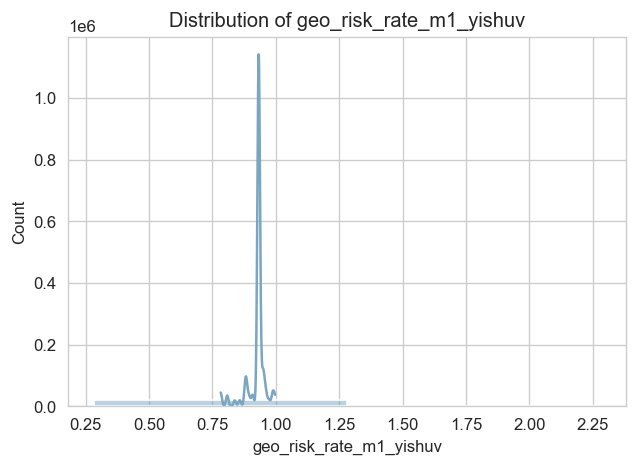

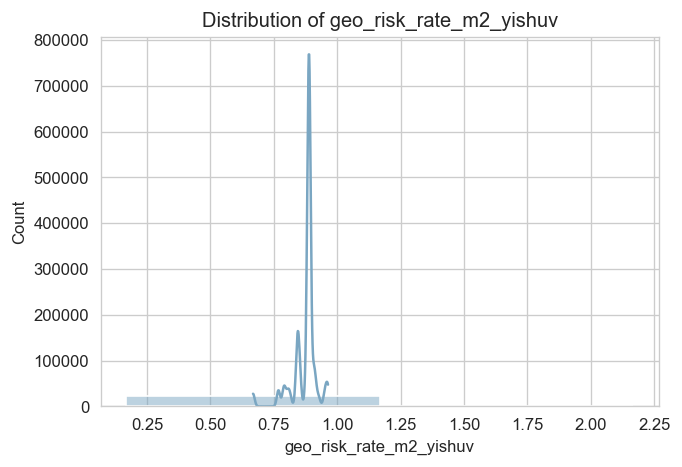

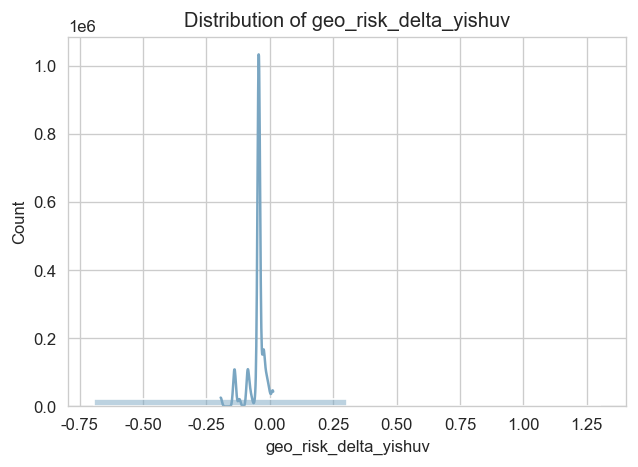

In [33]:
# === Step 1: Check distribution of geographic variables ===
import matplotlib.pyplot as plt
import seaborn as sns

geo_cols = ["geo_risk_rate_m1_yishuv", "geo_risk_rate_m2_yishuv", "geo_risk_delta_yishuv"]

for col in geo_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], bins=20, kde=True, color="#7aa6c2")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


In [34]:
# ===============================================================
# GEO variables — numeric coercion, %, robust terciles, delta groups
# Run once (before encodings/models). Idempotent and safe.
# Input : df_no_ids (must exist)
# Output: adds *_pct and *_group columns (keeps originals)
# Notes :
#   • For yishuv: keeps legacy group names: geo_risk_group_m1/m2, geo_risk_delta_group
#   • For machoz: creates *_machoz group names: geo_risk_group_m1_machoz/..., geo_risk_delta_group_machoz
#   • Coercing to numeric prevents accidental OHE on continuous GEO rates.
# ===============================================================
import pandas as pd
import numpy as np

assert 'df_no_ids' in globals(), "df_no_ids is missing. Make sure you created it earlier."

# Define GEO families we support
GEO_FAMILIES = [
    # (rate_m1, rate_m2, delta, scope, legacy_names_for_groups)
    ("geo_risk_rate_m1_yishuv",  "geo_risk_rate_m2_yishuv",  "geo_risk_delta_yishuv",  "yishuv",  True),
    ("geo_risk_rate_m1_machoz",  "geo_risk_rate_m2_machoz",  "geo_risk_delta_machoz",  "machoz",  False),
]

def robust_terciles(series_pct: pd.Series) -> pd.Categorical:
    """Quantile terciles with safe fallback for ties; labels Low/Medium/High."""
    s = series_pct.copy()
    qs = s.quantile([0, 1/3, 2/3, 1]).drop_duplicates()
    try:
        if len(qs) >= 3:
            bins = qs.to_numpy()
            bins[0]  -= 1e-6
            bins[-1] += 1e-6
            return pd.cut(s, bins=bins, labels=["Low","Medium","High"], include_lowest=True)
    except Exception:
        pass
    # Fallback: rank-based terciles (always works)
    return pd.qcut(s.rank(method="first"), q=3, labels=["Low","Medium","High"])

def ensure_pct(df: pd.DataFrame, in_col: str, out_col: str):
    if in_col in df.columns and out_col not in df.columns:
        df[out_col] = (df[in_col] * 100).round(2)

def ensure_group(df: pd.DataFrame, pct_col: str, out_col: str):
    if pct_col in df.columns and out_col not in df.columns:
        df[out_col] = robust_terciles(df[pct_col])

def vc_safe(df: pd.DataFrame, col: str):
    return df[col].value_counts(dropna=False) if col in df.columns else "N/A"

for rate_m1, rate_m2, delta, scope, use_legacy_names in GEO_FAMILIES:
    # Skip family if core columns don't exist
    have_any = any(c in df_no_ids.columns for c in (rate_m1, rate_m2, delta))
    if not have_any:
        continue

    # --- 0) Coerce to float and clip to plausible bounds ---
    for c in (rate_m1, rate_m2, delta):
        if c in df_no_ids.columns:
            before = str(df_no_ids[c].dtype)
            df_no_ids[c] = pd.to_numeric(df_no_ids[c], errors="coerce")
            after = str(df_no_ids[c].dtype)
            if before != after:
                print(f"🔧 {c}: {before} → {after}")

    if rate_m1 in df_no_ids.columns:
        df_no_ids[rate_m1] = df_no_ids[rate_m1].clip(0, 1)
    if rate_m2 in df_no_ids.columns:
        df_no_ids[rate_m2] = df_no_ids[rate_m2].clip(0, 1)
    if delta in df_no_ids.columns:
        df_no_ids[delta] = df_no_ids[delta].clip(-1, 1)

    # --- 1) Percent columns (create only if missing) ---
    pct_m1 = f"{rate_m1}_pct"
    pct_m2 = f"{rate_m2}_pct"
    pct_dl = f"{delta}_pct"

    ensure_pct(df_no_ids, rate_m1, pct_m1)
    ensure_pct(df_no_ids, rate_m2, pct_m2)
    ensure_pct(df_no_ids, delta,   pct_dl)

    # --- 2) Group columns (terciles for rates; ±2% for deltas) ---
    if use_legacy_names:
        # yishuv: keep legacy names (backward compatible)
        grp_m1 = "geo_risk_group_m1"
        grp_m2 = "geo_risk_group_m2"
        grp_dl = "geo_risk_delta_group"
    else:
        # machoz: explicit suffix
        grp_m1 = "geo_risk_group_m1_machoz"
        grp_m2 = "geo_risk_group_m2_machoz"
        grp_dl = "geo_risk_delta_group_machoz"

    ensure_group(df_no_ids, pct_m1, grp_m1)
    ensure_group(df_no_ids, pct_m2, grp_m2)

    if pct_dl in df_no_ids.columns and grp_dl not in df_no_ids.columns:
        df_no_ids[grp_dl] = pd.cut(
            df_no_ids[pct_dl],
            bins=[-100, -2, 2, 100],
            labels=["Improved", "Stable", "Deteriorated"],
            include_lowest=True
        )

    # --- 3) Quick sanity printout for this family ---
    print(f"\n== GEO ({scope}) — groups ==")
    print(f"{grp_m1}:\n{vc_safe(df_no_ids, grp_m1)}")
    print(f"\n{grp_m2}:\n{vc_safe(df_no_ids, grp_m2)}")
    print(f"\n{grp_dl}:\n{vc_safe(df_no_ids, grp_dl)}")

print("\n✅ GEO processing complete. Numeric coercion done, % and group columns ensured (idempotent).")


🔧 geo_risk_rate_m1_yishuv: category → float64

== GEO (yishuv) — groups ==
geo_risk_group_m1:
geo_risk_group_m1
Low       7327
Medium    7327
High      7327
Name: count, dtype: int64

geo_risk_group_m2:
N/A

geo_risk_delta_group:
N/A
🔧 geo_risk_rate_m1_machoz: category → float64

== GEO (machoz) — groups ==
geo_risk_group_m1_machoz:
geo_risk_group_m1_machoz
Low       10002
Medium     6902
High       5077
Name: count, dtype: int64

geo_risk_group_m2_machoz:
N/A

geo_risk_delta_group_machoz:
N/A

✅ GEO processing complete. Numeric coercion done, % and group columns ensured (idempotent).


After processing, the data showed that most children live in either low- or high-risk localities, with almost no middle category, and that between the two measurement waves the overall geographic risk slightly decreased—indicating general improvement across most localities.

In [35]:
# ===============================================================
# Apply decisions — cleaning, ordinals, exclusions (no GEO here)
# Idempotent; requires: df_no_ids; produces/updates: df_model
# Notes:
# • GEO (%/terciles/delta) handled in its own cell.
# • Keep only 'population_group_clean' and 'jewish_religiosity' variants for modeling.
# • Do NOT create any OHE here and do NOT touch program/locality engineered columns.
# ===============================================================
import pandas as pd, numpy as np, re
from pathlib import Path
pd.set_option('future.no_silent_downcasting', True)

assert 'df_no_ids' in globals(), "df_no_ids is missing."

ARTIFACTS_DIR = Path("artifacts"); ARTIFACTS_DIR.mkdir(exist_ok=True, parents=True)
changes_log = []
VERBOSE = False

def note(msg: str):
    changes_log.append(msg)
    if VERBOSE: print("•", msg)

# ----------------------------
# 1) Normalize selected fields
# ----------------------------
# desired_* — align unknowns
for col in ["desired_secondary_outcome", "desired_main_outcome"]:
    if col in df_no_ids.columns:
        df_no_ids[col] = (df_no_ids[col].astype("string").str.strip()
                          .replace({"0":"unknown", 0:"unknown", "לא צוין":"unknown"}))
        note(f"{col}: aligned 'unknown' variants")

# Ordinals: complexities 0..4
complexity_map = {
    "לא אותרו מצבי סיכון": 0,
    "סיכון נמוך (מניעה)": 1,
    "מורכבות נמוכה": 2,
    "מורכבות גבוהה": 3,
    "קצה רצף": 4
}
for col in ["parent_complexity_m2","complexity_m2","parent_complexity_m1","complexity_m1"]:
    if col in df_no_ids.columns:
        ser = (df_no_ids[col].astype("string").str.strip()
               .str.replace("מורכבות  נמוכה","מורכבות נמוכה", regex=False)
               .str.replace("מורכבות  גבוהה","מורכבות גבוהה", regex=False)
               .replace(complexity_map))
        df_no_ids[col] = pd.to_numeric(ser, errors="coerce").astype("Int64")
        note(f"{col}: mapped to ordinal Int64")

# economic_distress_m2 → 0..3
if "economic_distress_m2" in df_no_ids.columns:
    econ_map = {
        "לא קיימת מצוקה כלכלית": 0,
        "מצוקה זמנית (עקב משבר או מחלה)": 1,
        "מצוקה מתונה מתמשכת": 2,
        "מצוקה קשה ומתמשכת": 3,
        0:0,1:1,2:2,3:3
    }
    ser = df_no_ids["economic_distress_m2"].astype("string").str.strip().replace(econ_map)
    df_no_ids["economic_distress_m2"] = pd.to_numeric(ser, errors="coerce").astype("Int64")
    note("economic_distress_m2: mapped to 0..3 (Int64)")

# age_group_m1 → 1/2/3
if "age_group_m1" in df_no_ids.columns:
    age_map = {"0-6":1, "0–6":1, "7-11":2, "7–11":2, "12-18":3, "12–18":3}
    ser = df_no_ids["age_group_m1"].astype("string").str.strip().replace(age_map)
    df_no_ids["age_group_m1"] = pd.to_numeric(ser, errors="coerce").astype("Int64")
    note("age_group_m1: mapped to 1/2/3 (Int64)")

# intervention_length_group → 1..4
if "intervention_length_group" in df_no_ids.columns:
    map_intervention = {
        "עד חצי שנה": 1, "חצי שנה עד תשעה חודשים": 2, "תשעה חודשים עד שנה": 3, "מעל שנה": 4,
        "עד חצי-שנה": 1, "חצי-שנה עד תשעה-חודשים": 2, "תשעה-חודשים עד שנה": 3, "מעל-שנה": 4,
    }
    ser = df_no_ids["intervention_length_group"].astype("string").str.strip().replace(map_intervention)
    df_no_ids["intervention_length_group"] = pd.to_numeric(ser, errors="coerce").astype("Int64")
    note("intervention_length_group: mapped to 1..4 (Int64)")

# gap_bucket → 1..4
def _clean_bucket(s):
    if pd.isna(s): return s
    s = str(s).strip()
    s = re.sub(r"[–—−]", "-", s)
    s = re.sub(r"\s*-\s*", "-", s)
    return s.replace(" ", "")

if "gap_bucket" in df_no_ids.columns:
    ser = df_no_ids["gap_bucket"].astype("string").map(_clean_bucket)
    ser = ser.replace({"60-90":1, "91-180":2, "181-365":3, "366-465":4})
    df_no_ids["gap_bucket"] = pd.to_numeric(ser, errors="coerce").astype("Int64")
    note("gap_bucket: normalized to 1..4 (Int64)")

# Unify 'unknown' variants
for col in ["diagnosed_disability_type_m1","diagnosed_disability_type_m2",
            "parent_disability_type_m1","parent_disability_type_m2",
            "outputs_activity_duration","population_group_m1"]:
    if col in df_no_ids.columns:
        df_no_ids[col] = (df_no_ids[col].astype("string").str.strip()
                          .replace({"לא ידוע":"unknown","לא צוין":"unknown","כולם":"unknown"}))
        note(f"{col}: unified 'unknown' variants")

# -------------------------------------------------
# 2) Build df_model AFTER we know what to exclude
# -------------------------------------------------
# Base exclusions (kept in df_no_ids; dropped only from df_model)
exclude_from_model = [
    # Countries/regions & school level:
    "father_birth_country_m1","mother_birth_country_m1","child_birth_country_m1",
    "residence_neighborhood_m2","school_level_m2","school_level_m1",

    # Group variants we do NOT model directly (keep the CLEAN one later):
    "population_group_m1","is_arab","is_arabic_form_m1",

    # Leakage / post-info / technical:
    "n_star_flags_total",        # includes post period info (remove; keep n_star_flags_m1)
    "service_status_m1","service_status_m2",
    "form_year_m1","form_year_m2",
    "form_month_m1", "form_month_m2",
]

# Optional: if both exist, keep only the 'clean' variant of population group
# (df_model will still pass through a strong identifier-like drop later)
keep_whitelist = {"population_group_clean", "jewish_religiosity"}

# Create df_model from df_no_ids and drop exclusions
df_model = df_no_ids.drop(columns=[c for c in exclude_from_model if c in df_no_ids.columns], errors="ignore")

# Ensure we did not accidentally drop the whitelisted group variables
for k in keep_whitelist:
    if k in df_no_ids.columns and k not in df_model.columns:
        df_model[k] = df_no_ids[k]

# Final tidy: convert residual object→category for df_model only
obj_cols = df_model.select_dtypes(include="object").columns.tolist()
if obj_cols:
    df_model[obj_cols] = df_model[obj_cols].apply(lambda s: s.astype("category"))

print(f"✅ apply_decisions done. df_model shape: {df_model.shape}")
print("🧹 Excluded (present & dropped):",
      [c for c in exclude_from_model if c in df_no_ids.columns])
# Persist a brief log (silent)
log_path = ARTIFACTS_DIR / "apply_decisions_log.txt"
with open(log_path, "w", encoding="utf-8") as f:
    for line in changes_log:
        f.write(line + "\n")


✅ apply_decisions done. df_model shape: (21981, 252)
🧹 Excluded (present & dropped): ['father_birth_country_m1', 'mother_birth_country_m1', 'child_birth_country_m1', 'school_level_m1', 'population_group_m1', 'is_arab', 'is_arabic_form_m1', 'n_star_flags_total', 'service_status_m1', 'form_year_m1', 'form_month_m1']


I remove locality/program identifiers and technical/admin helpers from the multivariate votes table before final aggregation, because they can (1) leak administrative identities into model selection, (2) bias feature voting toward proxies of location/program rather than child/family attributes, and (3) inflate importance of non-causal keys. The cleaning targets both raw and one-hot encoded variants (e.g., cat__yeshuv_name_m1_, cat__program_name_m1_clean_, machoz_m1, organizational_unit, service_location_m1) and known technical helpers. I produce a concise before/after report and a removable-rows log for auditing.

In [36]:
# ===============================================================
# Strong identifier-like drop (base + engineered variants)
# Run AFTER decisions (GEO, ordinals) and BEFORE any FS/OHE
# ===============================================================
import re

ID_TOKENS = [
    # locality / region
    "yeshuv", "residence_locality_m1_clean", "residence_neighborhood_m1",
    "matched_name", "machoz_m1", "organizational_unit",
    # services/programs
    "service_location_m1", "service_name_m1", "service_name_m1_clean",
    "program_name", "program_name_m1", "program_name_m1_clean",
    # misc identifiers / ordering / coords
    "outputs_action_composition", "form_filler_role_m1", "_row_order_m1",
    "child_birth_region_m1", "latitude", "longitude"
]

# catch *_freq, *_top50, *_topk*, and any dummy produced after get_dummies/OHE
VARIANT_PAT = re.compile(
    r"(?:^|_)(yeshuv|matched_name|machoz_m1|organizational_unit|"
    r"service_location_m1|service_name_m1(?:_clean)?|program_name(?:_m1(?:_clean)?)?)"
    r"(?:_|$)"
    r"|(?:_freq$)|(?:_top50$)|(?:_topk(?:_|$))",
    flags=re.IGNORECASE
)

def is_identifier_like(col: str) -> bool:
    c = col.lower()
    if any(tok in c for tok in ID_TOKENS):
        return True
    if VARIANT_PAT.search(c):
        return True
    return False

to_drop = [c for c in df_model.columns if is_identifier_like(c)]
df_model = df_model.drop(columns=to_drop, errors="ignore")

print(f"[Pre-model] Dropped identifier-like (incl. variants): {len(to_drop)}")
if to_drop:
    print("  Examples:", ", ".join(to_drop[:12]))
assert not any(is_identifier_like(c) for c in df_model.columns), "Identifier-like features still present"
print("[OK] df_model is free of program/yeshuv/service identifiers.")


[Pre-model] Dropped identifier-like (incl. variants): 19
  Examples: form_filler_role_m1, yeshuv_name_m1, machoz_m1, service_name_m1, service_location_m1, program_name_m1, residence_neighborhood_m1, _row_order_m1, service_name_m1_clean, program_name_m1_clean, residence_locality_m1_clean, child_birth_region_m1
[OK] df_model is free of program/yeshuv/service identifiers.


In [37]:
# ===============================================================
# Validation — detailed before/after summary for df_model (EN)
# ===============================================================
import pandas as pd
from pathlib import Path
from collections import Counter

ART_DIR = Path("artifacts/change_logs"); ART_DIR.mkdir(parents=True, exist_ok=True)

def dtype_family_counts(dtypes: pd.Series) -> dict:
    fam = Counter()
    for dt in dtypes.astype(str).str.lower():
        if any(k in dt for k in ["int", "float"]): fam["numeric"] += 1
        elif "bool" in dt:                         fam["bool"] += 1
        elif "category" in dt:                     fam["category"] += 1
        elif "datetime" in dt:                     fam["datetime"] += 1
        elif "string" in dt:                       fam["string"] += 1
        else:                                      fam[dt] += 1
    return dict(fam)

# --- A) Frames to compare (full vs. model) ---
full_cols   = set(df_no_ids.columns)          # all columns after decisions (full frame)
model_cols  = set(df_model.columns)           # columns kept for modeling
removed_vs_full = sorted(full_cols - model_cols)
kept_for_model  = sorted(model_cols & full_cols)

# --- B) Geo columns created during decisions (percent + groups) ---
created_geo_cols = [
    c for c in df_no_ids.columns
    if c.endswith("_pct") or c in ["geo_risk_group_m1","geo_risk_group_m2","geo_risk_delta_group"]
]
created_geo_cols = [c for c in created_geo_cols if c in df_no_ids.columns]

# --- C) Shapes and dtype families (model) ---
shape_model  = df_model.shape
dtypes_model = df_model.dtypes
fam_model    = dtype_family_counts(dtypes_model)

# If a true "before" snapshot exists, compare dtype changes (optional)
if "df_src_before" in globals():
    common_cols = sorted(set(df_src_before.columns) & set(df_model.columns))
    dtype_changes = [
        (c, str(df_src_before[c].dtype), str(df_model[c].dtype))
        for c in common_cols
        if str(df_src_before[c].dtype) != str(df_model[c].dtype)
    ]
else:
    dtype_changes = []

# --- D) Missingness in model ---
missing_pct = (df_model.isna().mean() * 100).round(2)
missing_cols = missing_pct[missing_pct > 0].sort_values(ascending=False)

# --- E) Console summary (concise, English) ---
print("—"*88)
print(f"df_model shape (rows × cols): {shape_model[0]:,} × {shape_model[1]:,}")
print(f"Columns kept for model: {len(kept_for_model):,}")
print(f"Columns removed vs. full frame: {len(removed_vs_full):,}")
if removed_vs_full:
    tail = f"... [+{len(removed_vs_full)-10}]" if len(removed_vs_full) > 10 else ""
    print("  Examples removed:", ", ".join(removed_vs_full[:10]), tail)

print(f"\nGeo columns created (percent/groups): {len(created_geo_cols)}",
      ("→ " + ", ".join(created_geo_cols)) if created_geo_cols else "")

print("\nDtype families in df_model:", fam_model)
obj_cols = df_model.select_dtypes(include="object").columns.tolist()
print(f"Object columns in df_model: {len(obj_cols)}", ("→ " + ", ".join(obj_cols[:10])) if obj_cols else "")

print(f"\nColumns with missing values (>0%): {len(missing_cols)}")
if len(missing_cols):
    print("Top-10 missing (%):", missing_cols.head(10).to_dict())

if dtype_changes:
    print(f"\nDetected dtype changes vs. df_src_before: {len(dtype_changes)}")
    print("  Examples:", dtype_changes[:5])

print("—"*88)

# --- F) Persist helper reports (CSV + brief text summary) ---
pd.Series(sorted(kept_for_model), name="kept_for_model")\
  .to_frame().to_csv(ART_DIR/"kept_for_model.csv", index=False, encoding="utf-8-sig")
pd.Series(sorted(removed_vs_full), name="removed_vs_full")\
  .to_frame().to_csv(ART_DIR/"removed_vs_full.csv", index=False, encoding="utf-8-sig")
pd.DataFrame({"column": df_model.columns, "dtype": dtypes_model.astype(str)})\
  .to_csv(ART_DIR/"model_dtypes.csv", index=False, encoding="utf-8-sig")
if len(missing_cols):
    missing_cols.to_csv(ART_DIR/"model_missing_columns.csv", header=["missing_%"], encoding="utf-8-sig")
if dtype_changes:
    pd.DataFrame(dtype_changes, columns=["column","dtype_before","dtype_after"])\
      .to_csv(ART_DIR/"dtype_changes_vs_df_src_before.csv", index=False, encoding="utf-8-sig")

summary_path = ART_DIR/"validation_summary.txt"
with open(summary_path, "w", encoding="utf-8") as f:
    f.write(f"df_model shape: {shape_model[0]} × {shape_model[1]}\n")
    f.write(f"kept_for_model: {len(kept_for_model)}\n")
    f.write(f"removed_vs_full: {len(removed_vs_full)}\n")
    f.write(f"created_geo_cols: {len(created_geo_cols)} — {', '.join(created_geo_cols)}\n")
    f.write(f"dtype_families: {fam_model}\n")
    f.write(f"object_cols: {len(obj_cols)}\n")
    f.write(f"missing_cols_count: {len(missing_cols)}\n")
print(f"📝 Saved validation summary to: {summary_path}")


————————————————————————————————————————————————————————————————————————————————————————
df_model shape (rows × cols): 21,981 × 233
Columns kept for model: 233
Columns removed vs. full frame: 30
  Examples removed: _row_order_m1, child_birth_country_m1, child_birth_region_m1, father_birth_country_m1, form_filler_role_m1, form_month_m1, form_year_m1, is_arab, is_arabic_form_m1, latitude ... [+20]

Geo columns created (percent/groups): 3 → geo_risk_rate_m1_yishuv_pct, geo_risk_group_m1, geo_risk_rate_m1_machoz_pct

Dtype families in df_model: {'category': 20, 'numeric': 199, 'bool': 7, 'string': 5, 'datetime': 2}
Object columns in df_model: 0 

Columns with missing values (>0%): 0
————————————————————————————————————————————————————————————————————————————————————————
📝 Saved validation summary to: artifacts\change_logs\validation_summary.txt


In [38]:
# ===============================================================
# Save clean model frame for Feature Selection
# ===============================================================
import pandas as pd, json
from pathlib import Path

MODEL_DIR = Path("data/processed"); MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Convert any residual object→category (if any)
obj_cols = df_model.select_dtypes(include="object").columns.tolist()
if obj_cols:
    df_model[obj_cols] = df_model[obj_cols].apply(lambda s: s.astype("category"))

# Save final file with the exact expected name
model_name = "df_model_v01"
pkl_path = MODEL_DIR / f"{model_name}.pkl"
df_model.to_pickle(pkl_path)

print(f"✅ Saved model frame | shape: {df_model.shape} → {pkl_path}")


✅ Saved model frame | shape: (21981, 233) → data\processed\df_model_v01.pkl


## הקובץ מוכן לבחירת הפיצרים החשובים!

In [39]:
# ===============================================================
# Step 1 — Prepare data for Univariate Feature Selection (no disk read)
# ===============================================================
import pandas as pd

# Use the in-memory df_model produced in the previous cell
assert 'df_model' in globals(), "df_model is not defined. Run the previous cell first."
df = df_model.copy()

# --- Define target ---
TARGET = "target_binary_improved"  # change if needed
assert TARGET in df.columns, f"Missing target column: {TARGET}"

# --- Split X / y ---
X = df.drop(columns=[TARGET])
y = df[TARGET]

print(f"✅ Using in-memory df_model | shape: {df.shape}")
print(f"🎯 Target: {TARGET}")
print(f"📦 X shape: {X.shape} | y shape: {y.shape}")


✅ Using in-memory df_model | shape: (21981, 233)
🎯 Target: target_binary_improved
📦 X shape: (21981, 232) | y shape: (21981,)


בשלב זה אבדוק את התרומה של כל פיצ’ר בנפרד למשתנה המטרה באמצעות בחירה חד־משתנית (Univariate Feature Selection).
המטרה: לזהות אילו משתנים מציגים קשר סטטיסטי מובהק עם התוצאה, לפני שנעבור לבחינה רב־משתנית.

## Univariate Feature Selection

In [40]:
# תא 1 — Imports
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd


In [41]:
# תא A — דיאגנוסטיקה מהירה של טיפוסים
import pandas as pd
import numpy as np

TARGET = "target_binary_improved"  # עדכני אם צריך
y = df[TARGET]
X = df.drop(columns=[TARGET]).copy()

dtype_counts = X.dtypes.astype(str).value_counts()
print("📊 ספירת טיפוסים:\n", dtype_counts, "\n")

non_numeric = X.select_dtypes(include=["category", "object", "string"]).columns.tolist()
maybe_ok = X.select_dtypes(include=["bool"]).columns.tolist()  # בוליאני נחשב נומרי (0/1)
print(f"🔎 עמודות לא-נומריות שנמצאו: {len(non_numeric)}")
print(non_numeric[:25])  # הצצה עד 25


📊 ספירת טיפוסים:
 Int64             134
Int8               24
category           20
int64              20
Int16               8
bool                7
float64             6
string              5
Float32             5
datetime64[ns]      2
Float64             1
Name: count, dtype: int64 

🔎 עמודות לא-נומריות שנמצאו: 25
['form_version_m1', 'sex_m1', 'edu_framework_m1', 'child_living_arrangement_m1', 'orphan_status_m1', 'diagnosed_disability_type_m1', 'parents_marital_status_m1', 'father_employment_m1', 'mother_employment_m1', 'economic_distress_m1', 'father_education_m1', 'mother_education_m1', 'parent_disability_type_m1', 'population_group_clean', 'is_haredi', 'jewish_religiosity', 'father_birth_region_m1', 'mother_birth_region_m1', 'outputs_action_path', 'outputs_activity_frequency', 'outputs_activity_duration', 'desired_main_outcome', 'desired_secondary_outcome', 'geo_risk_group_m1', 'geo_risk_group_m1_machoz']


בדיקה ראשונית חשפה משתנים שנבעו מדליפת מידע כמו משתנים שקשורים למדידה השניה או משתנים שמתייחסים לפער בין המדידות- שינוי, שיפור או החמרה. אסיר אותם כדי למנוע דליפת מידע

In [42]:
# ===============================================================
# Cell 2 — Univariate FS base: leak filtering + snapshots + save
# (NO DISK READ — uses in-memory df_model)
# ===============================================================
from pathlib import Path
import pandas as pd
import numpy as np

# ---- Preconditions ----
assert 'df_model' in globals(), "df_model is not defined. Run the previous cell first."

# ---- Paths & names ----
OUT_DIR = Path("data/interim");                  OUT_DIR.mkdir(parents=True, exist_ok=True)
ART_DIR = Path("artifacts/feature_selection");   ART_DIR.mkdir(parents=True, exist_ok=True)
OUT_BASE = OUT_DIR / "df_univariate_base"
TARGET = "target_binary_improved"
assert TARGET in df_model.columns, f"Missing target column: {TARGET}"

# ---- Work copy (do not mutate df_model) ----
df = df_model.copy()

# ---- Snapshot BEFORE ----
snap_before = (
    pd.DataFrame({
        "column": df.columns,
        "dtype": df.dtypes.astype(str).values,
        "n_missing": [df[c].isna().sum() for c in df.columns]
    })
    .sort_values("column")
)
snap_before.to_csv(ART_DIR / "univariate_snap_before.csv", index=False, encoding="utf-8-sig")

# ---- Split target / features ----
y = df[TARGET]
X = df.drop(columns=[TARGET]).copy()

# ---- Leak filtering (tokens) — with explicit TARGET exclusion ----
TARGET = "target_binary_improved"  # already asserted earlier

leak_tokens = (
    "target_",   # labels (NOT the target column itself)
    "_m2",       # second measurement
    "_delta",    # deltas
    "_change",   # changes
    "improved", "worsened",
    "delta"
)

def is_leak(col: str) -> bool:
    s = str(col).lower()
    # Protect the exact target name; everything else matching the tokens is a leak
    return (col != TARGET) and any(tok in s for tok in leak_tokens)

removed_cols = [c for c in X.columns if is_leak(c)]
kept_cols    = [c for c in X.columns if not is_leak(c)]

# Preserve original column order and keep TARGET last
df_univariate = df[kept_cols + [TARGET]].copy()

# ---- Snapshot AFTER ----
snap_after = (
    pd.DataFrame({
        "column": df_univariate.columns,
        "dtype": df_univariate.dtypes.astype(str).values,
        "n_missing": [df_univariate[c].isna().sum() for c in df_univariate.columns]
    })
    .sort_values("column")
)
snap_after.to_csv(ART_DIR / "univariate_snap_after.csv", index=False, encoding="utf-8-sig")

# ---- Save work file (does NOT overwrite the source) ----
df_univariate.to_pickle(OUT_BASE.with_suffix(".pkl"))
df_univariate.to_csv(OUT_BASE.with_suffix(".csv"), index=False, encoding="utf-8-sig")

print(f"📦 BEFORE: {df.shape} | AFTER (leak-free): {df_univariate.shape}")
print(
    "➖ Removed leak cols:", len(removed_cols),
    "\n✅ Saved:\n  •", OUT_BASE.with_suffix(".pkl"),
    "\n  •", OUT_BASE.with_suffix(".csv"),
    "\n📝 Reports:\n  •", ART_DIR / "univariate_snap_before.csv",
    "\n  •", ART_DIR / "univariate_snap_after.csv",
    "\n  •", ART_DIR / "univariate_removed_cols.csv"
)

# Also persist the removed columns list
pd.Series(removed_cols, name="removed_cols").to_csv(
    ART_DIR / "univariate_removed_cols.csv", index=False, encoding="utf-8-sig"
)


📦 BEFORE: (21981, 233) | AFTER (leak-free): (21981, 233)
➖ Removed leak cols: 0 
✅ Saved:
  • data\interim\df_univariate_base.pkl 
  • data\interim\df_univariate_base.csv 
📝 Reports:
  • artifacts\feature_selection\univariate_snap_before.csv 
  • artifacts\feature_selection\univariate_snap_after.csv 
  • artifacts\feature_selection\univariate_removed_cols.csv


המרת משתנים קטגוריאלים עם 
One-Hot Encoding
ולאחר מכן בדיקה אילו פיצ'רים בודדים (חד־משתנית) מראים קשר חזק ומשמעותי עם משתנה המטרה באמצעות מבחן
ANOVA F-test.

In [43]:
# ===============================================================
# Cell 3 — Univariate F-values & p-values (robust CT + OHE)
# (NO DISK READ — uses in-memory df_univariate)
# ===============================================================
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_classif

ART_DIR = Path("artifacts/feature_selection"); ART_DIR.mkdir(parents=True, exist_ok=True)
TARGET  = "target_binary_improved"

# 1) Preconditions: use the in-memory leak-free base
assert 'df_univariate' in globals(), "df_univariate is not defined. Run Cell 2 first."
assert TARGET in df_univariate.columns, f"Missing target column: {TARGET}"

dfu = df_univariate.copy()
y   = dfu[TARGET].astype("float64")
X   = dfu.drop(columns=[TARGET]).copy()

# (Safety) — re-apply the same leak guard on X only (TARGET לא נבדק כאן)
leak_tokens = ("target_", "_m2", "_delta", "_change", "improved", "worsened", "delta")
def is_leak(col: str) -> bool:
    s = str(col).lower()
    return any(tok in s for tok in leak_tokens)

leak_cols = [c for c in X.columns if is_leak(c)]
if leak_cols:
    X = X.drop(columns=leak_cols)

# 2) Drop datetime columns
dt_cols = X.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns.tolist()
if dt_cols:
    X = X.drop(columns=dt_cols)

# 3) Split by dtypes
num_cols = X.select_dtypes(include=["number", "boolean"]).columns.tolist()
cat_cols = X.select_dtypes(include=["category", "object", "string"]).columns.tolist()

# 4) Robust pipelines
num_pipe = Pipeline(steps=[
    ("to_float64", FunctionTransformer(lambda df: df.astype("float64"))),
    ("imputer", SimpleImputer(strategy="mean")),
])
cat_pipe = Pipeline(steps=[
    ("to_string", FunctionTransformer(lambda df: df.astype("string"))),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=np.float64)),
])

ct = ColumnTransformer(
    transformers=[("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)],
    remainder="drop",
    verbose_feature_names_out=True
).set_output(transform="pandas")

# 5) Fit-transform to a pandas DataFrame (keeps feature names)
Xt_df = ct.fit_transform(X, y)

# Drop zero-variance dummies (safety)
zero_var_mask = (Xt_df.var(axis=0) == 0)
if zero_var_mask.any():
    Xt_df = Xt_df.loc[:, ~zero_var_mask]

feat_names = Xt_df.columns.to_numpy()

# 6) Sanity checks
assert Xt_df.isna().sum().sum() == 0, "Unexpected NaNs after imputations."
print(f"✅ Xt shape: {Xt_df.shape} | y: {y.shape} | numeric: {len(num_cols)} | categorical: {len(cat_cols)}")
print(f"   Removed (safety) leaks in Cell 3: {len(leak_cols)} | datetimes: {len(dt_cols)} | zero-var: {int(zero_var_mask.sum())}")

# 7) Compute F & p
f_values, p_values = f_classif(Xt_df.to_numpy(dtype=np.float64, copy=False), y.to_numpy())

feature_scores = (
    pd.DataFrame({"feature_after_ohe": feat_names, "F-Value": f_values, "P-Value": p_values})
      .replace([np.inf, -np.inf], np.nan)
      .dropna(subset=["F-Value"])
      .sort_values("F-Value", ascending=False)
      .reset_index(drop=True)
)

# 8) Save report
out_csv = ART_DIR / "univariate_feature_scores.csv"
feature_scores.to_csv(out_csv, index=False, encoding="utf-8-sig")
print(f"💾 Saved: {out_csv}")
display(feature_scores.head(20))


✅ Xt shape: (21981, 376) | y: (21981,) | numeric: 205 | categorical: 25
   Removed (safety) leaks in Cell 3: 0 | datetimes: 2 | zero-var: 7
💾 Saved: artifacts\feature_selection\univariate_feature_scores.csv


,feature_after_ohe,F-Value,P-Value
0,num__complexity_m1,3341.012014,0.000000e+00
1,num__complexity_m1_num,3341.012014,0.000000e+00
2,num__risk_total_m1,1120.335552,1.280077e-239
3,num__any_risk_m1,925.545234,3.665489e-199
4,num__n_risk_domains_m1,847.338362,8.064346e-183
5,num__risk_area5_social_level_m1,651.983098,9.624984e-142
6,num__risk_item_count_m1,649.338628,3.483237e-141
7,num__risk_item_high_count_m1,626.090385,2.854959e-136
8,num__risk_area2_family_level_m1,611.358861,3.731952e-133
9,num__risk_area6_emotional_level_m1,584.672595,1.669920e-127


C:\Users\zoars\AppData\Local\Temp\ipykernel_30192\2987064580.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


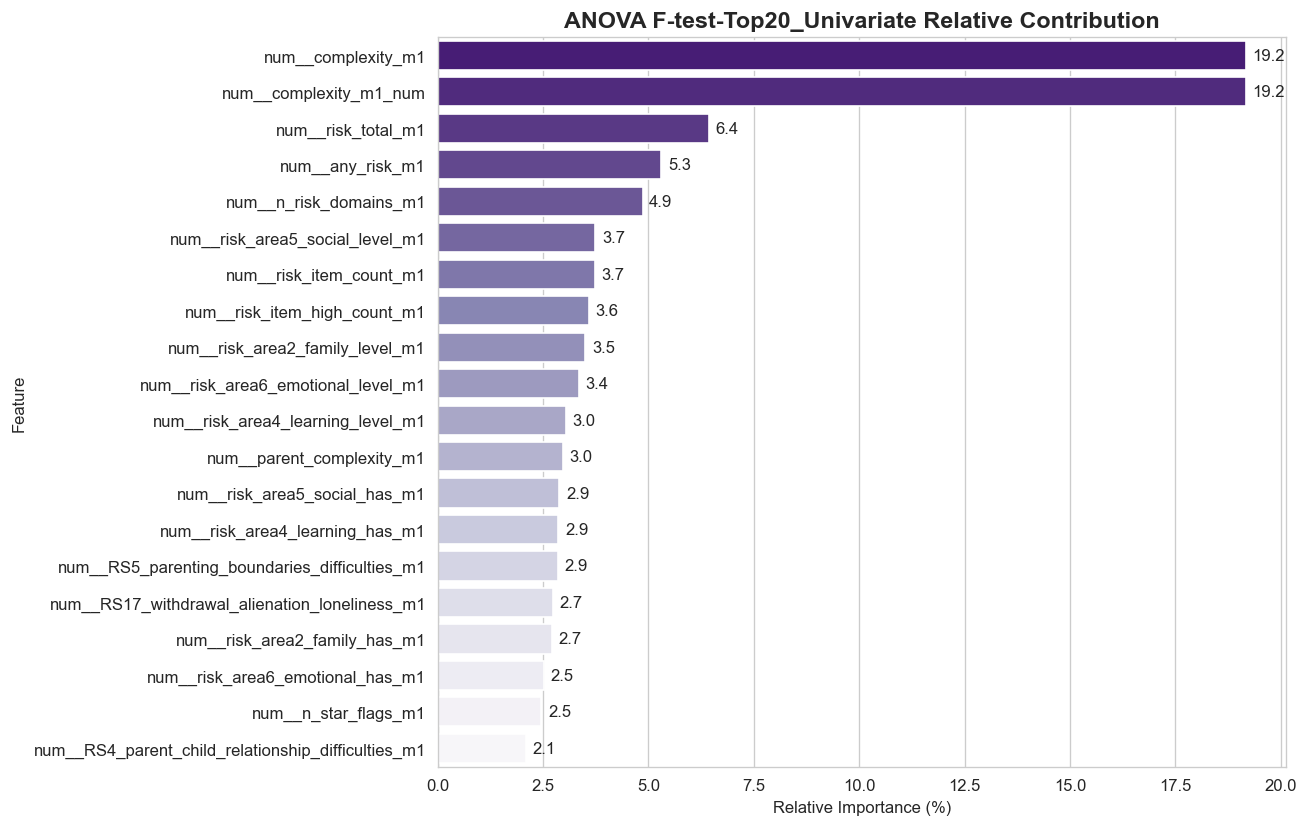

💾 נשמר גרף: artifacts\feature_selection\top20_univariate_purple_darkfirst.png


In [44]:
# תא 4 — גרף סגולים כהים לפיצ'רים החזקים ביותר
import matplotlib.pyplot as plt
import seaborn as sns
from bidi.algorithm import get_display
from pathlib import Path

ART_DIR = Path("artifacts/feature_selection"); ART_DIR.mkdir(parents=True, exist_ok=True)

K = 20
top_k = feature_scores.nlargest(K, "F-Value").copy()
top_k["% Contribution"] = (top_k["F-Value"] / top_k["F-Value"].sum()) * 100
top_k["% Contribution (1dp)"] = top_k["% Contribution"].round(1)
heb = lambda s: get_display(str(s))
top_k["label_heb"] = top_k["feature_after_ohe"].map(heb)

plt.figure(figsize=(11, 7))
sns.set_style("whitegrid")

# הופכים את הסדר כדי שהעמודה הראשונה תהיה הכהה ביותר
palette = list(reversed(sns.color_palette("Purples", n_colors=K)))

ax = sns.barplot(
    data=top_k,
    y="label_heb",
    x="% Contribution",
    palette=palette
)

ax.set_title("ANOVA F-test-Top20_Univariate Relative Contribution", fontsize=14, weight="bold")
ax.set_xlabel("Relative Importance (%)")
ax.set_ylabel("Feature")

# כיתוב הערכים בראש כל עמודה
for p, val in zip(ax.patches, top_k["% Contribution (1dp)"]):
    x = p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(f"{val:.1f}",
                (x, y),
                xytext=(4, 0),
                textcoords="offset points",
                va="center", ha="left", fontsize=10)

plt.tight_layout()
out_png = ART_DIR / "top20_univariate_purple_darkfirst.png"
plt.savefig(out_png, dpi=150)
plt.show()
print(f"💾 נשמר גרף: {out_png}")


 In the univariate analysis, I found that several general risk indicators — such as complexity, risk_total, and any_risk — showed very high contributions and may overlap. At this stage, I check their correlations to detect duplicate or redundant features and keep only one representative from each risk-feature family.

✅ Using in-memory df_model: (21981, 233)
🔎 Candidate risk columns: 49


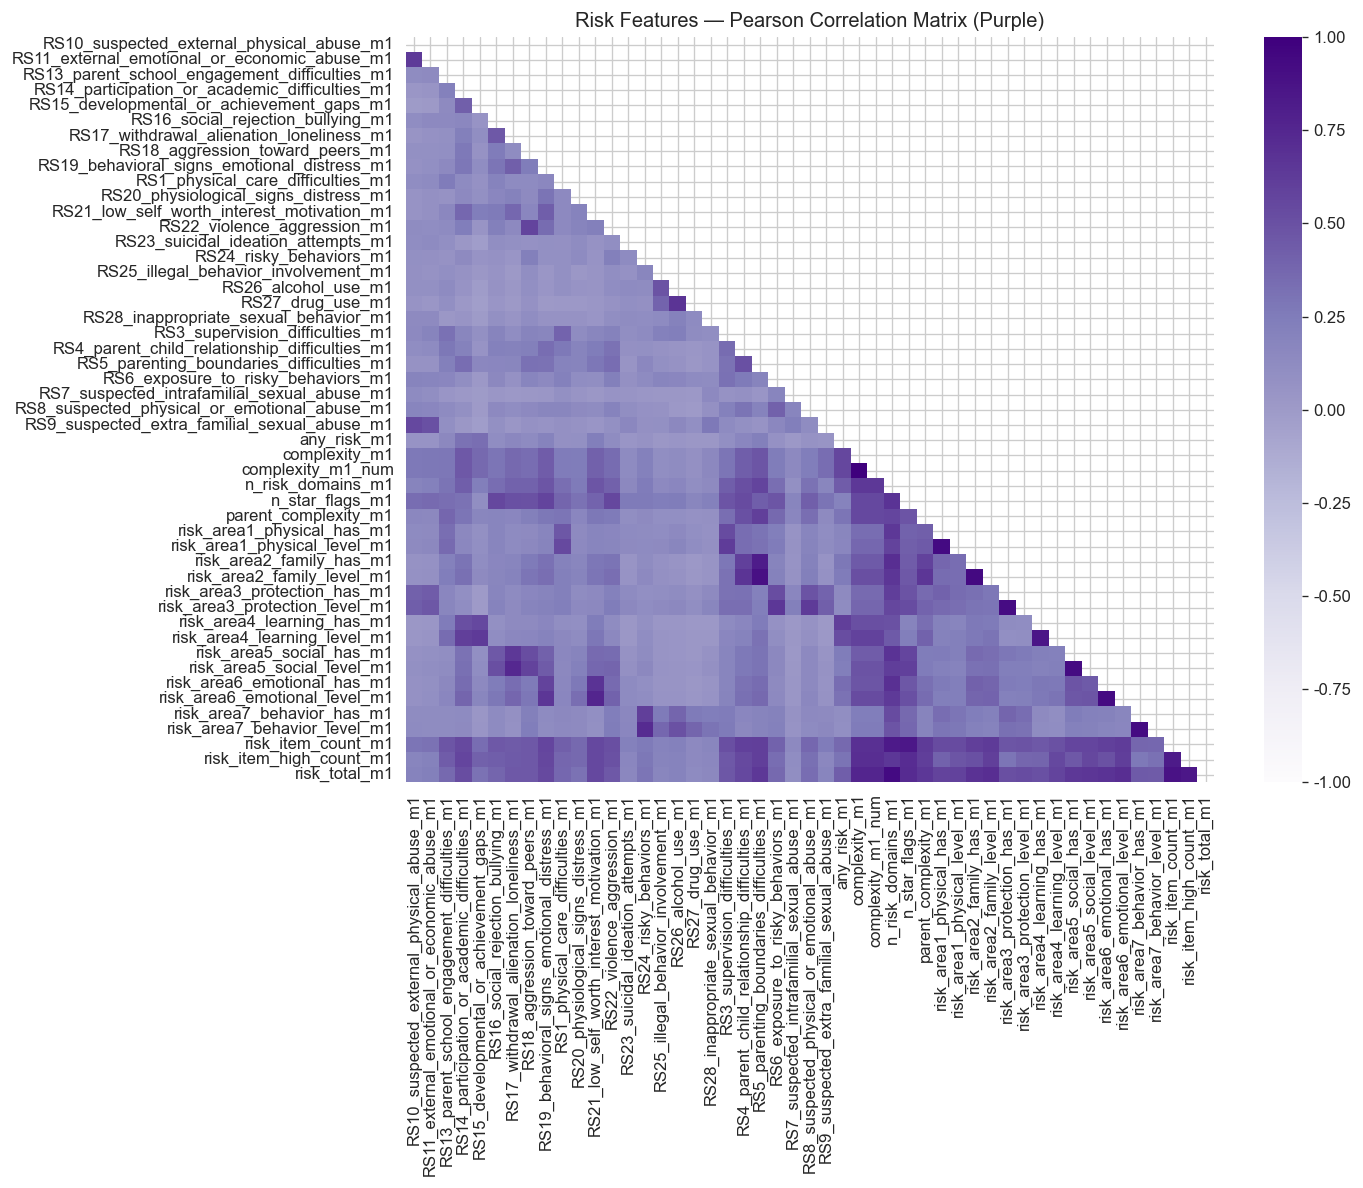

💾 Saved:
 • artifacts\feature_selection\risk_features_corr_heatmap_pearson_purple.png
 • artifacts\feature_selection\risk_features_high_corr_pairs_pearson_pos_06.csv


,feature_a,feature_b,pearson_r
0,complexity_m1,complexity_m1_num,1.000000
1,risk_area2_family_has_m1,risk_area2_family_level_m1,0.940082
2,n_risk_domains_m1,risk_total_m1,0.932767
3,risk_area1_physical_has_m1,risk_area1_physical_level_m1,0.930849
4,risk_area7_behavior_has_m1,risk_area7_behavior_level_m1,0.929526
5,risk_area5_social_has_m1,risk_area5_social_level_m1,0.925436
6,risk_area6_emotional_has_m1,risk_area6_emotional_level_m1,0.923325
7,risk_area3_protection_has_m1,risk_area3_protection_level_m1,0.915535
8,RS5_parenting_boundaries_difficulties_m1,risk_area2_family_level_m1,0.897709
9,risk_item_count_m1,risk_total_m1,0.881456


In [45]:
# ===============================================================
# Risk-feature correlation (Pearson) + Purple heatmap + pairs >= 0.60
# (NO DISK READ — uses in-memory df_model)
# ===============================================================
import re, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from pandas.api.types import is_numeric_dtype

ART_DIR = Path("artifacts/feature_selection"); ART_DIR.mkdir(parents=True, exist_ok=True)
POSITIVE_ONLY = True   # if False -> use absolute value threshold

# 1) Preconditions
assert 'df_model' in globals(), "df_model is not defined. Run the previous cell first."
print(f"✅ Using in-memory df_model: {df_model.shape}")

# 2) Collect risk-feature columns (same families as before)
PATTERNS = {
    "complexity":       r"(^|_)complexity_m1(_num)?$|^parent_complexity_m1$",
    "risk_total":       r"(^|_)risk_total_m1$",
    "any_risk":         r"(^|_)any_risk_m1$",
    "n_risk_domains":   r"(^|_)n_risk_domains_m1$",
    "n_star_flags":     r"(^|_)n_star_flags_m1$",
    "risk_items":       r"(^|_)risk_item(_high)?_count_m1$",
    "risk_area_levels": r"(^|_)risk_area\d+_.*_level_m1$",
    "risk_area_has":    r"(^|_)risk_area\d+_.*_has_m1$",
    "rs_items":         r"(^|_)RS\d+_.*_m1$",
}
def collect_cols(df: pd.DataFrame, regexes: dict) -> list:
    cols = set()
    for rx in regexes.values():
        r = re.compile(rx)
        cols |= {c for c in df.columns if r.search(c)}
    return sorted(cols)

cols = collect_cols(df_model, PATTERNS)
print(f"🔎 Candidate risk columns: {len(cols)}")

# 3) Coerce to numeric safely (nullable Int* -> float64)
num = df_model[cols].copy()
non_num = [c for c in num.columns if not is_numeric_dtype(num[c])]
if non_num:
    num[non_num] = num[non_num].apply(pd.to_numeric, errors="coerce")
nullable_ints = [c for c in num.columns if str(num[c].dtype).startswith("Int")]
if nullable_ints:
    num[nullable_ints] = num[nullable_ints].astype("float64")

# Optional: drop near-constant columns
def is_near_constant(s: pd.Series, thr=0.995) -> bool:
    vc = s.value_counts(normalize=True, dropna=True)
    return bool(len(vc) and vc.iloc[0] >= thr)
near_const = [c for c in num.columns if is_near_constant(num[c])]
if near_const:
    print(f"⚠️ Dropping near-constant columns ({len(near_const)}): {near_const[:8]}{' ...' if len(near_const)>8 else ''}")
    num = num.drop(columns=near_const)

# 4) Pearson correlation (pairwise complete)
corr = num.corr(method="pearson", min_periods=50)

# 5) Heatmap (Purples) with upper-triangle mask
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="Purples", vmin=-1, vmax=1, center=0, mask=mask, square=False)
plt.title("Risk Features — Pearson Correlation Matrix (Purple)")
plt.tight_layout()
heatmap_path = ART_DIR / "risk_features_corr_heatmap_pearson_purple.png"
plt.savefig(heatmap_path, dpi=180)
plt.show()

# 6) Pairs with correlation >= 0.60 (positive by default)
thr = 0.60
pairs = []
cols_valid = corr.columns.tolist()
for i, a in enumerate(cols_valid):
    for b in cols_valid[i+1:]:
        rho = corr.loc[a, b]
        if pd.notna(rho):
            score = abs(rho) if not POSITIVE_ONLY else rho
            if score >= thr:
                pairs.append((a, b, float(rho)))

pairs_df = (pd.DataFrame(pairs, columns=["feature_a","feature_b","pearson_r"])
            .sort_values("pearson_r", ascending=False)
            .reset_index(drop=True))

# 7) Save CSV and preview
pairs_csv = ART_DIR / ("risk_features_high_corr_pairs_pearson_"
                       + ("pos" if POSITIVE_ONLY else "abs")
                       + f"_{str(thr).replace('.','')}.csv")
pairs_df.to_csv(pairs_csv, index=False, encoding="utf-8-sig")
print(f"💾 Saved:\n • {heatmap_path}\n • {pairs_csv}")
display(pairs_df.head(30))


In the correlation analysis, I found that many risk-related features were highly correlated, especially between “has” and “level” versions of the same domain, as well as between several overall risk summary indicators. 

In [46]:
# ===============================================================
# Remove highly correlated duplicates (based on domain decisions)
# ===============================================================

import pandas as pd

# Updated list: keep complexity_m1_num, remove complexity_m1 instead
remove_high_corr = [
    "complexity_m1_num",                     # keep numeric version
    "risk_area2_family_has_m1",
    "n_risk_domains_m1",                 # keep risk_total_m1
    "risk_area1_physical_has_m1",
    "risk_area7_behavior_has_m1",
    "risk_area5_social_has_m1",
    "risk_area6_emotional_has_m1",
    "risk_area3_protection_has_m1",
    "risk_area4_learning_has_m1",
    "risk_item_count_m1",                # keep risk_total_m1, risk_item_high_count_m1
]

# Drop only existing columns
existing = [c for c in remove_high_corr if c in df_model.columns]
df_model.drop(columns=existing, inplace=True)


# Summary print
print("🧹 Removed highly correlated / redundant features:")
for c in existing:
    print(f"   • {c}")

print(f"\n✅ Remaining columns in df_model: {df_model.shape[1]} | Rows: {df_model.shape[0]}")


🧹 Removed highly correlated / redundant features:
   • complexity_m1_num
   • risk_area2_family_has_m1
   • n_risk_domains_m1
   • risk_area1_physical_has_m1
   • risk_area7_behavior_has_m1
   • risk_area5_social_has_m1
   • risk_area6_emotional_has_m1
   • risk_area3_protection_has_m1
   • risk_area4_learning_has_m1
   • risk_item_count_m1

✅ Remaining columns in df_model: 223 | Rows: 21981


In [47]:
# ===============================================================
# Save univariate base + full metadata snapshot
# ===============================================================
from pathlib import Path
import pandas as pd
from datetime import datetime

DATA_OUT = Path("data/interim/df_univariate_base.pkl")
ART_DIR = Path("artifacts/feature_selection"); ART_DIR.mkdir(parents=True, exist_ok=True)

assert "df_model" in globals(), "df_model is not defined."
TARGET = "target_binary_improved"
assert TARGET in df_model.columns, f"Missing target column: {TARGET}"

# --- Build a copy with target first ---
dfu = df_model.copy()
cols = [TARGET] + [c for c in dfu.columns if c != TARGET]
dfu = dfu[cols].reset_index(drop=True)

# --- Snapshot of dtypes and missing values ---
snap = pd.DataFrame({
    "column": dfu.columns,
    "dtype": dfu.dtypes.astype(str).values,
    "n_missing": [dfu[c].isna().sum() for c in dfu.columns],
    "pct_missing": [dfu[c].isna().mean() * 100 for c in dfu.columns],
})
snap_path = ART_DIR / "df_univariate_base_snapshot.csv"
snap.to_csv(snap_path, index=False, encoding="utf-8-sig")

# --- Optional: compare to last saved version to find removed columns ---
prev_meta = ART_DIR / "last_df_model_columns.txt"
if prev_meta.exists():
    old_cols = pd.read_csv(prev_meta, header=None)[0].tolist()
    removed = sorted(set(old_cols) - set(dfu.columns))
    added = sorted(set(dfu.columns) - set(old_cols))
else:
    removed, added = [], []

# --- Persist current columns for next diff ---
pd.Series(dfu.columns).to_csv(prev_meta, index=False, header=False, encoding="utf-8-sig")

# --- Save the pickle ---
dfu.to_pickle(DATA_OUT)

# --- Write meta info ---
meta_path = ART_DIR / "df_univariate_base_meta.txt"
with open(meta_path, "w", encoding="utf-8") as f:
    f.write(
        f"Saved df_univariate_base.pkl\n"
        f"Timestamp: {datetime.now():%Y-%m-%d %H:%M:%S}\n"
        f"Shape: {dfu.shape}\n"
        f"Target: {TARGET}\n"
        f"Removed columns: {len(removed)}\n"
        f"Added columns: {len(added)}\n"
        f"See snapshot: {snap_path.name}\n"
    )

print(f"💾 Saved df_univariate_base.pkl | shape: {dfu.shape}")
print(f"🧾 Snapshot: {snap_path}")
print(f"📝 Meta: {meta_path}")
if removed:
    print(f"❌ Removed vs previous: {len(removed)}")
if added:
    print(f"➕ Added vs previous: {len(added)}")


💾 Saved df_univariate_base.pkl | shape: (21981, 223)
🧾 Snapshot: artifacts\feature_selection\df_univariate_base_snapshot.csv
📝 Meta: artifacts\feature_selection\df_univariate_base_meta.txt


In [48]:
# ===============================================================
# Leak-safe Univariate (EXCLUDING target_binary_improved itself)
# ===============================================================
import re, numpy as np, pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_classif

TARGET = "target_binary_improved"
assert 'df_model' in globals(), "df_model is not defined."
assert TARGET in df_model.columns, f"Missing target column: {TARGET}"

dfu = df_model.copy()
y = dfu[TARGET].astype("float64")
X = dfu.drop(columns=[TARGET]).copy()

# --- Leak filtering by name (excluding the target itself) ---
LEAK_TOKENS = ("target_", "_m2", "_delta", "_change", "improved", "worsened", "delta")
def is_leak(name: str) -> bool:
    s = str(name).lower()
    return any(tok in s for tok in LEAK_TOKENS) and name != TARGET

leak_cols = [c for c in X.columns if is_leak(c)]
X = X.drop(columns=leak_cols, errors="ignore")

# --- Drop datetime & near-constant ---
dt_cols = X.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns.tolist()
X = X.drop(columns=dt_cols, errors="ignore")

def is_near_const(s: pd.Series, thr=0.999):
    vc = s.value_counts(normalize=True, dropna=True)
    return bool(len(vc) and vc.iloc[0] >= thr)
near_const = [c for c in X.columns if is_near_const(X[c])]
X = X.drop(columns=near_const, errors="ignore")

# --- Drop numeric proxies of target ---
num_cols_now = X.select_dtypes(include=["number", "boolean"]).columns.tolist()
strong_proxies = []
for c in num_cols_now:
    s = pd.to_numeric(X[c], errors="coerce")
    if s.std(skipna=True) == 0 or s.isna().any():
        continue
    rho = np.corrcoef(s, y)[0, 1]
    if abs(rho) >= 0.999:
        strong_proxies.append(c)
X = X.drop(columns=strong_proxies, errors="ignore")

# --- ColumnTransformer ---
num_cols = X.select_dtypes(include=["number", "boolean"]).columns.tolist()
cat_cols = X.select_dtypes(include=["category", "object", "string"]).columns.tolist()

num_pipe = Pipeline([
    ("to_float64", FunctionTransformer(lambda d: d.astype("float64"))),
    ("imputer", SimpleImputer(strategy="mean")),
])
cat_pipe = Pipeline([
    ("to_string", FunctionTransformer(lambda d: d.astype("string"))),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=np.float64)),
])

ct = ColumnTransformer(
    [("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)],
    remainder="drop",
    verbose_feature_names_out=True
).set_output(transform="pandas")

Xt_df = ct.fit_transform(X, y)
Xt_df = Xt_df.loc[:, Xt_df.var(axis=0) > 0]

# --- ANOVA ---
f_values, p_values = f_classif(Xt_df.to_numpy(dtype=np.float64, copy=False), y.to_numpy())
feature_scores = (
    pd.DataFrame({"feature_after_ohe": Xt_df.columns, "F-Value": f_values, "P-Value": p_values})
    .replace([np.inf, -np.inf], np.nan)
    .dropna(subset=["F-Value"])
    .sort_values("F-Value", ascending=False)
    .reset_index(drop=True)
)

# --- Summary ---
def preview(lst, n=8):
    return ", ".join(lst[:n]) + (" ..." if len(lst) > n else "") if lst else "(none)"

print("✅ Leak-safe Univariate ready (target protected)")
print(f"   Xt shape: {Xt_df.shape} | y: {y.shape}")
print("🔍 Removed before OHE:")
print(f"   • Leak columns:   {len(leak_cols)} | e.g., {preview(leak_cols)}")
print(f"   • Datetimes:      {len(dt_cols)} | e.g., {preview(dt_cols)}")
print(f"   • Near-constant:  {len(near_const)} | e.g., {preview(near_const)}")
print(f"   • Numeric proxies:{len(strong_proxies)} | e.g., {preview(strong_proxies)}")

display(feature_scores.head(10))


✅ Leak-safe Univariate ready (target protected)
   Xt shape: (21981, 366) | y: (21981,)
🔍 Removed before OHE:
   • Leak columns:   0 | e.g., (none)
   • Datetimes:      2 | e.g., form_dt_m1, form_day_m1
   • Near-constant:  7 | e.g., risk_area1_physical_measured_m1, risk_area2_family_measured_m1, risk_area3_protection_measured_m1, risk_area4_learning_measured_m1, risk_area5_social_measured_m1, risk_area6_emotional_measured_m1, risk_area7_behavior_measured_m1
   • Numeric proxies:0 | e.g., (none)


,feature_after_ohe,F-Value,P-Value
0,num__complexity_m1,3341.012014,0.000000e+00
1,num__risk_total_m1,1120.335552,1.280077e-239
2,num__any_risk_m1,925.545234,3.665489e-199
3,num__risk_area5_social_level_m1,651.983098,9.624984e-142
4,num__risk_item_high_count_m1,626.090385,2.854959e-136
5,num__risk_area2_family_level_m1,611.358861,3.731952e-133
6,num__risk_area6_emotional_level_m1,584.672595,1.669920e-127
7,num__risk_area4_learning_level_m1,529.201512,9.804994e-116
8,num__parent_complexity_m1,518.497489,1.845034e-113
9,num__RS5_parenting_boundaries_difficulties_m1,497.210148,6.208090e-109


C:\Users\zoars\AppData\Local\Temp\ipykernel_30192\1073101693.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


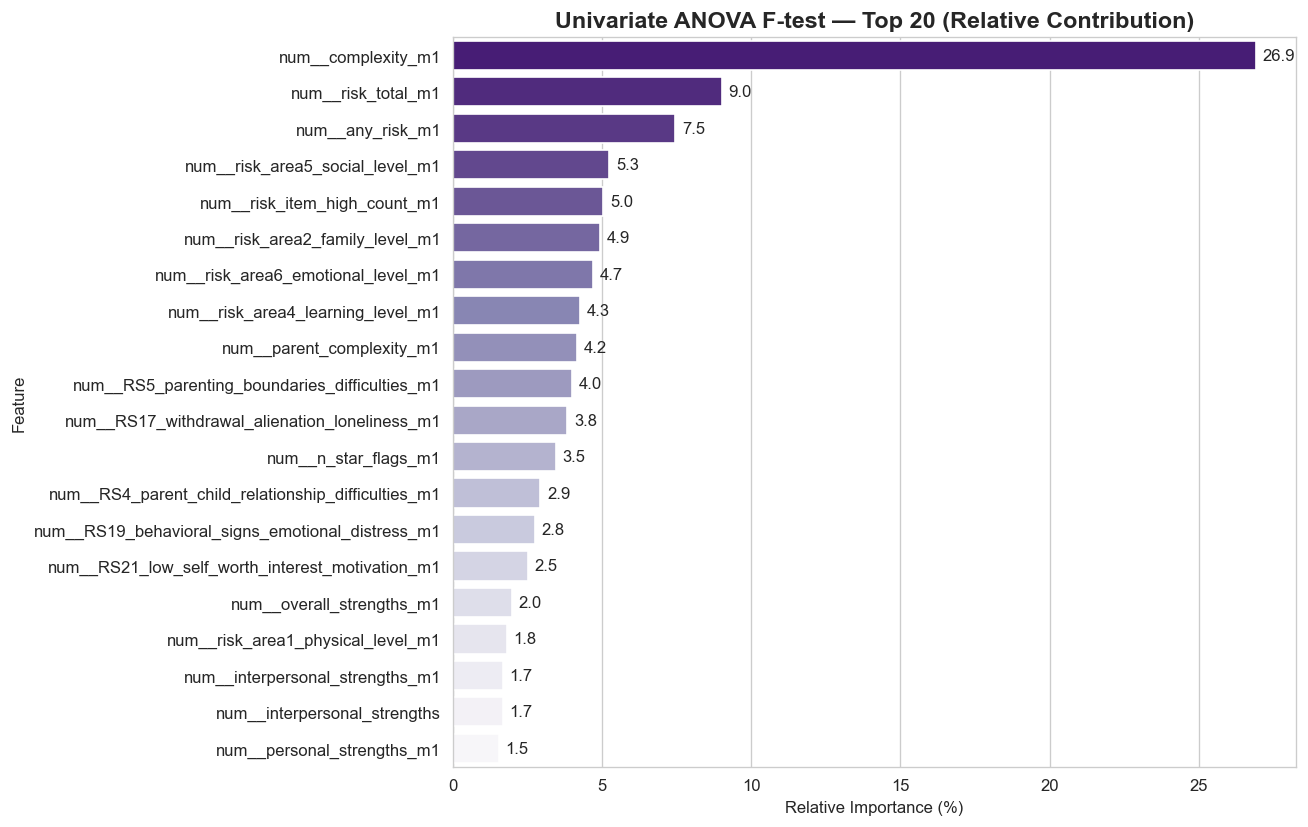

💾 Saved figure: artifacts\feature_selection\top20_univariate_purples.png


In [49]:
# ===============================================================
# Plot Top-20 Univariate Features (dark Purples) + save
# ===============================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

ART_DIR = Path("artifacts/feature_selection"); ART_DIR.mkdir(parents=True, exist_ok=True)

# Preconditions
assert 'feature_scores' in globals(), "feature_scores is not defined. Run the univariate ANOVA cell first."
assert {"feature_after_ohe", "F-Value"}.issubset(feature_scores.columns), "feature_scores must have required columns."

# Prepare Top-K table
K = 20
top_k = feature_scores.nlargest(min(K, len(feature_scores)), "F-Value").copy()
top_k["% Contribution"] = (top_k["F-Value"] / top_k["F-Value"].sum()) * 100
top_k["% Contribution (1dp)"] = top_k["% Contribution"].round(1)

# Plot
plt.figure(figsize=(11, 7))
sns.set_style("whitegrid")

# Darkest bar at the top: reverse palette order
palette = list(reversed(sns.color_palette("Purples", n_colors=len(top_k))))

ax = sns.barplot(
    data=top_k,
    y="feature_after_ohe",
    x="% Contribution",
    palette=palette
)

ax.set_title("Univariate ANOVA F-test — Top 20 (Relative Contribution)", fontsize=14, weight="bold")
ax.set_xlabel("Relative Importance (%)")
ax.set_ylabel("Feature")

# Annotate values on bars
for p, val in zip(ax.patches, top_k["% Contribution (1dp)"]):
    x = p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(f"{val:.1f}", (x, y), xytext=(4, 0),
                textcoords="offset points", va="center", ha="left", fontsize=10)

plt.tight_layout()
out_png = ART_DIR / "top20_univariate_purples.png"
plt.savefig(out_png, dpi=160)
plt.show()
print(f"💾 Saved figure: {out_png}")


The strongest predictors of improvement are initial complexity and total risk levels,

## Multivariate Feature Selection

In [50]:
# יבוא ספריות למודלים עם ענישה

from pathlib import Path
import numpy as np, pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier


In [51]:
# ===============================================================
# Clean, encode, and standardize features (robust to Int64/NA)
# ===============================================================

TARGET = "target_binary_improved"

# 1) Load the leak-free base you saved
y = dfu[TARGET].astype("int64")   # binary target 0/1
X = dfu.drop(columns=[TARGET]).copy()

# 2) Drop datetimes (not model-friendly as-is)
dt_cols = X.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns.tolist()
if dt_cols:
    X = X.drop(columns=dt_cols)

# 3) Split by dtypes
cat_cols = X.select_dtypes(include=["category", "object", "string"]).columns.tolist()
num_cols = X.select_dtypes(include=["number", "boolean", "Int64", "Float64"]).columns.tolist()

# 4) Robust pipelines
num_pipe = Pipeline(steps=[
    ("to_float64", FunctionTransformer(lambda d: d.astype("float64"))),  # kill pandas.NA dtype
    ("imputer", SimpleImputer(strategy="mean")),
])
cat_pipe = Pipeline(steps=[
    ("to_string", FunctionTransformer(lambda d: d.astype("string"))),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=np.float64)),
])

ct = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=True
).set_output(transform="pandas")  # ensure pandas DF; avoids pandas.NA→numpy issues

# 5) Fit-transform
Xt_df = ct.fit_transform(X, y)                      # pandas DataFrame (float64)
feat_names = Xt_df.columns.to_numpy()

# 6) Standardize (optional; with_mean=False keeps it safe for large / sparse-like)
scaler = StandardScaler(with_mean=False)
Xt_std = scaler.fit_transform(Xt_df.to_numpy(dtype=np.float64, copy=False))

print(f"✅ Xt_df shape: {Xt_df.shape} | Xt_std shape: {Xt_std.shape} | y: {y.shape}")
print(f"   numeric: {len(num_cols)} | categorical: {len(cat_cols)} | dropped datetimes: {len(dt_cols)}")

✅ Xt_df shape: (21981, 373) | Xt_std shape: (21981, 373) | y: (21981,)
   numeric: 195 | categorical: 25 | dropped datetimes: 2


In [52]:
# ===============================================================
# Train models + vote important features (strict, robust, sparse-friendly)
# ===============================================================
import time, numpy as np, pandas as pd
from pathlib import Path
from scipy import sparse
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import re

# Preconditions
assert 'Xt_df' in globals() and 'Xt_std' in globals() and 'y' in globals(), "Missing Xt_df / Xt_std / y"

# Strict sanity: matrices must match exactly (no silent truncation)
assert Xt_std.shape[1] == Xt_df.shape[1], f"Xt_std({Xt_std.shape[1]}) != Xt_df({Xt_df.shape[1]}) — rebuild from same preprocessor."

# Use the same matrix for both model families
X_lin  = Xt_std
X_tree = Xt_std.toarray() if sparse.issparse(Xt_std) else np.asarray(Xt_std)

# Feature names from the SAME source
feat_names = np.array(Xt_df.columns, dtype=object)

# --- Drop near-constant features consistently (helps convergence) ---
var = X_tree.var(axis=0)
keep = var > 1e-12
if not keep.all():
    dropped = int((~keep).sum())
    X_lin  = X_lin[:,  keep]
    X_tree = X_tree[:, keep]
    feat_names = feat_names[keep]
    print(f"[Info] Dropped near-constant features: {dropped} | Kept: {keep.sum()}")

# Final sanity
n_features = X_lin.shape[1]
assert len(feat_names) == n_features, "feat_names length must match X columns (post-filter)"

timings = {}

# ---- Linear models (on standardized) ----
t0 = time.perf_counter()
lasso = Lasso(alpha=0.02, max_iter=8000, random_state=0).fit(X_lin, y)
timings["Lasso_L1"] = time.perf_counter() - t0

t0 = time.perf_counter()
ridge = Ridge(alpha=0.02, random_state=0).fit(X_lin, y)
timings["Ridge_L2"] = time.perf_counter() - t0

lasso_selected = (np.abs(lasso.coef_) > 0).astype(int)
ridge_selected = (np.abs(ridge.coef_) > 0).astype(int)

# ---- Logistic (saga; robust for L1/L2; increase max_iter) ----
t0 = time.perf_counter()
log_l1 = LogisticRegression(
    penalty="l1", solver="saga", C=1.0, max_iter=12000, tol=1e-3,
    random_state=0, n_jobs=-1
    # , class_weight="balanced"  # uncomment if your classes are highly imbalanced
).fit(X_lin, y)
timings["LogReg_L1"] = time.perf_counter() - t0

t0 = time.perf_counter()
log_l2 = LogisticRegression(
    penalty="l2", solver="saga", C=1.0, max_iter=12000, tol=1e-3,
    random_state=0, n_jobs=-1
    # , class_weight="balanced"
).fit(X_lin, y)
timings["LogReg_L2"] = time.perf_counter() - t0

log_l1_sel = (np.abs(log_l1.coef_).ravel() > 0).astype(int)
log_l2_sel = (np.abs(log_l2.coef_).ravel() > 0).astype(int)

# ---- Tree models (fit on dense numeric) ----
t0 = time.perf_counter()
gb = GradientBoostingClassifier(
    n_estimators=120, max_depth=3, subsample=0.7, random_state=0,
    validation_fraction=0.1, n_iter_no_change=5
).fit(X_tree, y)
timings["GradientBoosting"] = time.perf_counter() - t0

t0 = time.perf_counter()
rf = RandomForestClassifier(
    n_estimators=200, max_depth=None, random_state=0, n_jobs=-1
).fit(X_tree, y)
timings["RandomForest"] = time.perf_counter() - t0

gb_selected = (gb.feature_importances_ > 0).astype(int)
rf_selected = (rf.feature_importances_ > 0).astype(int)

# ---- Voting table ----
selection_df = pd.DataFrame({
    "Feature": feat_names,
    "Lasso_L1": lasso_selected,
    "Ridge_L2": ridge_selected,
    "LogReg_L1": log_l1_sel,
    "LogReg_L2": log_l2_sel,
    "LinearSVC_L1": np.zeros_like(rf_selected),  # no SVC in this pass
    "GradientBoosting": gb_selected,
    "RandomForest": rf_selected
})
selection_df["sum_votes"] = selection_df.drop(columns=["Feature"]).sum(axis=1)

# ---- Safety: ensure no identifier-like patterns in feature names ----
bad_pat = re.compile(
    r"(?:yeshuv_name_m1|matched_name|machoz_m1|organizational_unit|"
    r"program_name_m1|service_name_m1|service_location_m1|latitude|longitude)",
    re.IGNORECASE
)
_bad = selection_df['Feature'].astype(str).str.contains(bad_pat, na=False)
assert not _bad.any(), f"Identifier-like features found in votes: {selection_df.loc[_bad, 'Feature'].head(10).tolist()}"

# ---- Save & report ----
out_dir = Path("artifacts/feature_selection"); out_dir.mkdir(parents=True, exist_ok=True)
csv_path = out_dir / "multivariate_votes_per_feature.csv"
selection_df.sort_values("sum_votes", ascending=False).to_csv(csv_path, index=False, encoding="utf-8-sig")

print("\n⌛ Runtimes (sec):")
for k, v in timings.items():
    print(f"{k:<18} {v:7.2f}")
print(f"\n💾 Saved: {csv_path}")
display(selection_df.sort_values("sum_votes", ascending=False).head(20))


[Info] Dropped near-constant features: 7 | Kept: 366

⌛ Runtimes (sec):
Lasso_L1              1.47
Ridge_L2              0.10
LogReg_L1            23.61
LogReg_L2            16.30
GradientBoosting     18.66
RandomForest          2.31

💾 Saved: artifacts\feature_selection\multivariate_votes_per_feature.csv


,Feature,Lasso_L1,Ridge_L2,LogReg_L1,LogReg_L2,LinearSVC_L1,GradientBoosting,RandomForest,sum_votes
365,cat__geo_risk_group_m1_machoz_Medium,1,1,1,1,0,1,1,6
3,num__diagnosed_disability_flag_m1,1,1,1,1,0,1,1,6
4,num__undiagnosed_disability_flag_m1,1,1,1,1,0,1,1,6
364,cat__geo_risk_group_m1_machoz_Low,1,1,1,1,0,1,1,6
9,num__parent_addictions_flag_m1,1,1,1,1,0,1,1,6
83,num__ri15_2_achievement_below_grade_m1,1,1,1,1,0,1,1,6
66,num__RS14_participation_or_academic_difficulti...,1,1,1,1,0,1,1,6
354,cat__desired_secondary_outcome_רווחה ובריאות ר...,1,1,1,1,0,1,1,6
221,cat__parents_marital_status_m1_נשואים,1,1,1,1,0,1,1,6
233,cat__father_education_m1_לא ידוע,1,1,1,1,0,1,1,6


In [53]:
# ===============================================================
# Aggregate votes by original feature (in-memory flow, no reloads)
# Expects an in-memory DataFrame with columns: ['Feature','sum_votes']
# Will look for: selection_df / votes / df_votes / df
# Saves outputs under artifacts/feature_selection
# ===============================================================
import pandas as pd, re
from pathlib import Path

# Use existing artifacts path or define it (no data loading)
ART = ART if 'ART' in globals() else Path("artifacts/feature_selection")
ART.mkdir(parents=True, exist_ok=True)

OUT_AGG  = ART / "votes_by_orig_feature.csv"
OUT_TOPK = ART / "votes_top40_preview.csv"
OUT_LIST = ART / "final_features_votes_ge_4.csv"

THRESH = 4
TOP_K  = 40

# Locate the in-memory votes DataFrame (no file I/O)
df_votes = None
for name in ("selection_df", "votes", "df_votes", "df"):
    if name in globals() and isinstance(globals()[name], pd.DataFrame):
        df_votes = globals()[name]
        src_name = name
        break
assert df_votes is not None, "Votes DataFrame not found in memory (looked for: selection_df/votes/df_votes/df)."
assert {"Feature","sum_votes"}.issubset(df_votes.columns), "Votes DataFrame must include 'Feature' and 'sum_votes'."

df_work = df_votes.copy()

# Map encoded/OHE names back to original base names
def to_orig(feat: str) -> str:
    s = str(feat)
    for pref in ("ohe__", "cat__", "num__", "bin__", "ord__", "hash__"):
        if s.startswith(pref):
            s = s.split("__", 1)[1]
            break
    bases = (
        "yeshuv_name_m1", "program_name_m1_clean", "program_name_m1",
        "program_name_top", "service_location_m1", "organizational_unit",
        "machoz_m1", "matched_name"
    )
    if "_" in s and any(s.startswith(b) for b in bases):
        s = s.rsplit("_", 1)[0]
    return s

df_work["orig_feature"] = df_work["Feature"].astype(str).map(to_orig)

# Safety: filter identifier-like families if any slipped through
bad_pat = re.compile(
    r"(?:yeshuv_name_m1|matched_name|machoz_m1|organizational_unit|"
    r"program_name_m1|service_name_m1|service_location_m1|latitude|longitude)",
    re.IGNORECASE
)
n_bad = int(df_work["Feature"].astype(str).str.contains(bad_pat, na=False).sum())
if n_bad > 0:
    df_work = df_work.loc[~df_work["Feature"].astype(str).str.contains(bad_pat, na=False)].copy()
    print(f"ℹ️ Filtered out {n_bad} identifier-like encoded features from votes.")

# Aggregate by original feature and select
agg = (df_work.groupby("orig_feature", as_index=False)["sum_votes"]
               .sum()
               .sort_values("sum_votes", ascending=False))
selected_all = agg.loc[agg["sum_votes"] >= THRESH, "orig_feature"].tolist()
topk = agg.head(TOP_K).copy()

# Save outputs
agg.to_csv(OUT_AGG,  index=False, encoding="utf-8-sig")
topk.to_csv(OUT_TOPK, index=False, encoding="utf-8-sig")
pd.Series(selected_all, name="final_features").to_csv(OUT_LIST, index=False, encoding="utf-8-sig")

print(f"[OK] In-memory source: {src_name}  | rows: {len(df_work)}")
print(f"🏁 Total features meeting threshold (sum_votes ≥ {THRESH}): {len(selected_all)}")
print(f"👀 Showing top {TOP_K} (preview saved):")
display(topk)

print("\n💾 Saved:")
print(f"• Full aggregation: {OUT_AGG}")
print(f"• Top {TOP_K} preview: {OUT_TOPK}")
print(f"• Final selected list (≥ {THRESH}): {OUT_LIST}")


[OK] In-memory source: selection_df  | rows: 366
🏁 Total features meeting threshold (sum_votes ≥ 4): 361
👀 Showing top 40 (preview saved):


,orig_feature,sum_votes
3,RS14_participation_or_academic_difficulties_m1,6
31,child_age_start,6
9,RS1_physical_care_difficulties_m1,6
39,complexity_m1,6
90,desired_secondary_outcome_רווחה ובריאות רגשית ...,6
96,diagnosed_disability_flag_m1,6
86,"desired_secondary_outcome_קיום פיזי, בריאות וא...",6
364,undiagnosed_disability_flag_m1,6
195,outputs_action_path_בניית תכנית אישית,6
247,ri15_2_achievement_below_grade_m1,6



💾 Saved:
• Full aggregation: artifacts\feature_selection\votes_by_orig_feature.csv
• Top 40 preview: artifacts\feature_selection\votes_top40_preview.csv
• Final selected list (≥ 4): artifacts\feature_selection\final_features_votes_ge_4.csv


## Feature Name Standardization – Converting Hebrew Feature Names to English

At this stage, I convert the names of the selected model variables (the final 40 features) into clean, consistent English names.
This step ensures smooth model execution, better readability in visualizations and reports, and consistent naming across all outputs.

In [54]:
# ===============================================================
# Hebrew inspection: only TOP 40 selected features
# Shows unique values & value_counts for each
# ===============================================================
import pandas as pd

# Load the top 40 encoded feature names
top40 = pd.read_csv("artifacts/feature_selection/final_top40_encoded_votes.csv")
features_40 = top40["Feature"].astype(str).tolist()

# Filter Xt_df to these features only
X40 = Xt_df[features_40].copy()

print(f"✅ Focused on {len(features_40)} selected features.")
print(f"Shape: {X40.shape}")
print("="*80)

# Scan through each of the 40 features
for col in X40.columns:
    print(f"\n🔹 Feature: {col}")
    vals = X40[col].dropna().unique()
    print(f"Unique values: {vals[:10]} ...")  # show only first 10
    print(X40[col].value_counts(dropna=False).head())


✅ Focused on 40 selected features.
Shape: (21981, 40)

🔹 Feature: cat__population_group_clean_ערבי
Unique values: [0. 1.] ...
cat__population_group_clean_ערבי
0.0    13845
1.0     8136
Name: count, dtype: int64

🔹 Feature: num__RS1_physical_care_difficulties_m1
Unique values: [0. 2. 1.] ...
num__RS1_physical_care_difficulties_m1
0.0    20070
2.0     1016
1.0      895
Name: count, dtype: int64

🔹 Feature: cat__desired_secondary_outcome_קיום פיזי, בריאות ואפשרות להתפתחות – הגברת איכות הטיפול בצרכים הפיזיים היומיומיים והבריאותיים של ילדים בכלל זה: טיפול פיזי לא מתאים בילדים נערים, השגחה לא מתאימה|רווחה ובריאות רגשית – הפחתת המצוקה הרגשית של הילד. בכלל זה: תגובות רגשיות מוגזמות, התנהגות חריגה בעקבות קושי רגיש (הרטבה וכו'), מביעים חוסר אמונה בעצמם|השתייכות והשתלבות חברתית – הגברת ההשתלבות החברתית של הילד והפחתת תחושת ניכור ובדידות. בכלל זה: קושי ביצירת קשר עם אחרים, קושי בהסתגלות והשתלבות במסגרת, הפגנת התנהגות תוקפנית
Unique values: [0. 1.] ...
cat__desired_secondary_outcome_קיום פיזי, בריא

In [55]:
# ===============================================================
# CELL 1 — Standardize Top-40 feature names (Hebrew → English)
# - Applies BOTH generic Hebrew phrase replacements AND
#   desired_*_outcome_* compression into codes (EMO/FAM/…)
# - Input: Xt_df (OHE), artifacts/feature_selection/final_top40_encoded_votes.csv
# - Output:
#   • Xt_df (Top-40 columns renamed in-memory)
#   • artifacts/feature_selection/final_top40_encoded_votes_en.csv
#   • artifacts/feature_selection/top40_encoded_he_to_en_map.csv
#   • artifacts/feature_selection/top40_present_original.csv
#   • artifacts/feature_selection/top40_present_english.csv
# Console: English only
# ===============================================================
import re
import pandas as pd
from pathlib import Path

ART = Path("artifacts/feature_selection"); ART.mkdir(parents=True, exist_ok=True)

# --- Load Top-40 encoded features table ---
top40_path = ART / "final_top40_encoded_votes.csv"
assert top40_path.exists(), f"Missing: {top40_path}"
top40 = pd.read_csv(top40_path)
assert "Feature" in top40.columns and "sum_votes" in top40.columns, "Top-40 file must include Feature,sum_votes."
features_40 = top40["Feature"].astype(str).tolist()

# --- Helpers ---
def slug_ascii(s: str) -> str:
    s = re.sub(r"[^A-Za-z0-9]+", "_", str(s))
    s = re.sub(r"_+", "_", s).strip("_")
    return s

# Generic Hebrew → concise English fragments (non-outcome)
PHRASE_MAP = {
    "ערבי": "arab",
    "יהודי דתי": "religious_jewish",
    "נשואים": "married",
    "לא ידוע": "unknown",
    "בניית תכנית אישית": "individual_plan",
    "למעלה  מ12 שנות לימוד": "gt_12y_schooling",
    "למעלה מ12 שנות לימוד": "gt_12y_schooling",
}

def replace_phrases(text: str) -> str:
    s = str(text)
    for he, en in PHRASE_MAP.items():
        s = s.replace(he, en)
    return s

# Canonicalization for desired outcomes (aligns with your earlier notebook cells)
CANON = {
    "רווחה ובריאות רגשית": "רגשי",
    "השתייכות למשפחה": "משפחה",
    "השתייכות והשתלבות חברתית": "חברתי",
    "התפתחות ורכישת מיומנויות": "מיומנויות/חינוך",
    "קיום פיזי, בריאות ואפשרות להתפתחות": "קיום פיזי/בריאות",
    "הגנה מפני התנהגויות סיכון": "התנהגנויות סיכון".replace("התנהגנויות","התנהגויות"),  # safety
    "הגנה מפני אחרים": "מוגנות",
}
# fix tiny typo in dict value if needed
CANON["הגנה מפני התנהגויות סיכון"] = "התנהגויות סיכון"

HE2EN = {
    "רגשי": "Emotional",
    "משפחה": "Family",
    "חברתי": "Social",
    "מיומנויות/חינוך": "Skills/Education",
    "קיום פיזי/בריאות": "Physical/Health",
    "התנהגויות סיכון": "Risk Behaviors",
    "מוגנות": "Safety",
}
EN2CODE = {
    "Emotional": "EMO", "Family": "FAM", "Social": "SOC",
    "Skills/Education": "EDU", "Physical/Health": "HEA",
    "Risk Behaviors": "RISK", "Safety": "SAFE",
}

def _preclean(s):
    if s is None: return s
    s = str(s).strip()
    s = re.sub(r"\s*–\s*", " – ", s)
    s = re.sub(r"\s*-\s*", " – ", s)
    s = s.replace("\\", " ")
    s = re.sub(r"\s*\|\s*", "|", s)
    s = re.sub(r"\s{2,}", " ", s)
    return s

def _map_component(comp):
    head = comp.split(" – ")[0].strip()
    for long_he, short_he in CANON.items():
        if long_he in head:
            return short_he
    return None

def heb_outcome_to_codes(he_text: str) -> str:
    """Example: '...רגשי – ...|קיום פיזי/בריאות – ...' → 'EMO_HEA'."""
    s = _preclean(he_text)
    parts = [p for p in s.split("|") if p.strip()]
    mapped = []
    for p in parts:
        short_he = _map_component(p)
        if short_he:
            en = HE2EN.get(short_he, short_he)
            code = EN2CODE.get(en, slug_ascii(en))
            mapped.append(code)
    mapped = sorted(set(mapped))
    return "_".join(mapped) if mapped else "unknown"

def englishize_top40(col: str) -> str:
    """
    Unify Top-40 feature names:
    - Keep prefixes (cat__/num__/ord__/bin__/hash__)
    - Compress desired_*_outcome_* Hebrew tails into codes (EMO/FAM/…)
    - Apply generic Hebrew→English phrase replacements
    - ASCII-safe slug and dedup later
    """
    prefix = ""
    s = str(col)
    if "__" in s:
        prefix, s = s.split("__", 1)
        prefix = prefix + "__"

    # Outcomes first (because they may contain long Hebrew chains)
    if s.startswith(("desired_main_outcome_", "desired_secondary_outcome_")):
        if s.startswith("desired_main_outcome_"):
            he_tail = s.split("desired_main_outcome_", 1)[-1]
            s = "desired_main_outcome_" + heb_outcome_to_codes(he_tail)
        else:
            he_tail = s.split("desired_secondary_outcome_", 1)[-1]
            s = "desired_secondary_outcome_" + heb_outcome_to_codes(he_tail)

    # Then generic phrase replacements for other Hebrew fragments (e.g., ערבי, נשואים, לא ידוע)
    s = replace_phrases(s)

    # Final slug
    s = slug_ascii(s)
    return (prefix or "") + s

# --- Build rename map for the 40 columns present in Xt_df ---
present_40 = [c for c in features_40 if c in Xt_df.columns]
missing_40 = [c for c in features_40 if c not in Xt_df.columns]

rename_map_40 = {c: englishize_top40(c) for c in present_40}

# Deduplicate if two names collapse to the same slug
seen = set()
for old, new in list(rename_map_40.items()):
    if new in seen:
        i = 2
        while f"{new}_v{i}" in seen:
            i += 1
        rename_map_40[old] = f"{new}_v{i}"
    seen.add(rename_map_40[old])

# --- Apply renaming (in-memory only) ---
Xt_df = Xt_df.rename(columns=rename_map_40)

# --- Persist mapping and diagnostics ---
top40["Feature_en"] = top40["Feature"].map(lambda x: rename_map_40.get(x, englishize_top40(x)))
top40.to_csv(ART / "final_top40_encoded_votes_en.csv", index=False, encoding="utf-8-sig")

pd.Series(rename_map_40, name="new_name").to_csv(
    ART / "top40_encoded_he_to_en_map.csv", header=True, encoding="utf-8-sig"
)
pd.Series(present_40, name="present_original").to_csv(
    ART / "top40_present_original.csv", index=False, encoding="utf-8-sig"
)
pd.Series([rename_map_40[c] for c in present_40], name="present_english").to_csv(
    ART / "top40_present_english.csv", index=False, encoding="utf-8-sig"
)

# --- Create DataFrame from the rename map ---
rename_df = (
    pd.DataFrame(list(rename_map_40.items()), columns=["Hebrew / Original", "English / New"])
    .sort_values("English / New")
    .reset_index(drop=True)
)

# --- Print summary ---
print(f"🔎 Total renamed features: {len(rename_df)}\n")
for i, row in rename_df.iterrows():
    print(f"{i+1:02d}. {heb(row['Hebrew / Original'])}  →  {row['English / New']}")

# --- Optional: Display as styled table (nice for notebook view) ---
display(rename_df.style.set_caption("Top-40 Features — Hebrew → English Mapping"))

🔎 Total renamed features: 40

01. cat__desired_secondary_outcome_תויתוחתפתה תויונמוימב םירעפ ,םיגשיה ,תולטמב הדימע ,תיכוניח תרגסמב הדמתה :הז ללכב םיידומילה ויגשיה םודיקו תויכוניח תורגסמל דליה תוכייתשה לש הרבגה –  תויונמוימ תשיכרו תוחתפתה  →  cat__desired_secondary_outcome_EDU
02. cat__desired_secondary_outcome_םמצעב הנומא רסוח םיעיבמ ,('וכו הבטרה) שיגר ישוק תובקעב הגירח תוגהנתה ,תומזגומ תוישגר תובוגת :הז ללכב .דליה לש תישגרה הקוצמה תתחפה – תישגר תואירבו החוור|המיאתמ אל החגשה ,םירענ \םידליב םיאתמ אל יזיפ לופיט :הז ללכב  םידלי לש םייתואירבהו םיימוימויה םייזיפה םיכרצב לופיטה תוכיא תרבגה – תוחתפתהל תורשפאו תואירב ,יזיפ םויק|תויוחתפתה תוינמוימב םירעפ ,םיגשיה ,תולטמב הדימע ,תיכוניח תרגסמב הדמתה :הז ללכב  םיידומילה ויגשיה םודיקו תויכוניח תורגסמל דליה תוכייתשה לש הרבגה –  תויונמוימ תשיכרו תוחתפתה  →  cat__desired_secondary_outcome_EDU_EMO_HEA
03. cat__desired_secondary_outcome_דועו לוהוכלא ,םירומיה ,תיבהמ החירב ,ליגל תמאתומ אל תינימ תוגהנתה :הז ללכב תוינוכיס תויוגהנתה תתחפה -ןוכיס תויוגהנתה ינ

,Hebrew / Original,English / New
0,"cat__desired_secondary_outcome_התפתחות ורכישת מיומנויות – הגברה של השתייכות הילד למסגרות חינוכיות וקידום הישגיו הלימודיים בכלל זה: התמדה במסגרת חינוכית, עמידה במטלות, הישגים, פערים במיומנויות התפתחותיות",cat__desired_secondary_outcome_EDU
1,"cat__desired_secondary_outcome_התפתחות ורכישת מיומנויות – הגברה של השתייכות הילד למסגרות חינוכיות וקידום הישגיו הלימודיים בכלל זה: התמדה במסגרת חינוכית, עמידה במטלות, הישגים, פערים במיומניות התפתחויות|קיום פיזי, בריאות ואפשרות להתפתחות – הגברת איכות הטיפול בצרכים הפיזיים היומיומיים והבריאותיים של ילדים בכלל זה: טיפול פיזי לא מתאים בילדים\ נערים, השגחה לא מתאימה|רווחה ובריאות רגשית – הפחתת המצוקה הרגשית של הילד. בכלל זה: תגובות רגשיות מוגזמות, התנהגות חריגה בעקבות קושי רגיש (הרטבה וכו'), מביעים חוסר אמונה בעצמם",cat__desired_secondary_outcome_EDU_EMO_HEA
2,"cat__desired_secondary_outcome_התפתחות ורכישת מיומנויות – הגברה של השתייכות הילד למסגרות חינוכיות וקידום הישגיו הלימודיים בכלל זה: התמדה במסגרת חינוכית, עמידה במטלות, הישגים, פערים במיומנויות התפתחותיות|רווחה ובריאות רגשית – הפחתת המצוקה הרגשית של הילד. בכלל זה: תגובות רגשיות מוגזמות, התנהגות חריגה בעקבות קושי רגיש (הרטבה וכו'), מביעים חוסר אמונה בעצמם|הגנה מפני התנהגויות סיכון- הפחתת התנהגויות סיכוניות בכלל זה: התנהגות מינית לא מותאמת לגיל, בריחה מהבית, הימורים, אלכוהול ועוד...",cat__desired_secondary_outcome_EDU_EMO_RISK
3,"cat__desired_secondary_outcome_השתייכות למשפחה – הגברת איכות סיפוק הצרכים של הילד בתחום הרגשי, החברתי וההתפתחותי בכלל זה: קושי בקשר הורה ילד, העשרה, סיוע לימודי\ התפתחותי ותיווך לשירותים|רווחה ובריאות רגשית – הפחתת המצוקה הרגשית של הילד. בכלל זה: תגובות רגשיות מוגזמות, התנהגות חריגה בעקבות קושי רגיש (הרטבה וכו'), מביעים חוסר אמונה בעצמם",cat__desired_secondary_outcome_EMO_FAM
4,"cat__desired_secondary_outcome_קיום פיזי, בריאות ואפשרות להתפתחות – הגברת איכות הטיפול בצרכים הפיזיים היומיומיים והבריאותיים של ילדים בכלל זה: טיפול פיזי לא מתאים בילדים נערים, השגחה לא מתאימה|רווחה ובריאות רגשית – הפחתת המצוקה הרגשית של הילד. בכלל זה: תגובות רגשיות מוגזמות, התנהגות חריגה בעקבות קושי רגיש (הרטבה וכו'), מביעים חוסר אמונה בעצמם|השתייכות והשתלבות חברתית – הגברת ההשתלבות החברתית של הילד והפחתת תחושת ניכור ובדידות. בכלל זה: קושי ביצירת קשר עם אחרים, קושי בהסתגלות והשתלבות במסגרת, הפגנת התנהגות תוקפנית",cat__desired_secondary_outcome_EMO_HEA_SOC
5,"cat__desired_secondary_outcome_רווחה ובריאות רגשית – הפחתת המצוקה הרגשית של הילד. בכלל זה: תגובות רגשיות מוגזמות, התנהגות חריגה בעקבות קושי רגיש (הרטבה וכו'), מביעים חוסר אמונה בעצמם|הגנה מפני התנהגויות סיכון- הפחתת התנהגויות סיכוניות בכלל זה: התנהגות מינית לא מותאמת לגיל, בריחה מהבית, הימורים, אלכוהול ועוד...",cat__desired_secondary_outcome_EMO_RISK
6,"cat__desired_secondary_outcome_הגנה מפני אחרים-הגברת המוגנות של הילד מפני התעללות בכלל זה: אלימות פיזית, מינית, מילולית וכן צמצום החשיפה לעדות לאלימות במסגרת המשפחה|השתייכות והשתלבות חברתית – הגברת ההשתלבות החברתית של הילד והפחתת תחושת ניכור ובדידות. בכלל זה: קושי ביצירת קשר עם אחרים, קושי בהסתגלות והשתלבות במסגרת, הפגנת התנהגות תוקפנית",cat__desired_secondary_outcome_SAFE_SOC
7,cat__father_education_m1_למעלה מ12 שנות לימוד,cat__father_education_m1_gt_12y_schooling
8,cat__father_education_m1_לא ידוע,cat__father_education_m1_unknown
9,cat__geo_risk_group_m1_Medium,cat__geo_risk_group_m1_Medium


In [56]:
# ===============================================================
# CELL 2 — Build df_model_top40 (English columns) and save artifacts
# - Input:
#     • Xt_df (already renamed by Cell 1) OR reload + reapply mapping
#     • y  (Series; 0/1)
#     • artifacts/feature_selection/final_top40_encoded_votes_en.csv
# - Output:
#     • data/processed/df_model_top40_YYYYMMDD_HHMM.{pkl,csv}
#     • artifacts/feature_selection/final_top40_encoded_present_en.csv
#     • artifacts/feature_selection/final_top40_encoded_missing_en.csv
# Console: English only
# ===============================================================
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime

ART = Path("artifacts/feature_selection"); ART.mkdir(parents=True, exist_ok=True)
DATA = Path("data"); (DATA / "processed").mkdir(parents=True, exist_ok=True)

VOTES_EN_ENC = ART / "final_top40_encoded_votes_en.csv"
MAP_PATH     = ART / "top40_encoded_he_to_en_map.csv"
TARGET       = "target_binary_improved"

# --- Reload Xt_df/y if needed ---
if "Xt_df" not in globals():
    X_path = Path("data/interim/X_selected_ohe.npy")
    names_path = ART / "X_selected_ohe_feature_names.csv"
    assert X_path.exists() and names_path.exists(), "Xt_df not in memory and interim files not found."
    X_mat = np.load(X_path)
    feat_names = pd.read_csv(names_path)["feature_after_ohe"].to_numpy()
    Xt_df = pd.DataFrame(X_mat, columns=feat_names)
    # Re-apply mapping if exists
    if MAP_PATH.exists():
        mapping = pd.read_csv(MAP_PATH, index_col=0).squeeze("columns").to_dict()
        Xt_df = Xt_df.rename(columns=mapping)

if "y" not in globals():
    y_path = Path("data/interim/y_selected.csv")
    assert y_path.exists(), "y not in memory and interim y_selected.csv not found."
    y = pd.read_csv(y_path)[TARGET].astype("int")

assert isinstance(Xt_df, pd.DataFrame) and Xt_df.shape[0] == len(y), "Xt_df / y shape mismatch."
assert VOTES_EN_ENC.exists(), f"Missing: {VOTES_EN_ENC}"

# --- Read Top-40 English names ---
topk_en = pd.read_csv(VOTES_EN_ENC)
assert {"Feature_en","sum_votes"}.issubset(topk_en.columns), "Top-40 English file must include Feature_en,sum_votes."
encoded_feats_en = topk_en.sort_values("sum_votes", ascending=False)["Feature_en"].astype(str).tolist()

# --- Presence check ---
present_en = [c for c in encoded_feats_en if c in Xt_df.columns]
missing_en = [c for c in encoded_feats_en if c not in Xt_df.columns]

# --- Build df_model_top40 ---
X_top = Xt_df[present_en].copy()
y_top = y.astype(int)
df_top40 = pd.concat([X_top, y_top.rename(TARGET)], axis=1)

# --- Save with timestamp ---
stamp = datetime.now().strftime("%Y%m%d_%H%M")
out_base = DATA / "processed" / f"df_model_top40_{stamp}"
df_top40.to_pickle(str(out_base) + ".pkl")
df_top40.to_csv(str(out_base) + ".csv", index=False, encoding="utf-8-sig")

# --- Persist selection lists (English) ---
pd.Series(present_en, name="final_top40_present_en").to_csv(
    ART / "final_top40_encoded_present_en.csv", index=False, encoding="utf-8-sig"
)
pd.Series(missing_en, name="final_top40_missing_en").to_csv(
    ART / "final_top40_encoded_missing_en.csv", index=False, encoding="utf-8-sig"
)

print(f"✅ Top-40 (English). Present: {len(present_en)} | Missing: {len(missing_en)}")
print(f"Shapes → X_top: {X_top.shape} | y: {y_top.shape} | X+y: {df_top40.shape}")
print("Saved:")
print(f"  • {out_base}.pkl")
print(f"  • {out_base}.csv")
print("  • artifacts/feature_selection/final_top40_encoded_votes_en.csv")
print("  • artifacts/feature_selection/final_top40_encoded_present_en.csv")
print("  • artifacts/feature_selection/final_top40_encoded_missing_en.csv")

print("\nPreview of selected English features:")
print(present_en[:10])


✅ Top-40 (English). Present: 40 | Missing: 0
Shapes → X_top: (21981, 40) | y: (21981,) | X+y: (21981, 41)
Saved:
  • data\processed\df_model_top40_20251106_1930.pkl
  • data\processed\df_model_top40_20251106_1930.csv
  • artifacts/feature_selection/final_top40_encoded_votes_en.csv
  • artifacts/feature_selection/final_top40_encoded_present_en.csv
  • artifacts/feature_selection/final_top40_encoded_missing_en.csv

Preview of selected English features:
['cat__population_group_clean_arab', 'num__RS1_physical_care_difficulties_m1', 'cat__desired_secondary_outcome_EMO_HEA_SOC', 'cat__outputs_action_path_individual_plan', 'cat__jewish_religiosity_religious_jewish', 'cat__mother_education_m1_gt_12y_schooling', 'cat__father_education_m1_gt_12y_schooling', 'cat__father_education_m1_unknown', 'cat__parents_marital_status_m1_married', 'cat__desired_secondary_outcome_EMO_RISK']


## Encoding Categorial Data

In [57]:
# ===============================================================
# Load latest df_model_top40 (encoded), split X/y, quick QA, persist
# ===============================================================
from pathlib import Path
import pandas as pd
import numpy as np

TARGET = "target_binary_improved"
PROC = Path("data/processed"); PROC.mkdir(parents=True, exist_ok=True)
OUT  = Path("data/interim");   OUT.mkdir(parents=True, exist_ok=True)
ART  = Path("artifacts/feature_selection"); ART.mkdir(parents=True, exist_ok=True)

# Pick the most recent df_model_top40 file saved by the previous cell
cands = sorted(PROC.glob("df_model_top40_*.pkl"))
assert cands, "No df_model_top40_* files found. Run the Top-40 builder cell first."
SEL = cands[-1]

df_top40 = pd.read_pickle(SEL).copy()
assert TARGET in df_top40, f"'{TARGET}' missing in {SEL.name}"

y = df_top40[TARGET].astype(int)
X = df_top40.drop(columns=[TARGET]).copy()

# Sanity
assert X.shape[1] == 40, f"Expected 40 encoded features, got {X.shape[1]}"
assert not np.isnan(X.values).any(), "NaNs found in X_top40."

# Persist for downstream cells (standard naming)
np.save(OUT / "X_top40_encoded.npy", X.values.astype(np.float64))
pd.Series(X.columns, name="feature").to_csv(
    ART / "X_top40_encoded_feature_names.csv", index=False, encoding="utf-8-sig"
)
pd.Series(y, name=TARGET).to_csv(
    OUT / "y_top40.csv", index=False, encoding="utf-8-sig"
)

print(f"📦 Loaded: {SEL.name} | X: {X.shape} | y: {y.shape}")
print("💾 Saved: X_top40_encoded.npy, X_top40_encoded_feature_names.csv, y_top40.csv")


📦 Loaded: df_model_top40_20251106_1930.pkl | X: (21981, 40) | y: (21981,)
💾 Saved: X_top40_encoded.npy, X_top40_encoded_feature_names.csv, y_top40.csv


In [58]:
# ===============================================================
# Standardize Top-40 encoded features (NO OHE here)
# Saves: scaler, X_top40_std.npy; keeps: X_top40_df, X_top40_std in memory
# ===============================================================
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from joblib import dump

OUT = Path("data/interim"); OUT.mkdir(parents=True, exist_ok=True)
ART = Path("artifacts/feature_selection"); ART.mkdir(parents=True, exist_ok=True)
TARGET = "target_binary_improved"

# Load from disk if not in memory
if "X" not in globals() or "y" not in globals():
    X_mat = np.load(OUT / "X_top40_encoded.npy")
    feat_names = pd.read_csv(ART / "X_top40_encoded_feature_names.csv")["feature"].to_numpy()
    X_top40_df = pd.DataFrame(X_mat, columns=feat_names)
    y = pd.read_csv(OUT / "y_top40.csv")[TARGET].astype(int)
else:
    # Reuse X from Cell A
    X_top40_df = X.copy()

# Guard
if X_top40_df.shape[1] == 0:
    raise ValueError("Top-40 frame has 0 columns; check previous cell.")

# Standardize (good for linear models); tree models can use the raw X
scaler = StandardScaler(with_mean=True, with_std=True)
X_top40_std = scaler.fit_transform(X_top40_df.values.astype(np.float64))
dump(scaler, ART / "standard_scaler_top40.joblib")

# Persist standardized matrix too (optional)
np.save(OUT / "X_top40_std.npy", X_top40_std)

print(f"✅ X_top40: {X_top40_df.shape} | X_top40_std: {X_top40_std.shape} | y: {y.shape}")
print("💾 Saved: standard_scaler_top40.joblib, X_top40_std.npy")


✅ X_top40: (21981, 40) | X_top40_std: (21981, 40) | y: (21981,)
💾 Saved: standard_scaler_top40.joblib, X_top40_std.npy


In [59]:
# ===============================================================
# Quick QA loader — Top-40 artifacts (encoded)
# ===============================================================
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import islice

OUT = Path("data/interim")
ART = Path("artifacts/feature_selection")
TARGET = "target_binary_improved"

# Load matrices and names
X_top = np.load(OUT / "X_top40_encoded.npy")
feat_names = pd.read_csv(ART / "X_top40_encoded_feature_names.csv")["feature"].to_numpy()
X_top_df = pd.DataFrame(X_top, columns=feat_names)

# Standardized version (optional)
if (OUT / "X_top40_std.npy").exists():
    X_top_std = np.load(OUT / "X_top40_std.npy")
else:
    X_top_std = None

y = pd.read_csv(OUT / "y_top40.csv")[TARGET].astype(int)

print(f"• X_top40: {X_top_df.shape} | X_top40_std: {None if X_top_std is None else X_top_std.shape} | y: {y.shape}")
print(f"• NaN cells in X_top40: {int(pd.isna(X_top_df).sum().sum())}")


• X_top40: (21981, 40) | X_top40_std: (21981, 40) | y: (21981,)
• NaN cells in X_top40: 0


כל הפיצרים נומרים אחרי הקידוד ואין חסרים כלל. אפשר להמשיך לשלב הבא

# NEXT to - Imbalanced data

[Target balance] n= 21981 | 0: 14578 (66.3%) | 1: 7403 (33.7%)


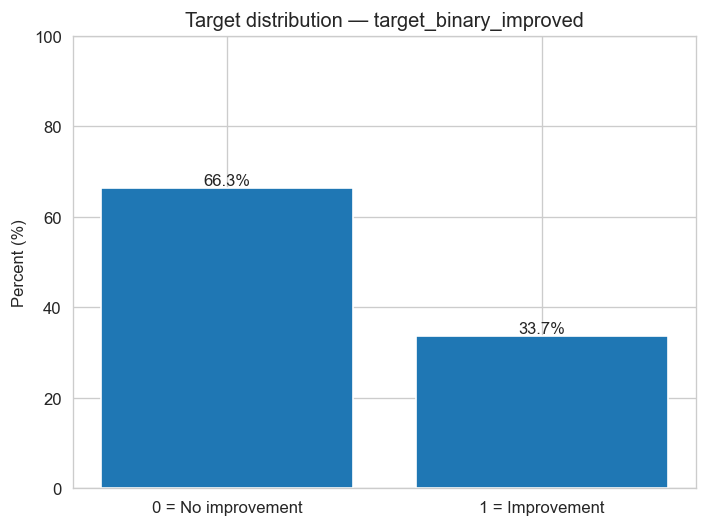

[Guidance] Positive class ratio: 0.337. Use Stratified CV; track ROC-AUC and PR-AUC; consider class_weight='balanced'.


In [60]:
# ===============================================================
# Target Balance Check (robust) — works with y in memory or from artifacts
# ===============================================================
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TARGET = "target_binary_improved"
OUT = Path("data/interim"); ART = Path("artifacts/feature_selection")

# Load y if missing
if "y" not in globals():
    y_path = OUT / "y_top40.csv"
    assert y_path.exists(), "y_top40.csv not found. Run the Top-40 loading cell first."
    y = pd.read_csv(y_path)[TARGET].astype(int)

# Ensure 1-D integer Series
y_series = pd.Series(y).squeeze().astype(int)

# Distribution
counts = y_series.value_counts().sort_index()
percentages = (counts / counts.sum() * 100).round(1)

print(f"[Target balance] n= {len(y_series)} | 0: {counts.get(0,0)} ({percentages.get(0,0.0)}%) | "
      f"1: {counts.get(1,0)} ({percentages.get(1,0.0)}%)")

# Optional plot (English labels)
fig = plt.figure(figsize=(6, 4.5))
plt.bar(["0 = No improvement", "1 = Improvement"], [percentages.get(0,0.0), percentages.get(1,0.0)])
plt.ylim(0, 100)
plt.ylabel("Percent (%)")
plt.title("Target distribution — target_binary_improved")
for x, v in zip([0,1], [percentages.get(0,0.0), percentages.get(1,0.0)]):
    plt.text(x, v, f"{v:.1f}%", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# Heuristic guidance
pos_ratio = counts.get(1,0) / counts.sum() if counts.sum() else 0.0
print(f"[Guidance] Positive class ratio: {pos_ratio:.3f}. "
      f"Use Stratified CV; track ROC-AUC and PR-AUC; consider class_weight='balanced'.")


בהתפלגות משתנה המטרה נצפתה קבוצה של 66.3% ילדים שלא הראו שיפור לעומת 33.7% שהראו שיפור. למרות שההתפלגות אינה שוויונית לחלוטין, היא לא נחשבת לא מאוזנת. נמשיך לשלב בחירת המודלים וכוונון ההיפרפרמטרים. 



In [61]:
# ===============================================================
# Final Save — Modeling-ready frame (Top-40, OHE, float64) + Manifest
# Produces for next notebook:
#   • data/processed/df_modeling_binary_ohe_<timestamp>.pkl  (primary)
#   • data/processed/df_modeling_binary_ohe_LATEST.pkl       (stable pointer)
#   • artifacts/feature_selection/df_modeling_manifest.json  (metadata)
#   • artifacts/feature_selection/final_top40_encoded_present.csv (if missing)
#   • data/interim/{X_selected_ohe.npy, X_selected_ohe_feature_names.csv, y_top40.csv}
# Assumptions:
#   • Xt_df (encoded features) + y exist in memory OR can be loaded from interim.
#   • Top-40 encoded names exist in artifacts/.../final_top40_encoded_present.csv
#     OR will be derived from multivariate_votes_per_feature.csv and intersected with Xt_df.
# ===============================================================
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np

ART = Path("artifacts/feature_selection"); ART.mkdir(parents=True, exist_ok=True)
DATA = Path("data"); (DATA / "processed").mkdir(parents=True, exist_ok=True)
OUTI = Path("data/interim"); OUTI.mkdir(parents=True, exist_ok=True)

TARGET = "target_binary_improved"
# Inputs/artifacts (prefer English)
VOTES_EN_ENC = ART / "final_top40_encoded_votes_en.csv"     # has Feature_en,sum_votes
PRESENT_EN   = ART / "final_top40_encoded_present_en.csv"   # has final_top40_present_en
MAP_PATH     = ART / "top40_encoded_he_to_en_map.csv"       # old→new (if needed)
VOTES_HE     = ART / "multivariate_votes_per_feature.csv"   # Feature,sum_votes (HE level)

# Families to force-include (prefixes over EN column names)
REQUIRED_FAMILIES = (
    "desired_main_outcome_",
    "desired_secondary_outcome_",
    "outputs_action_path_",
)

# ---------- 0) Load Xt_df / y (fallback to interim) ----------
if "Xt_df" not in globals():
    X_mat = np.load(OUTI / "X_selected_ohe.npy")
    feat_names = pd.read_csv(ART / "X_selected_ohe_feature_names.csv")["feature_after_ohe"].to_numpy()
    Xt_df = pd.DataFrame(X_mat, columns=feat_names)
    # If we have a HE→EN map, apply it so columns are English-aligned
    if MAP_PATH.exists():
        he2en = pd.read_csv(MAP_PATH, index_col=0).squeeze("columns").to_dict()
        Xt_df = Xt_df.rename(columns=he2en)

if "y" not in globals():
    y = pd.read_csv(OUTI / "y_selected.csv")[TARGET].astype("int")

# ---------- 1) Load votes/order (English-first; else map HE→EN) ----------
if VOTES_EN_ENC.exists():
    votes_en = pd.read_csv(VOTES_EN_ENC)
    assert {"Feature_en","sum_votes"} <= set(votes_en.columns), "English votes file must have Feature_en,sum_votes."
    base_order = (votes_en.sort_values("sum_votes", ascending=False)["Feature_en"]
                          .astype(str).tolist())
else:
    # Fallback: map HE votes to EN using the saved map
    assert VOTES_HE.exists() and MAP_PATH.exists(), "Missing votes_en and/or mapping; cannot align."
    votes_he = pd.read_csv(VOTES_HE)
    assert {"Feature","sum_votes"} <= set(votes_he.columns), "HE votes file must have Feature,sum_votes."
    he2en = pd.read_csv(MAP_PATH, index_col=0).squeeze("columns").to_dict()
    base_order = [he2en.get(f, f) for f in votes_he.sort_values("sum_votes", ascending=False)["Feature"].astype(str)]

# Keep only features that actually exist in Xt_df
base_order = [c for c in base_order if c in Xt_df.columns]

# ---------- 2) Initial Top-40 (by votes & presence) ----------
top40_initial = []
for c in base_order:
    if c in Xt_df.columns and c not in top40_initial:
        top40_initial.append(c)
    if len(top40_initial) == 40:
        break

# ---------- 3) Find required-family columns present in Xt_df ----------
family_cols = []
for pref in REQUIRED_FAMILIES:
    family_cols.extend([c for c in Xt_df.columns if c.startswith(pref)])
family_cols = list(dict.fromkeys(family_cols))  # dedup, keep order

# Diagnostics: which required-family members are missing from initial selection?
missing_required = [c for c in family_cols if c not in top40_initial]

# ---------- 4) Force-include required families while keeping total == 40 ----------
top40_final = top40_initial.copy()
added = []
if missing_required:
    # Add all missing required-family features (in the order they appear in base_order if possible)
    # We’ll append by priority: follow base_order ranking if present there; otherwise append at the end
    rank = {c: i for i, c in enumerate(base_order)}  # lower is more important
    missing_required_sorted = sorted(missing_required, key=lambda c: rank.get(c, 10**9))
    for c in missing_required_sorted:
        if c not in top40_final and c in Xt_df.columns:
            top40_final.append(c)
            added.append(c)
    # If we exceeded 40, remove lowest-priority non-family features to get back to 40
    if len(top40_final) > 40:
        over = len(top40_final) - 40
        family_set = set(family_cols)
        # Candidates to drop: items in top40_initial that are NOT in family_set, starting from the lowest priority by base_order
        # Build a priority list from lowest priority to highest (reverse base_order)
        prio = {c: i for i, c in enumerate(base_order)}  # smaller=better
        non_family_in_initial = [c for c in top40_initial if c not in family_set]
        # sort to drop worst-ranked first (highest prio index)
        non_family_in_initial_sorted = sorted(non_family_in_initial, key=lambda c: prio.get(c, 10**9), reverse=True)
        to_drop = non_family_in_initial_sorted[:over]
        top40_final = [c for c in top40_final if c not in to_drop]

# Ensure length==40 (if we still have <40 due to scarcity, just keep as is and warn)
if len(top40_final) != 40:
    print(f"⚠️ Warning: selection length is {len(top40_final)} (expected 40). Check availability.")

# ---------- 5) Persist updated lists (English) ----------
present_en = pd.Series(top40_final, name="final_top40_present_en")
present_en.to_csv(ART / "final_top40_encoded_present_en.csv", index=False, encoding="utf-8-sig")

# Keep a small log of forced inclusions
if added:
    pd.DataFrame({"forced_included": added}).to_csv(
        ART / "forced_inclusions_log.csv", index=False, encoding="utf-8-sig"
    )

# ---------- 6) Build df_model_top40 (English) and save ----------
X_top = Xt_df[top40_final].copy().astype("float64")
y_top = pd.Series(y, name=TARGET).astype("int8")
df_top40 = pd.concat([X_top, y_top], axis=1)

stamp = datetime.now().strftime("%Y%m%d_%H%M")
out_base = DATA / "processed" / f"df_model_top40_{stamp}"

# === Also save with the modeling-friendly name + stable pointer ===
model_base = f"df_modeling_binary_ohe_{stamp}"
model_pkl  = DATA / "processed" / f"{model_base}.pkl"
model_csv  = DATA / "processed" / f"{model_base}.csv"

df_top40.to_pickle(model_pkl)
df_top40.to_csv(model_csv, index=False, encoding="utf-8-sig")

stable_ptr = DATA / "processed" / "df_modeling_binary_ohe_LATEST.pkl"
if stable_ptr.exists():
    stable_ptr.unlink()
df_top40.to_pickle(stable_ptr)

# ---------- 7) Console diagnostics ----------
print("✅ Rebuilt df_model_top40 with forced-inclusion of outcome/action families.")
print(f"Shape: X={X_top.shape} | y={y_top.shape} | total={df_top40.shape}")
print(f"Families forced-included: {len(added)}")
if added:
    print("Added (first up to 10):", added[:10])
missing_fams = [pref for pref in REQUIRED_FAMILIES if not any(c.startswith(pref) for c in top40_final)]
if missing_fams:
    print("⚠️ Still missing families (no columns found in Xt_df):", missing_fams)
print("Saved:")
print(f"  • {out_base}.pkl / .csv")
print("  • artifacts/feature_selection/final_top40_encoded_present_en.csv")
if added:
    print("  • artifacts/feature_selection/forced_inclusions_log.csv")


✅ Rebuilt df_model_top40 with forced-inclusion of outcome/action families.
Shape: X=(21981, 40) | y=(21981,) | total=(21981, 41)
Families forced-included: 0
⚠️ Still missing families (no columns found in Xt_df): ['desired_main_outcome_', 'desired_secondary_outcome_', 'outputs_action_path_']
Saved:
  • data\processed\df_model_top40_20251106_1930.pkl / .csv
  • artifacts/feature_selection/final_top40_encoded_present_en.csv


# NEXT to - Model Selection